In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import time, copy, decimal
from pyswarm import pso # https://pythonhosted.org/pyswarm/
from IPython.display import clear_output

In [2]:
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    scores = list()
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + np.random.randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # keep track of scores
            scores.append(best_eval)
            # report progress
            #print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = np.exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or np.random.rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval, scores]

# Task 1

In [3]:
np.random.seed(1000)

f = lambda x: 1 / (x**2 - 3*x + 2)

k = np.array([ki for ki in range(0, 1001)])
x = 3 * k / 1000
y = f(x)
y[y < -100] = -100 + np.random.normal(size=y[y < -100].shape[0])
y[y > 100] = 100 + np.random.normal(size=y[y > 100].shape[0])

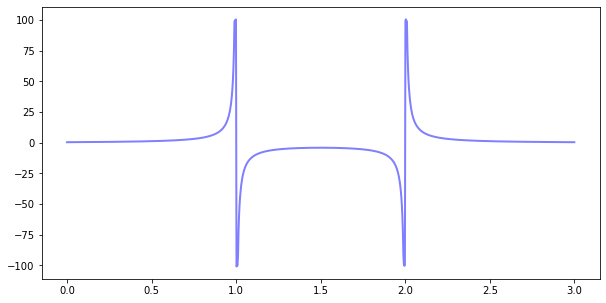

In [4]:
plt.figure(figsize=(10,5))
plt.plot(x, y, 'b', lw=2, alpha=0.5)

In [5]:
def approx(x, a, b, c, d):
    return (a*x + b) / (x**2 + c*x + d)

def least_squares(vector, func, x, y):
    return np.sum( (func(x, *vector) - y)**2 )

def least_squares_lm(vector, func, x, y):
    return func(x, *vector) - y

# optfun = lambda vector: least_squares(vector, approx, x, y)
# optfun_lm = lambda vector: least_squares_lm(vector, approx, x, y)

In [6]:
%%time

eps = 1e-3

x0 = np.ones((4, )) * 10

opt_nelder_mead = optimize.minimize(least_squares, x0, method='nelder-mead', args=(approx, x, y),
                                    options={'disp': True, 'maxiter': 1000, 'fatol': eps})
print("nelder-mead done")

x0 = np.ones((4, )) * 10
opt_lm = optimize.least_squares(least_squares_lm, x0, method='lm', args=(approx, x, y), ftol=eps)

print("lm done")

lb = np.ones((4, )) * -10
ub = np.ones((4, )) * 10
xopt, fopt = pso(least_squares, lb, ub, maxiter=1000, args=(approx, x, y), swarmsize=1000, minfunc=eps)

print("pso done")

bounds = np.asarray([[-10, 10], [-10, 10], [-10, 10], [-10, 10]])
opt_diff_ev = optimize.differential_evolution(least_squares, bounds, args=(approx, x, y), tol=eps)

Optimization terminated successfully.
         Current function value: 135192.844039
         Iterations: 403
         Function evaluations: 693
nelder-mead done
lm done
Stopping search: Swarm best objective change less than 0.001
pso done
Wall time: 3.1 s


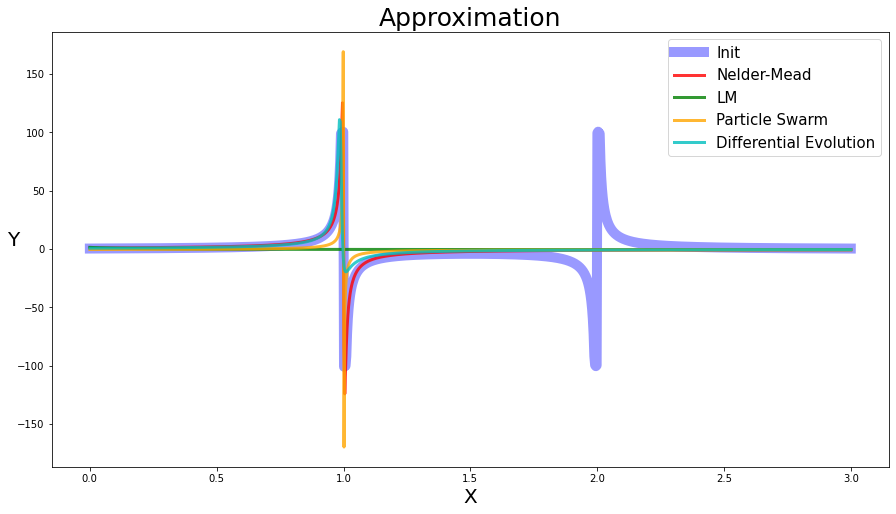

In [7]:
plt.figure(figsize=(15,8))
plt.title("Approximation", fontsize=25)
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20, rotation=0)
plt.plot(x, y, 'b', lw=10, alpha=0.4, label="Init")
plt.plot(x, approx(x, *opt_nelder_mead.x), 'r', label="Nelder-Mead", lw=3, alpha=0.8)
plt.plot(x, approx(x, *opt_lm.x), 'g', label="LM", lw=3, alpha=0.8)
plt.plot(x, approx(x, *xopt), color='orange', label="Particle Swarm", lw=3, alpha=0.8)
plt.plot(x, approx(x, *opt_diff_ev.x), color='c', label="Differential Evolution", lw=3, alpha=0.8)
plt.legend(fontsize=15)

# Task 2

In [8]:
coordinates = np.asarray([
  [0.549963e-07,  0.985808e-08],
  [-28.8733,     -0.797739e-07],
  [-79.2916,      -21.4033],    
  [-14.6577,      -43.3896],    
  [-64.7473,       21.8982],    
  [-29.0585,      -43.2167],    
  [-72.0785,      0.181581],    
  [-36.0366,      -21.6135],    
  [-50.4808,       7.37447],    
  [-50.5859,      -21.5882],    
 [-0.135819,      -28.7293],    
  [-65.0866,      -36.0625],    
  [-21.4983,       7.31942],    
  [-57.5687,      -43.2506],    
  [-43.0700,       14.5548]])

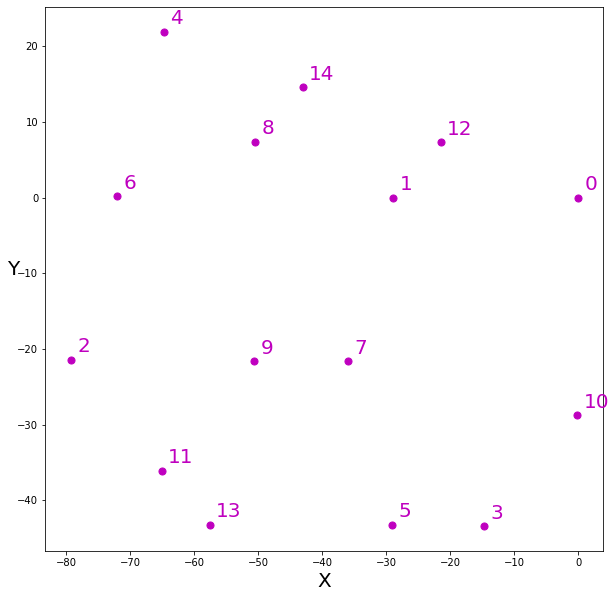

In [63]:
def plot_map(coordinates):
    fig, ax = plt.figure(figsize=(10,10))
    plt.xlabel("X", fontsize=20)
    plt.ylabel("Y", fontsize=20, rotation=0)
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=50, c='m', marker='o')
    for i, point in enumerate(coordinates):
        plt.text(point[0]+1, point[1]+1, s=(i), size=20, color='m')
    return fig
f = plot_map(coordinates)

In [56]:
def get_distance(p1, p2):
    return np.sqrt( np.sum( (p2 - p1)**2 ) )

def get_distmatrix(coordinates, r=0):
    distmatrix = np.ones((coordinates.shape[0], coordinates.shape[0]))

    for i, point1 in enumerate(coordinates):
        for j, point2 in enumerate(coordinates):
            distmatrix[i, j] = np.round(get_distance(point1, point2), r)
    return distmatrix

In [250]:
def get_track(sequence,  coordinates, plot=False):
    if plot:
        fig = plot_map(coordinates)
        
    distmatrix = get_distmatrix(coordinates, r=0)
    track = 0
    p_i = 0
    for i in range(len(sequence) + 1):
        try:
            p_j = sequence[i]
        except:
            p_j = 0
        track += distmatrix[p_i, p_j]
            
        if plot:
            plt.arrow(coordinates[p_i, 0], coordinates[p_i, 1], 
                         coordinates[p_j, 0] - coordinates[p_i, 0], coordinates[p_j, 1] - coordinates[p_i, 1], 
                     color='r', lw=0.002, width = 0.5, length_includes_head = True, alpha=0.6)
        try:
            p_i = sequence[i]
        except:
            break
            
    if plot:
        plt.title(f"Track = {track}", fontsize=25)
        plt.show()
        #time.sleep(0.5)
        plt.close(fig)
        #clear_output()
    return track

In [251]:
np.arange(0, 15)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [252]:
X.shape

(14,)

In [312]:
# optimization
sequence = np.arange(1, 15)

T = 100000
Alpha = 0.999
X = np.random.permutation(sequence)

scores = []
i = 0
Z = 1000
while Z > 290:
    i += 1
    Z = get_track(X, coordinates)
    scores.append(Z)
    Xp = copy.deepcopy(X)
    a = random.sample(range(0, 14), 2)
    Xp[a[0]], Xp[a[1]] = Xp[a[1]], Xp[a[0]]
    Zp = get_track(Xp, coordinates, plot=False)
    
    #decimal.getcontext().prec = 5
    deltaZ = Zp - Z
    Prob = np.exp(-deltaZ / T)
    #np.exp(-deltaZ / T)
    #decimal.Decimal(-deltaZ/T).exp()
    print("probabilidad: ", Prob)
    print("Temperatura: ",T)
    print("Z: ",Z)
    print("Zp: ",Zp)
    print("\n")    
    if Zp < Z:
        X = Xp
        T = T*Alpha
    else:
        num = random.randint(0,1)
        if num < Prob:
            X = Xp
            T = T*Alpha

probabilidad:  0.999820016199028
Temperatura:  100000
Z:  650.0
Zp:  668.0


probabilidad:  0.9993602047563164
Temperatura:  100000
Z:  650.0
Zp:  714.0


probabilidad:  0.9996800511945391
Temperatura:  100000
Z:  650.0
Zp:  682.0


probabilidad:  0.9999499512024328
Temperatura:  99900.0
Z:  682.0
Zp:  687.0


probabilidad:  0.9998396923700007
Temperatura:  99800.1
Z:  687.0
Zp:  703.0


probabilidad:  0.9998597294182774
Temperatura:  99800.1
Z:  687.0
Zp:  701.0


probabilidad:  0.9999598805644054
Temperatura:  99700.29990000001
Z:  701.0
Zp:  705.0


probabilidad:  1.0001303992825494
Temperatura:  99700.29990000001
Z:  701.0
Zp:  688.0


probabilidad:  1.0002610766797948
Temperatura:  99600.59960010002
Z:  688.0
Zp:  662.0


probabilidad:  1.000110557764917
Temperatura:  99500.99900049991
Z:  662.0
Zp:  651.0


probabilidad:  0.9999094622037423
Temperatura:  99401.4980014994
Z:  651.0
Zp:  660.0


probabilidad:  1.0001911622698425
Temperatura:  99401.4980014994
Z:  651.0
Zp:  632.0



probabilidad:  0.9998723287086637
Temperatura:  93985.37314349835
Z:  505.0
Zp:  517.0


probabilidad:  1.000149119574687
Temperatura:  93891.38777035485
Z:  517.0
Zp:  503.0


probabilidad:  1.000575874081841
Temperatura:  93797.49638258449
Z:  503.0
Zp:  449.0


probabilidad:  0.9992852357661353
Temperatura:  93703.6988862019
Z:  449.0
Zp:  516.0


probabilidad:  0.9994452132111401
Temperatura:  93703.6988862019
Z:  449.0
Zp:  501.0


probabilidad:  1.0004376451683246
Temperatura:  93703.6988862019
Z:  449.0
Zp:  408.0


probabilidad:  0.9995087202007952
Temperatura:  93609.9951873157
Z:  408.0
Zp:  454.0


probabilidad:  0.9988576126895257
Temperatura:  93609.9951873157
Z:  408.0
Zp:  515.0


probabilidad:  0.9984842179301444
Temperatura:  93609.9951873157
Z:  408.0
Zp:  550.0


probabilidad:  0.9992951955761892
Temperatura:  93609.9951873157
Z:  408.0
Zp:  474.0


probabilidad:  0.9992097984991416
Temperatura:  93609.9951873157
Z:  408.0
Zp:  482.0


probabilidad:  0.99965821458426

probabilidad:  1.0001149270056213
Temperatura:  87016.75093639089
Z:  550.0
Zp:  540.0


probabilidad:  0.9993330169948725
Temperatura:  86929.7341854545
Z:  540.0
Zp:  598.0


probabilidad:  0.999297828051113
Temperatura:  86842.80445126904
Z:  598.0
Zp:  659.0


probabilidad:  0.9994934657444182
Temperatura:  86842.80445126904
Z:  598.0
Zp:  642.0


probabilidad:  0.9994468769302846
Temperatura:  86755.96164681777
Z:  642.0
Zp:  690.0


probabilidad:  0.9994578552084973
Temperatura:  86669.20568517095
Z:  690.0
Zp:  737.0


probabilidad:  1.0005539833207524
Temperatura:  86669.20568517095
Z:  690.0
Zp:  642.0


probabilidad:  1.0006701054652354
Temperatura:  86582.53647948577
Z:  642.0
Zp:  584.0


probabilidad:  1.0001040565232933
Temperatura:  86495.95394300629
Z:  584.0
Zp:  575.0


probabilidad:  0.9996181702769998
Temperatura:  86409.45798906327
Z:  575.0
Zp:  608.0


probabilidad:  0.9989358683251037
Temperatura:  86409.45798906327
Z:  575.0
Zp:  667.0


probabilidad:  0.999791

probabilidad:  0.999412103595711
Temperatura:  79922.55563671298
Z:  600.0
Zp:  647.0


probabilidad:  0.9992620577813573
Temperatura:  79922.55563671298
Z:  600.0
Zp:  659.0


probabilidad:  1.0007885738426472
Temperatura:  79922.55563671298
Z:  600.0
Zp:  537.0


probabilidad:  1.0004635189623685
Temperatura:  79842.63308107626
Z:  537.0
Zp:  500.0


probabilidad:  0.9992605802267411
Temperatura:  79762.79044799518
Z:  500.0
Zp:  559.0


probabilidad:  0.9998494146518027
Temperatura:  79683.0276575472
Z:  559.0
Zp:  571.0


probabilidad:  0.9994223017654004
Temperatura:  79603.34462988965
Z:  571.0
Zp:  617.0


probabilidad:  0.9996859921550696
Temperatura:  79603.34462988965
Z:  571.0
Zp:  596.0


probabilidad:  1.0000376875688446
Temperatura:  79603.34462988965
Z:  571.0
Zp:  568.0


probabilidad:  0.9997233913192626
Temperatura:  79523.74128525976
Z:  568.0
Zp:  590.0


probabilidad:  0.9989945169500035
Temperatura:  79523.74128525976
Z:  568.0
Zp:  648.0


probabilidad:  0.999962

probabilidad:  0.9996991434107285
Temperatura:  73113.54045730208
Z:  625.0
Zp:  647.0


probabilidad:  1.000082067509816
Temperatura:  73113.54045730208
Z:  625.0
Zp:  619.0


probabilidad:  1.0000273824711434
Temperatura:  73040.42691684478
Z:  619.0
Zp:  617.0


probabilidad:  0.9999040713313028
Temperatura:  72967.38648992793
Z:  617.0
Zp:  624.0


probabilidad:  0.9987262698660575
Temperatura:  72967.38648992793
Z:  617.0
Zp:  710.0


probabilidad:  0.9998902582512713
Temperatura:  72894.419103438
Z:  710.0
Zp:  718.0


probabilidad:  1.0005351635315587
Temperatura:  72894.419103438
Z:  710.0
Zp:  671.0


probabilidad:  0.9997803088787824
Temperatura:  72821.52468433457
Z:  671.0
Zp:  687.0


probabilidad:  1.0001373314646316
Temperatura:  72821.52468433457
Z:  671.0
Zp:  661.0


probabilidad:  1.000632513629547
Temperatura:  72748.70315965023
Z:  661.0
Zp:  615.0


probabilidad:  1.000165130143021
Temperatura:  72675.95445649058
Z:  615.0
Zp:  603.0


probabilidad:  1.00037195319

probabilidad:  1.0004756855009218
Temperatura:  67287.33649170399
Z:  630.0
Zp:  598.0


probabilidad:  1.0013099905179055
Temperatura:  67220.04915521228
Z:  598.0
Zp:  510.0


probabilidad:  0.9977687820699271
Temperatura:  67152.82910605708
Z:  510.0
Zp:  660.0


probabilidad:  0.9995533576133033
Temperatura:  67152.82910605708
Z:  510.0
Zp:  540.0


probabilidad:  1.0
Temperatura:  67085.67627695102
Z:  540.0
Zp:  540.0


probabilidad:  1.0000894418697792
Temperatura:  67085.67627695102
Z:  540.0
Zp:  534.0


probabilidad:  0.9992393065953635
Temperatura:  67018.59060067407
Z:  534.0
Zp:  585.0


probabilidad:  0.9980899967394092
Temperatura:  66951.57201007339
Z:  585.0
Zp:  713.0


probabilidad:  1.000642461560701
Temperatura:  66951.57201007339
Z:  585.0
Zp:  542.0


probabilidad:  0.9996860757602349
Temperatura:  66884.62043806331
Z:  542.0
Zp:  563.0


probabilidad:  0.9992669305985135
Temperatura:  66817.73581762525
Z:  563.0
Zp:  612.0


probabilidad:  1.0003592505860193
Tem

probabilidad:  0.9999675091442017
Temperatura:  61554.780870776325
Z:  674.0
Zp:  676.0


probabilidad:  0.9999512153286931
Temperatura:  61493.22608990555
Z:  676.0
Zp:  679.0


probabilidad:  0.9984563071130926
Temperatura:  61493.22608990555
Z:  676.0
Zp:  771.0


probabilidad:  1.000016262085999
Temperatura:  61493.22608990555
Z:  676.0
Zp:  675.0


probabilidad:  1.0002279212181588
Temperatura:  61431.73286381564
Z:  675.0
Zp:  661.0


probabilidad:  0.9995112836648182
Temperatura:  61370.301130951826
Z:  661.0
Zp:  691.0


probabilidad:  1.0000325895840911
Temperatura:  61370.301130951826
Z:  661.0
Zp:  659.0


probabilidad:  0.9988100174635169
Temperatura:  61308.93082982087
Z:  659.0
Zp:  732.0


probabilidad:  1.0006036831259908
Temperatura:  61308.93082982087
Z:  659.0
Zp:  622.0


probabilidad:  0.9997714458190251
Temperatura:  61247.62189899105
Z:  622.0
Zp:  636.0


probabilidad:  1.0012592422997835
Temperatura:  61186.37427709206
Z:  636.0
Zp:  559.0


probabilidad:  0.99

probabilidad:  0.9998413002575983
Temperatura:  56706.36698003504
Z:  575.0
Zp:  584.0


probabilidad:  1.0
Temperatura:  56649.660613055006
Z:  584.0
Zp:  584.0


probabilidad:  0.9996996546631685
Temperatura:  56593.01095244195
Z:  584.0
Zp:  601.0


probabilidad:  1.0009192636390765
Temperatura:  56593.01095244195
Z:  584.0
Zp:  532.0


probabilidad:  0.9987449605164863
Temperatura:  56536.41794148951
Z:  532.0
Zp:  603.0


probabilidad:  0.9999114768205258
Temperatura:  56479.88152354802
Z:  603.0
Zp:  608.0


probabilidad:  0.9998583666743354
Temperatura:  56479.88152354802
Z:  603.0
Zp:  611.0


probabilidad:  0.9991328106669478
Temperatura:  56479.88152354802
Z:  603.0
Zp:  652.0


probabilidad:  0.9988309564449848
Temperatura:  56423.40164202447
Z:  652.0
Zp:  718.0


probabilidad:  1.000337133605216
Temperatura:  56366.97824038245
Z:  718.0
Zp:  699.0


probabilidad:  0.9996626427151158
Temperatura:  56310.61126214207
Z:  699.0
Zp:  718.0


probabilidad:  1.000569007220462
Tem

probabilidad:  0.9997898757525469
Temperatura:  52344.47908547373
Z:  508.0
Zp:  519.0


probabilidad:  1.0003442792777777
Temperatura:  52292.13460638825
Z:  519.0
Zp:  501.0


probabilidad:  0.9983933239927236
Temperatura:  52239.84247178186
Z:  501.0
Zp:  585.0


probabilidad:  0.9993302376845876
Temperatura:  52239.84247178186
Z:  501.0
Zp:  536.0


probabilidad:  0.999923433022099
Temperatura:  52239.84247178186
Z:  501.0
Zp:  505.0


probabilidad:  0.99845066080376
Temperatura:  52239.84247178186
Z:  501.0
Zp:  582.0


probabilidad:  0.9984888871737727
Temperatura:  52239.84247178186
Z:  501.0
Zp:  580.0


probabilidad:  0.9986021782198234
Temperatura:  52187.60262931008
Z:  580.0
Zp:  653.0


probabilidad:  0.9986965544786837
Temperatura:  52135.41502668077
Z:  653.0
Zp:  721.0


probabilidad:  0.9987144257326387
Temperatura:  52083.27961165409
Z:  721.0
Zp:  788.0


probabilidad:  0.9989445562837186
Temperatura:  52083.27961165409
Z:  721.0
Zp:  776.0


probabilidad:  1.0013462

probabilidad:  0.9998120672958429
Temperatura:  47884.98264154835
Z:  638.0
Zp:  647.0


probabilidad:  1.0004809140017623
Temperatura:  47837.0976589068
Z:  647.0
Zp:  624.0


probabilidad:  0.9997907698571735
Temperatura:  47789.260561247895
Z:  624.0
Zp:  634.0


probabilidad:  0.9991625049109312
Temperatura:  47741.471300686644
Z:  634.0
Zp:  674.0


probabilidad:  1.0005452936532004
Temperatura:  47693.72982938596
Z:  674.0
Zp:  648.0


probabilidad:  1.0003778572568676
Temperatura:  47646.03609955657
Z:  648.0
Zp:  630.0


probabilidad:  0.9998319412119747
Temperatura:  47598.39006345702
Z:  630.0
Zp:  638.0


probabilidad:  0.9991180063999111
Temperatura:  47598.39006345702
Z:  630.0
Zp:  672.0


probabilidad:  0.9996635742985451
Temperatura:  47550.791673393556
Z:  672.0
Zp:  688.0


probabilidad:  0.9996845975886046
Temperatura:  47550.791673393556
Z:  672.0
Zp:  687.0


probabilidad:  1.000526418391431
Temperatura:  47503.240881720165
Z:  687.0
Zp:  662.0


probabilidad:  1.0

probabilidad:  0.9997258246363531
Temperatura:  43761.608311706346
Z:  707.0
Zp:  719.0


probabilidad:  1.000205886774794
Temperatura:  43717.846703394636
Z:  719.0
Zp:  710.0


probabilidad:  0.9996794954652828
Temperatura:  43674.12885669124
Z:  710.0
Zp:  724.0


probabilidad:  1.0001604512629556
Temperatura:  43630.45472783455
Z:  724.0
Zp:  717.0


probabilidad:  1.0000458864787578
Temperatura:  43586.824273106715
Z:  717.0
Zp:  715.0


probabilidad:  0.9999081415045242
Temperatura:  43543.237448833606
Z:  715.0
Zp:  719.0


probabilidad:  0.9996552294368027
Temperatura:  43499.694211384776
Z:  719.0
Zp:  734.0


probabilidad:  1.0015199247323363
Temperatura:  43456.19451717339
Z:  734.0
Zp:  668.0


probabilidad:  1.0001612559965416
Temperatura:  43412.738322656216
Z:  668.0
Zp:  661.0


probabilidad:  1.0014536951973052
Temperatura:  43369.32558433356
Z:  661.0
Zp:  598.0


probabilidad:  1.0000692449544175
Temperatura:  43325.956258749226
Z:  598.0
Zp:  595.0


probabilidad:  

Temperatura:  39437.01631993214
Z:  658.0
Zp:  707.0


probabilidad:  1.0015749396643363
Temperatura:  39397.579303612205
Z:  707.0
Zp:  645.0


probabilidad:  1.0000254080005766
Temperatura:  39358.18172430859
Z:  645.0
Zp:  644.0


probabilidad:  0.9990594175216102
Temperatura:  39318.82354258428
Z:  644.0
Zp:  681.0


probabilidad:  1.0
Temperatura:  39279.504719041695
Z:  681.0
Zp:  681.0


probabilidad:  1.000534772899133
Temperatura:  39279.504719041695
Z:  681.0
Zp:  660.0


probabilidad:  1.0009943721482701
Temperatura:  39240.22521432265
Z:  660.0
Zp:  621.0


probabilidad:  0.9987762903154762
Temperatura:  39200.98498910833
Z:  621.0
Zp:  669.0


probabilidad:  1.000765579799605
Temperatura:  39200.98498910833
Z:  621.0
Zp:  591.0


probabilidad:  0.9980102445340929
Temperatura:  39161.78400411922
Z:  591.0
Zp:  669.0


probabilidad:  1.000204301652293
Temperatura:  39161.78400411922
Z:  591.0
Zp:  583.0


probabilidad:  0.9995911130754059
Temperatura:  39122.622220115096
Z: 

probabilidad:  1.0004652311333786
Temperatura:  36549.47603053144
Z:  574.0
Zp:  557.0


probabilidad:  0.9999452263783104
Temperatura:  36512.92655450091
Z:  557.0
Zp:  559.0


probabilidad:  0.9996162639831091
Temperatura:  36476.41362794641
Z:  559.0
Zp:  573.0


probabilidad:  0.9994792510949769
Temperatura:  36476.41362794641
Z:  559.0
Zp:  578.0


probabilidad:  0.9996158799367556
Temperatura:  36439.93721431846
Z:  578.0
Zp:  592.0


probabilidad:  1.0004666299490628
Temperatura:  36439.93721431846
Z:  578.0
Zp:  561.0


probabilidad:  1.0003022144276936
Temperatura:  36403.49727710414
Z:  561.0
Zp:  550.0


probabilidad:  1.0000549962833953
Temperatura:  36367.09377982704
Z:  550.0
Zp:  548.0


probabilidad:  0.9992020960906004
Temperatura:  36330.72668604721
Z:  548.0
Zp:  577.0


probabilidad:  0.9978532155348594
Temperatura:  36294.39595936116
Z:  577.0
Zp:  655.0


probabilidad:  1.0003031230249635
Temperatura:  36294.39595936116
Z:  577.0
Zp:  566.0


probabilidad:  0.9988

probabilidad:  1.0005040088113832
Temperatura:  33738.068325533124
Z:  750.0
Zp:  733.0


probabilidad:  0.9999109946268901
Temperatura:  33704.33025720759
Z:  733.0
Zp:  736.0


probabilidad:  1.0013671096124375
Temperatura:  33670.625926950386
Z:  736.0
Zp:  690.0


probabilidad:  1.0001486570823295
Temperatura:  33636.95530102344
Z:  690.0
Zp:  685.0


probabilidad:  1.0006549116076928
Temperatura:  33603.318345722415
Z:  685.0
Zp:  663.0


probabilidad:  0.9994341738043178
Temperatura:  33569.71502737669
Z:  663.0
Zp:  682.0


probabilidad:  1.0007755835096896
Temperatura:  33536.14531234931
Z:  682.0
Zp:  656.0


probabilidad:  1.0
Temperatura:  33502.609167036964
Z:  656.0
Zp:  656.0


probabilidad:  0.9996717212586851
Temperatura:  33502.609167036964
Z:  656.0
Zp:  667.0


probabilidad:  0.9984788885676533
Temperatura:  33502.609167036964
Z:  656.0
Zp:  707.0


probabilidad:  1.0005678488614842
Temperatura:  33469.10655786993
Z:  707.0
Zp:  688.0


probabilidad:  1.0002991268096

probabilidad:  1.000289611059312
Temperatura:  31080.661105455558
Z:  580.0
Zp:  571.0


probabilidad:  0.9973625467510898
Temperatura:  31049.580444350104
Z:  571.0
Zp:  653.0


probabilidad:  0.998067542017593
Temperatura:  31018.530863905755
Z:  653.0
Zp:  713.0


probabilidad:  0.9991613042327823
Temperatura:  30987.51233304185
Z:  713.0
Zp:  739.0


probabilidad:  1.0010665795216558
Temperatura:  30956.524820708808
Z:  739.0
Zp:  706.0


probabilidad:  0.9989334909174526
Temperatura:  30925.5682958881
Z:  706.0
Zp:  739.0


probabilidad:  1.0009715137544237
Temperatura:  30894.642727592214
Z:  739.0
Zp:  709.0


probabilidad:  1.0013293020843266
Temperatura:  30863.748084864623
Z:  709.0
Zp:  668.0


probabilidad:  1.0
Temperatura:  30832.88433677976
Z:  668.0
Zp:  668.0


probabilidad:  0.9997729954363817
Temperatura:  30832.88433677976
Z:  668.0
Zp:  675.0


probabilidad:  0.9975032884846435
Temperatura:  30802.051452442982
Z:  675.0
Zp:  752.0


probabilidad:  0.999935071367770

probabilidad:  0.9992265433591503
Temperatura:  28432.73910687571
Z:  643.0
Zp:  665.0


probabilidad:  1.0022182121688106
Temperatura:  28432.73910687571
Z:  643.0
Zp:  580.0


probabilidad:  1.000986252045638
Temperatura:  28404.306367768833
Z:  580.0
Zp:  552.0


probabilidad:  1.0002114693789397
Temperatura:  28375.902061401066
Z:  552.0
Zp:  546.0


probabilidad:  0.9972170403303796
Temperatura:  28347.526159339664
Z:  546.0
Zp:  625.0


probabilidad:  0.999223442987111
Temperatura:  28319.178633180323
Z:  625.0
Zp:  647.0


probabilidad:  1.0007779387633196
Temperatura:  28290.859454547142
Z:  647.0
Zp:  625.0


probabilidad:  1.0001061530984607
Temperatura:  28262.568595092594
Z:  625.0
Zp:  622.0


probabilidad:  1.0001771052118393
Temperatura:  28234.306026497503
Z:  622.0
Zp:  617.0


probabilidad:  1.0
Temperatura:  28206.071720471005
Z:  617.0
Zp:  617.0


probabilidad:  1.002236057903722
Temperatura:  28206.071720471005
Z:  617.0
Zp:  554.0


probabilidad:  0.9984397091952

probabilidad:  0.9972522265814181
Temperatura:  26167.017377341384
Z:  546.0
Zp:  618.0


probabilidad:  1.0010333997602683
Temperatura:  26140.850359964043
Z:  618.0
Zp:  591.0


probabilidad:  0.99762867514115
Temperatura:  26114.70950960408
Z:  591.0
Zp:  653.0


probabilidad:  0.9976668776635986
Temperatura:  26114.70950960408
Z:  591.0
Zp:  652.0


probabilidad:  1.0009203655036487
Temperatura:  26088.594800094474
Z:  652.0
Zp:  628.0


probabilidad:  1.0012285715299094
Temperatura:  26062.50620529438
Z:  628.0
Zp:  596.0


probabilidad:  0.9982731460903645
Temperatura:  26036.443699089086
Z:  596.0
Zp:  641.0


probabilidad:  0.996396185290354
Temperatura:  26036.443699089086
Z:  596.0
Zp:  690.0


probabilidad:  0.998578503761138
Temperatura:  26010.407255389997
Z:  690.0
Zp:  727.0


probabilidad:  1.0015020276375957
Temperatura:  25984.396848134606
Z:  727.0
Zp:  688.0


probabilidad:  1.001002103854549
Temperatura:  25958.41245128647
Z:  688.0
Zp:  662.0


probabilidad:  1.00

probabilidad:  1.0003332545840402
Temperatura:  24009.67106680929
Z:  602.0
Zp:  594.0


probabilidad:  0.9992498331666914
Temperatura:  23985.66139574248
Z:  594.0
Zp:  612.0


probabilidad:  0.9995414978197261
Temperatura:  23985.66139574248
Z:  594.0
Zp:  605.0


probabilidad:  0.9989166063462137
Temperatura:  23985.66139574248
Z:  594.0
Zp:  620.0


probabilidad:  0.9989582536209483
Temperatura:  23985.66139574248
Z:  594.0
Zp:  619.0


probabilidad:  1.0003756703208246
Temperatura:  23961.67573434674
Z:  619.0
Zp:  610.0


probabilidad:  1.0005432235760612
Temperatura:  23937.714058612393
Z:  610.0
Zp:  597.0


probabilidad:  1.0011715589466441
Temperatura:  23913.776344553782
Z:  597.0
Zp:  569.0


probabilidad:  0.9998325789804274
Temperatura:  23889.862568209228
Z:  569.0
Zp:  573.0


probabilidad:  0.999079531193354
Temperatura:  23889.862568209228
Z:  569.0
Zp:  591.0


probabilidad:  1.0018873084139583
Temperatura:  23865.97270564102
Z:  591.0
Zp:  546.0


probabilidad:  0.9

probabilidad:  1.0031571004757769
Temperatura:  22207.224953304492
Z:  674.0
Zp:  604.0


probabilidad:  0.9999549255504391
Temperatura:  22185.017728351188
Z:  604.0
Zp:  605.0


probabilidad:  0.9998646474028978
Temperatura:  22162.832710622835
Z:  605.0
Zp:  608.0


probabilidad:  0.9980616957433351
Temperatura:  22162.832710622835
Z:  605.0
Zp:  648.0


probabilidad:  1.0009489307375758
Temperatura:  22140.669877912213
Z:  648.0
Zp:  627.0


probabilidad:  1.0028070119913948
Temperatura:  22118.5292080343
Z:  627.0
Zp:  565.0


probabilidad:  0.9995475402011809
Temperatura:  22096.410678826265
Z:  565.0
Zp:  575.0


probabilidad:  0.9961567749249781
Temperatura:  22074.31426814744
Z:  575.0
Zp:  660.0


probabilidad:  0.9982330350971205
Temperatura:  22052.239953879292
Z:  660.0
Zp:  699.0


probabilidad:  0.9982312679286145
Temperatura:  22030.187713925414
Z:  699.0
Zp:  738.0


probabilidad:  0.9986831745545627
Temperatura:  22008.15752621149
Z:  738.0
Zp:  767.0


probabilidad: 

probabilidad:  1.0018247754770202
Temperatura:  20294.961520007753
Z:  602.0
Zp:  565.0


probabilidad:  0.9982751969231721
Temperatura:  20274.666558487745
Z:  565.0
Zp:  600.0


probabilidad:  0.9975369066015787
Temperatura:  20274.666558487745
Z:  565.0
Zp:  615.0


probabilidad:  0.9997041079682955
Temperatura:  20274.666558487745
Z:  565.0
Zp:  571.0


probabilidad:  1.0006914470523975
Temperatura:  20254.391891929256
Z:  571.0
Zp:  557.0


probabilidad:  1.0003954496056071
Temperatura:  20234.137500037326
Z:  557.0
Zp:  549.0


probabilidad:  0.9999010630937729
Temperatura:  20213.90336253729
Z:  549.0
Zp:  551.0


probabilidad:  1.0000990457463534
Temperatura:  20193.68945917475
Z:  551.0
Zp:  549.0


probabilidad:  0.9999008649325767
Temperatura:  20173.495769715577
Z:  549.0
Zp:  551.0


probabilidad:  1.0001982996220289
Temperatura:  20173.495769715577
Z:  549.0
Zp:  545.0


probabilidad:  0.9987602788293726
Temperatura:  20153.32227394586
Z:  545.0
Zp:  570.0


probabilidad:

probabilidad:  1.0007520921913653
Temperatura:  18621.73832738309
Z:  685.0
Zp:  671.0


probabilidad:  1.003715942995479
Temperatura:  18603.116589055706
Z:  671.0
Zp:  602.0


probabilidad:  1.0012922320233073
Temperatura:  18584.51347246665
Z:  602.0
Zp:  578.0


probabilidad:  0.9949497577779278
Temperatura:  18565.928958994184
Z:  578.0
Zp:  672.0


probabilidad:  1.0031288868228483
Temperatura:  18565.928958994184
Z:  578.0
Zp:  520.0


probabilidad:  1.0012408376676885
Temperatura:  18547.36303003519
Z:  520.0
Zp:  497.0


probabilidad:  0.9961754629384635
Temperatura:  18528.815667005154
Z:  497.0
Zp:  568.0


probabilidad:  1.0008106886437882
Temperatura:  18510.286851338147
Z:  568.0
Zp:  553.0


probabilidad:  0.9965449844419
Temperatura:  18491.77656448681
Z:  553.0
Zp:  617.0


probabilidad:  0.9988097999109075
Temperatura:  18473.284787922323
Z:  617.0
Zp:  639.0


probabilidad:  0.9977808231732314
Temperatura:  18454.8115031344
Z:  639.0
Zp:  680.0


probabilidad:  1.003

probabilidad:  0.9995899929753073
Temperatura:  17069.377976089043
Z:  634.0
Zp:  641.0


probabilidad:  0.9995309653429824
Temperatura:  17052.308598112955
Z:  641.0
Zp:  649.0


probabilidad:  1.0014686220659375
Temperatura:  17035.256289514844
Z:  649.0
Zp:  624.0


probabilidad:  1.0008229861444273
Temperatura:  17018.22103322533
Z:  624.0
Zp:  610.0


probabilidad:  1.0009415528664818
Temperatura:  17001.202812192107
Z:  610.0
Zp:  594.0


probabilidad:  1.0017089276886448
Temperatura:  16984.201609379914
Z:  594.0
Zp:  565.0


probabilidad:  0.9969399579777457
Temperatura:  16967.217407770535
Z:  565.0
Zp:  617.0


probabilidad:  0.9985865075271215
Temperatura:  16967.217407770535
Z:  565.0
Zp:  589.0


probabilidad:  1.0010034381562278
Temperatura:  16950.250190362764
Z:  589.0
Zp:  572.0


probabilidad:  1.0005907267560612
Temperatura:  16933.2999401724
Z:  572.0
Zp:  562.0


probabilidad:  0.9981101288941704
Temperatura:  16916.366640232227
Z:  562.0
Zp:  594.0


probabilidad:

probabilidad:  0.9965649894071203
Temperatura:  15693.460054388717
Z:  661.0
Zp:  715.0


probabilidad:  1.0008924893840025
Temperatura:  15693.460054388717
Z:  661.0
Zp:  647.0


probabilidad:  1.003194320777166
Temperatura:  15677.766594334329
Z:  647.0
Zp:  597.0


probabilidad:  1.001853320152145
Temperatura:  15662.088827739995
Z:  597.0
Zp:  568.0


probabilidad:  0.9985949162180461
Temperatura:  15646.426738912256
Z:  568.0
Zp:  590.0


probabilidad:  0.9996162156684735
Temperatura:  15630.780312173343
Z:  590.0
Zp:  596.0


probabilidad:  1.0055870621889675
Temperatura:  15615.14953186117
Z:  596.0
Zp:  509.0


probabilidad:  0.991065524915403
Temperatura:  15599.53438232931
Z:  509.0
Zp:  649.0


probabilidad:  0.9944384335546448
Temperatura:  15599.53438232931
Z:  509.0
Zp:  596.0


probabilidad:  0.9969246436137731
Temperatura:  15583.93484794698
Z:  596.0
Zp:  644.0


probabilidad:  0.9975621270497683
Temperatura:  15568.350913099033
Z:  644.0
Zp:  682.0


probabilidad:  0.

probabilidad:  1.000412615009194
Temperatura:  14544.40004894798
Z:  702.0
Zp:  696.0


probabilidad:  1.0009639976637383
Temperatura:  14529.855648899033
Z:  696.0
Zp:  682.0


probabilidad:  1.0
Temperatura:  14515.325793250133
Z:  682.0
Zp:  682.0


probabilidad:  1.0002069063902062
Temperatura:  14500.810467456882
Z:  682.0
Zp:  679.0


probabilidad:  1.000414269946325
Temperatura:  14486.309656989426
Z:  679.0
Zp:  673.0


probabilidad:  0.9991021060371189
Temperatura:  14471.823347332436
Z:  673.0
Zp:  686.0


probabilidad:  0.9988248187108671
Temperatura:  14457.351523985104
Z:  686.0
Zp:  703.0


probabilidad:  0.9991694866633578
Temperatura:  14442.89417246112
Z:  703.0
Zp:  715.0


probabilidad:  0.999584657076807
Temperatura:  14442.89417246112
Z:  703.0
Zp:  709.0


probabilidad:  0.998753242707457
Temperatura:  14428.451278288658
Z:  709.0
Zp:  727.0


probabilidad:  1.006257170517172
Temperatura:  14428.451278288658
Z:  709.0
Zp:  619.0


probabilidad:  1.0007634370016971

probabilidad:  0.9989535851650189
Temperatura:  13372.013995058987
Z:  671.0
Zp:  685.0


probabilidad:  1.0064520678459767
Temperatura:  13372.013995058987
Z:  671.0
Zp:  585.0


probabilidad:  1.0002994764683952
Temperatura:  13358.641981063929
Z:  585.0
Zp:  581.0


probabilidad:  1.000974601554057
Temperatura:  13345.283339082865
Z:  581.0
Zp:  568.0


probabilidad:  0.9967798582953808
Temperatura:  13331.938055743783
Z:  568.0
Zp:  611.0


probabilidad:  0.995808369948886
Temperatura:  13331.938055743783
Z:  568.0
Zp:  624.0


probabilidad:  1.0029295890042362
Temperatura:  13331.938055743783
Z:  568.0
Zp:  529.0


probabilidad:  1.000375485137853
Temperatura:  13318.60611768804
Z:  529.0
Zp:  524.0


probabilidad:  1.0000751609147203
Temperatura:  13305.287511570352
Z:  524.0
Zp:  523.0


probabilidad:  0.9963203536950613
Temperatura:  13291.982224058782
Z:  523.0
Zp:  572.0


probabilidad:  0.9996239041237722
Temperatura:  13291.982224058782
Z:  523.0
Zp:  528.0


probabilidad: 

probabilidad:  0.993887690667062
Temperatura:  12232.783079001698
Z:  522.0
Zp:  597.0


probabilidad:  0.9943696830660677
Temperatura:  12220.550295922696
Z:  597.0
Zp:  666.0


probabilidad:  0.996973870374295
Temperatura:  12208.329745626774
Z:  666.0
Zp:  703.0


probabilidad:  0.990705575972452
Temperatura:  12208.329745626774
Z:  666.0
Zp:  780.0


probabilidad:  1.005338432566796
Temperatura:  12208.329745626774
Z:  666.0
Zp:  601.0


probabilidad:  0.9974614359326006
Temperatura:  12196.121415881147
Z:  601.0
Zp:  632.0


probabilidad:  1.002712157995656
Temperatura:  12183.925294465265
Z:  632.0
Zp:  599.0


probabilidad:  0.9935305739047031
Temperatura:  12171.7413691708
Z:  599.0
Zp:  678.0


probabilidad:  0.9994244874015409
Temperatura:  12159.56962780163
Z:  678.0
Zp:  685.0


probabilidad:  1.001730258744996
Temperatura:  12147.410058173828
Z:  685.0
Zp:  664.0


probabilidad:  0.9976953344080861
Temperatura:  12135.262648115653
Z:  664.0
Zp:  692.0


probabilidad:  0.99

probabilidad:  1.0026763598730846
Temperatura:  11224.248209992287
Z:  699.0
Zp:  669.0


probabilidad:  1.0002675818195927
Temperatura:  11213.023961782295
Z:  669.0
Zp:  666.0


probabilidad:  1.0010718293581808
Temperatura:  11201.810937820514
Z:  666.0
Zp:  654.0


probabilidad:  0.9999106433519683
Temperatura:  11190.609126882693
Z:  654.0
Zp:  655.0


probabilidad:  0.9962538873487555
Temperatura:  11190.609126882693
Z:  654.0
Zp:  696.0


probabilidad:  1.008795800483043
Temperatura:  11190.609126882693
Z:  654.0
Zp:  556.0


probabilidad:  0.9995528495482477
Temperatura:  11179.41851775581
Z:  556.0
Zp:  561.0


probabilidad:  1.0002683862811514
Temperatura:  11179.41851775581
Z:  556.0
Zp:  553.0


probabilidad:  0.990198986750925
Temperatura:  11168.239099238055
Z:  553.0
Zp:  663.0


probabilidad:  0.9909882958012493
Temperatura:  11157.070860138818
Z:  663.0
Zp:  764.0


probabilidad:  1.0024229205472936
Temperatura:  11157.070860138818
Z:  663.0
Zp:  636.0


probabilidad: 

probabilidad:  1.00625242416183
Temperatura:  10267.996550739705
Z:  648.0
Zp:  584.0


probabilidad:  1.0032222668714048
Temperatura:  10257.728554188965
Z:  584.0
Zp:  551.0


probabilidad:  0.9875868003428343
Temperatura:  10247.470825634777
Z:  551.0
Zp:  679.0


probabilidad:  1.0041111024601312
Temperatura:  10237.223354809143
Z:  679.0
Zp:  637.0


probabilidad:  0.9999022242625069
Temperatura:  10226.986131454334
Z:  637.0
Zp:  638.0


probabilidad:  0.9968759135742109
Temperatura:  10226.986131454334
Z:  637.0
Zp:  669.0


probabilidad:  1.0025480791520132
Temperatura:  10216.75914532288
Z:  669.0
Zp:  643.0


probabilidad:  0.9944309119476356
Temperatura:  10206.542386177556
Z:  643.0
Zp:  700.0


probabilidad:  1.003438503784876
Temperatura:  10196.33584379138
Z:  700.0
Zp:  665.0


probabilidad:  0.9974507667160073
Temperatura:  10186.139507947588
Z:  665.0
Zp:  691.0


probabilidad:  0.999411137729355
Temperatura:  10186.139507947588
Z:  665.0
Zp:  671.0


probabilidad:  0

probabilidad:  1.0
Temperatura:  9402.61552328336
Z:  506.0
Zp:  506.0


probabilidad:  0.9929982772439986
Temperatura:  9393.212907760077
Z:  506.0
Zp:  572.0


probabilidad:  0.9910972392967228
Temperatura:  9393.212907760077
Z:  506.0
Zp:  590.0


probabilidad:  0.9956403082574694
Temperatura:  9383.819694852316
Z:  590.0
Zp:  631.0


probabilidad:  0.999573398678071
Temperatura:  9374.435875157464
Z:  631.0
Zp:  635.0


probabilidad:  1.0010673000151211
Temperatura:  9374.435875157464
Z:  631.0
Zp:  621.0


probabilidad:  0.9905416066504702
Temperatura:  9365.061439282306
Z:  621.0
Zp:  710.0


probabilidad:  1.0006415262029142
Temperatura:  9355.696377843024
Z:  710.0
Zp:  704.0


probabilidad:  0.9957293952423234
Temperatura:  9346.34068146518
Z:  704.0
Zp:  744.0


probabilidad:  1.0020369879351039
Temperatura:  9336.994340783716
Z:  744.0
Zp:  725.0


probabilidad:  0.9992498251383289
Temperatura:  9327.657346442933
Z:  725.0
Zp:  732.0


probabilidad:  1.001503544373577
Temper

probabilidad:  0.9969998921574454
Temperatura:  8653.348622705069
Z:  601.0
Zp:  627.0


probabilidad:  1.0050976859911396
Temperatura:  8653.348622705069
Z:  601.0
Zp:  557.0


probabilidad:  1.0051028017771018
Temperatura:  8644.695274082364
Z:  557.0
Zp:  513.0


probabilidad:  0.9968784530715687
Temperatura:  8636.050578808281
Z:  513.0
Zp:  540.0


probabilidad:  0.99410604926726
Temperatura:  8627.414528229472
Z:  540.0
Zp:  591.0


probabilidad:  1.0010447758546897
Temperatura:  8618.787113701243
Z:  591.0
Zp:  582.0


probabilidad:  1.0011620921864335
Temperatura:  8610.168326587542
Z:  582.0
Zp:  572.0


probabilidad:  1.0017453915157546
Temperatura:  8601.558158260954
Z:  572.0
Zp:  557.0


probabilidad:  0.9982559069951965
Temperatura:  8592.956600102692
Z:  557.0
Zp:  572.0


probabilidad:  0.9976728944930201
Temperatura:  8584.36364350259
Z:  572.0
Zp:  592.0


probabilidad:  0.9953512044060808
Temperatura:  8584.36364350259
Z:  572.0
Zp:  612.0


probabilidad:  1.00432379

probabilidad:  0.9960955011840649
Temperatura:  7924.049222861089
Z:  706.0
Zp:  737.0


probabilidad:  0.990820705935267
Temperatura:  7916.125173638228
Z:  737.0
Zp:  810.0


probabilidad:  0.9947084239169356
Temperatura:  7916.125173638228
Z:  737.0
Zp:  779.0


probabilidad:  1.0048166966389787
Temperatura:  7908.20904846459
Z:  779.0
Zp:  741.0


probabilidad:  1.0038045427172984
Temperatura:  7900.300839416125
Z:  741.0
Zp:  711.0


probabilidad:  0.9948185993448614
Temperatura:  7892.400538576709
Z:  711.0
Zp:  752.0


probabilidad:  1.0048312105968513
Temperatura:  7884.508138038132
Z:  752.0
Zp:  714.0


probabilidad:  1.0013975130779518
Temperatura:  7876.623629900094
Z:  714.0
Zp:  703.0


probabilidad:  0.9992377804184229
Temperatura:  7868.747006270194
Z:  703.0
Zp:  709.0


probabilidad:  1.0048457683944183
Temperatura:  7860.878259263924
Z:  709.0
Zp:  671.0


probabilidad:  1.0042110480628612
Temperatura:  7853.01738100466
Z:  671.0
Zp:  638.0


probabilidad:  0.9984715

probabilidad:  0.9965468376158337
Temperatura:  7227.233419224834
Z:  626.0
Zp:  651.0


probabilidad:  0.9915868441305008
Temperatura:  7220.006185805609
Z:  651.0
Zp:  712.0


probabilidad:  0.9997230302902739
Temperatura:  7220.006185805609
Z:  651.0
Zp:  653.0


probabilidad:  1.0047249787646444
Temperatura:  7212.786179619803
Z:  653.0
Zp:  619.0


probabilidad:  1.0002776014453512
Temperatura:  7205.573393440183
Z:  619.0
Zp:  617.0


probabilidad:  1.0006948431966707
Temperatura:  7198.367820046743
Z:  617.0
Zp:  612.0


probabilidad:  1.0054380509879781
Temperatura:  7191.169452226696
Z:  612.0
Zp:  573.0


probabilidad:  0.9929260087112706
Temperatura:  7183.978282774469
Z:  573.0
Zp:  624.0


probabilidad:  1.0020901609332167
Temperatura:  7183.978282774469
Z:  573.0
Zp:  558.0


probabilidad:  0.9930573137264546
Temperatura:  7176.794304491695
Z:  558.0
Zp:  608.0


probabilidad:  1.0046133649501763
Temperatura:  7169.617510187203
Z:  608.0
Zp:  575.0


probabilidad:  0.9988

probabilidad:  0.9992425151404793
Temperatura:  6598.291683146056
Z:  588.0
Zp:  593.0


probabilidad:  0.9959123131258816
Temperatura:  6591.69339146291
Z:  593.0
Zp:  620.0


probabilidad:  1.0022781824025984
Temperatura:  6591.69339146291
Z:  593.0
Zp:  578.0


probabilidad:  0.9996963302304891
Temperatura:  6585.101698071447
Z:  578.0
Zp:  580.0


probabilidad:  0.9874624323539881
Temperatura:  6578.516596373375
Z:  580.0
Zp:  663.0


probabilidad:  0.9977224482676201
Temperatura:  6578.516596373375
Z:  580.0
Zp:  595.0


probabilidad:  0.9957527664268918
Temperatura:  6578.516596373375
Z:  580.0
Zp:  608.0


probabilidad:  0.9856628247849109
Temperatura:  6578.516596373375
Z:  580.0
Zp:  675.0


probabilidad:  1.0051869176420778
Temperatura:  6571.938079777002
Z:  675.0
Zp:  641.0


probabilidad:  0.9948346956887785
Temperatura:  6565.3661416972245
Z:  641.0
Zp:  675.0


probabilidad:  1.01088395359037
Temperatura:  6558.800775555527
Z:  675.0
Zp:  604.0


probabilidad:  0.9974088

probabilidad:  0.9986794964047905
Temperatura:  6054.2938704348535
Z:  595.0
Zp:  603.0


probabilidad:  1.0001653510348887
Temperatura:  6048.239576564419
Z:  603.0
Zp:  602.0


probabilidad:  0.9922515404556455
Temperatura:  6042.191336987854
Z:  602.0
Zp:  649.0


probabilidad:  1.0056429593900404
Temperatura:  6042.191336987854
Z:  602.0
Zp:  568.0


probabilidad:  0.9943831038126378
Temperatura:  6036.149145650866
Z:  568.0
Zp:  602.0


probabilidad:  1.0039879557378897
Temperatura:  6030.112996505215
Z:  602.0
Zp:  578.0


probabilidad:  0.9956932909108349
Temperatura:  6024.0828835087095
Z:  578.0
Zp:  604.0


probabilidad:  0.9846805209818643
Temperatura:  6024.0828835087095
Z:  578.0
Zp:  671.0


probabilidad:  0.9976763722717366
Temperatura:  6018.058800625201
Z:  671.0
Zp:  685.0


probabilidad:  1.0001661803450255
Temperatura:  6018.058800625201
Z:  671.0
Zp:  670.0


probabilidad:  0.9889175653117803
Temperatura:  6012.040741824576
Z:  670.0
Zp:  737.0


probabilidad:  1.0

probabilidad:  1.0055791928444169
Temperatura:  5571.844918623752
Z:  705.0
Zp:  674.0


probabilidad:  0.9992816444569115
Temperatura:  5566.273073705129
Z:  674.0
Zp:  678.0


probabilidad:  0.9885566506782992
Temperatura:  5560.706800631424
Z:  678.0
Zp:  742.0


probabilidad:  1.0128500220553216
Temperatura:  5560.706800631424
Z:  678.0
Zp:  607.0


probabilidad:  0.9686399077802487
Temperatura:  5555.146093830793
Z:  607.0
Zp:  784.0


probabilidad:  0.9924604407893025
Temperatura:  5549.590947736962
Z:  784.0
Zp:  826.0


probabilidad:  1.000721033663882
Temperatura:  5549.590947736962
Z:  784.0
Zp:  780.0


probabilidad:  1.0099699328108567
Temperatura:  5544.041356789226
Z:  780.0
Zp:  725.0


probabilidad:  1.0
Temperatura:  5538.497315432436
Z:  725.0
Zp:  725.0


probabilidad:  1.0043427076851077
Temperatura:  5538.497315432436
Z:  725.0
Zp:  701.0


probabilidad:  1.0065276774987917
Temperatura:  5532.958818117004
Z:  701.0
Zp:  665.0


probabilidad:  0.9967488078814305
Tem

probabilidad:  0.9972762524390305
Temperatura:  5132.973885076835
Z:  679.0
Zp:  693.0


probabilidad:  0.9988317698937967
Temperatura:  5132.973885076835
Z:  679.0
Zp:  685.0


probabilidad:  1.0
Temperatura:  5127.840911191758
Z:  685.0
Zp:  685.0


probabilidad:  1.0021496067522944
Temperatura:  5122.713070280566
Z:  685.0
Zp:  674.0


probabilidad:  1.0181397734072293
Temperatura:  5117.590357210285
Z:  674.0
Zp:  582.0


probabilidad:  1.0023499575993182
Temperatura:  5112.472766853075
Z:  582.0
Zp:  570.0


probabilidad:  1.0227719341804087
Temperatura:  5107.360294086222
Z:  570.0
Zp:  455.0


probabilidad:  0.9994121972688502
Temperatura:  5102.252933792136
Z:  455.0
Zp:  458.0


probabilidad:  0.9828836308393566
Temperatura:  5097.150680858344
Z:  458.0
Zp:  546.0


probabilidad:  0.9888795759101593
Temperatura:  5097.150680858344
Z:  458.0
Zp:  515.0


probabilidad:  0.9910069976180547
Temperatura:  5092.053530177485
Z:  515.0
Zp:  561.0


probabilidad:  1.0037382740391914
Te

probabilidad:  1.0063453103401687
Temperatura:  4742.885328279777
Z:  615.0
Zp:  585.0


probabilidad:  1.0031708140349218
Temperatura:  4738.142442951497
Z:  585.0
Zp:  570.0


probabilidad:  0.9857367165477571
Temperatura:  4733.404300508546
Z:  570.0
Zp:  638.0


probabilidad:  1.000211498276654
Temperatura:  4728.670896208037
Z:  638.0
Zp:  637.0


probabilidad:  1.009571458273784
Temperatura:  4723.942225311829
Z:  637.0
Zp:  592.0


probabilidad:  0.9865299756978114
Temperatura:  4719.218283086518
Z:  592.0
Zp:  656.0


probabilidad:  1.001061120654382
Temperatura:  4714.499064803431
Z:  656.0
Zp:  651.0


probabilidad:  1.0083150128056246
Temperatura:  4709.784565738628
Z:  651.0
Zp:  612.0


probabilidad:  0.9864897594299329
Temperatura:  4705.074781172889
Z:  612.0
Zp:  676.0


probabilidad:  0.9934330267683288
Temperatura:  4705.074781172889
Z:  612.0
Zp:  643.0


probabilidad:  0.9896397537414324
Temperatura:  4705.074781172889
Z:  612.0
Zp:  661.0


probabilidad:  1.0044777

probabilidad:  0.9784920924601891
Temperatura:  4369.307991434084
Z:  629.0
Zp:  724.0


probabilidad:  1.0
Temperatura:  4364.9386834426505
Z:  724.0
Zp:  724.0


probabilidad:  0.9997709279483367
Temperatura:  4364.9386834426505
Z:  724.0
Zp:  725.0


probabilidad:  1.0
Temperatura:  4364.9386834426505
Z:  724.0
Zp:  724.0


probabilidad:  1.005513502742615
Temperatura:  4364.9386834426505
Z:  724.0
Zp:  700.0


probabilidad:  1.0154835983059003
Temperatura:  4360.573744759208
Z:  700.0
Zp:  633.0


probabilidad:  1.0168988713844267
Temperatura:  4356.2131710144495
Z:  633.0
Zp:  560.0


probabilidad:  0.9903953694407058
Temperatura:  4351.856957843435
Z:  560.0
Zp:  602.0


probabilidad:  1.0
Temperatura:  4351.856957843435
Z:  560.0
Zp:  560.0


probabilidad:  0.9840277425300877
Temperatura:  4347.505100885592
Z:  560.0
Zp:  630.0


probabilidad:  0.9995400718365655
Temperatura:  4347.505100885592
Z:  560.0
Zp:  562.0


probabilidad:  0.9855991236031117
Temperatura:  4343.157595784

probabilidad:  1.0123220372292705
Temperatura:  4001.065148712436
Z:  711.0
Zp:  662.0


probabilidad:  0.9823937950737943
Temperatura:  3997.0640835637237
Z:  662.0
Zp:  733.0


probabilidad:  1.0105631123237724
Temperatura:  3997.0640835637237
Z:  662.0
Zp:  620.0


probabilidad:  1.0040149835551997
Temperatura:  3993.06701948016
Z:  620.0
Zp:  604.0


probabilidad:  0.98952647393981
Temperatura:  3989.0739524606797
Z:  604.0
Zp:  646.0


probabilidad:  0.9949938590207111
Temperatura:  3985.084878508219
Z:  646.0
Zp:  666.0


probabilidad:  1.0154403889426458
Temperatura:  3981.099793629711
Z:  666.0
Zp:  605.0


probabilidad:  1.0060527638141858
Temperatura:  3977.118693836081
Z:  605.0
Zp:  581.0


probabilidad:  1.0058056578688586
Temperatura:  3973.141575142245
Z:  581.0
Zp:  558.0


probabilidad:  0.994723190764933
Temperatura:  3969.168433567103
Z:  558.0
Zp:  579.0


probabilidad:  1.0030278780846584
Temperatura:  3969.168433567103
Z:  558.0
Zp:  546.0


probabilidad:  1.01960

probabilidad:  1.0016258833605172
Temperatura:  3693.300808181429
Z:  576.0
Zp:  570.0


probabilidad:  0.9951333131859925
Temperatura:  3689.6075073732477
Z:  570.0
Zp:  588.0


probabilidad:  1.0133691235279672
Temperatura:  3689.6075073732477
Z:  570.0
Zp:  521.0


probabilidad:  1.008993191694664
Temperatura:  3685.9178998658745
Z:  521.0
Zp:  488.0


probabilidad:  1.0
Temperatura:  3682.231981966009
Z:  488.0
Zp:  488.0


probabilidad:  0.9790192159974955
Temperatura:  3678.5497499840426
Z:  488.0
Zp:  566.0


probabilidad:  0.9948482371017991
Temperatura:  3678.5497499840426
Z:  488.0
Zp:  507.0


probabilidad:  0.985144930634066
Temperatura:  3674.8712002340585
Z:  507.0
Zp:  562.0


probabilidad:  0.9972825152584004
Temperatura:  3674.8712002340585
Z:  507.0
Zp:  517.0


probabilidad:  0.9926724277024933
Temperatura:  3671.1963290338244
Z:  517.0
Zp:  544.0


probabilidad:  1.0008175062904399
Temperatura:  3671.1963290338244
Z:  517.0
Zp:  514.0


probabilidad:  0.994832790930

probabilidad:  1.0
Temperatura:  3402.3948754860503
Z:  621.0
Zp:  621.0


probabilidad:  0.9947183105164792
Temperatura:  3398.992480610564
Z:  621.0
Zp:  639.0


probabilidad:  1.0073822360521971
Temperatura:  3398.992480610564
Z:  621.0
Zp:  596.0


probabilidad:  0.9952990947592133
Temperatura:  3395.5934881299536
Z:  596.0
Zp:  612.0


probabilidad:  0.9964722452653968
Temperatura:  3395.5934881299536
Z:  596.0
Zp:  608.0


probabilidad:  0.9994105855289962
Temperatura:  3392.1978946418235
Z:  608.0
Zp:  610.0


probabilidad:  0.9958772729126595
Temperatura:  3388.8056967471816
Z:  610.0
Zp:  624.0


probabilidad:  0.994702475833238
Temperatura:  3388.8056967471816
Z:  610.0
Zp:  628.0


probabilidad:  0.9976397131014587
Temperatura:  3385.4168910504345
Z:  628.0
Zp:  636.0


probabilidad:  1.0233074694647513
Temperatura:  3385.4168910504345
Z:  628.0
Zp:  550.0


probabilidad:  0.9850334351413339
Temperatura:  3382.0314741593843
Z:  550.0
Zp:  601.0


probabilidad:  0.99029000034

probabilidad:  1.0100700857351368
Temperatura:  3093.898750407758
Z:  655.0
Zp:  624.0


probabilidad:  1.0189425142196742
Temperatura:  3090.8048516573504
Z:  624.0
Zp:  566.0


probabilidad:  0.9507322391807538
Temperatura:  3087.714046805693
Z:  566.0
Zp:  722.0


probabilidad:  0.9906519062242064
Temperatura:  3087.714046805693
Z:  566.0
Zp:  595.0


probabilidad:  1.0009720647104798
Temperatura:  3087.714046805693
Z:  566.0
Zp:  563.0


probabilidad:  0.9906425926908526
Temperatura:  3084.6263327588877
Z:  563.0
Zp:  592.0


probabilidad:  0.9874237477573911
Temperatura:  3081.5417064261287
Z:  592.0
Zp:  631.0


probabilidad:  0.9935243037581751
Temperatura:  3078.460164719703
Z:  631.0
Zp:  651.0


probabilidad:  0.9990249869672336
Temperatura:  3075.381704554983
Z:  651.0
Zp:  654.0


probabilidad:  1.0065244498762962
Temperatura:  3075.381704554983
Z:  651.0
Zp:  631.0


probabilidad:  0.9922187111403943
Temperatura:  3072.306322850428
Z:  631.0
Zp:  655.0


probabilidad:  1.0

probabilidad:  1.0042275672962622
Temperatura:  2844.50766277847
Z:  505.0
Zp:  493.0


probabilidad:  0.9957860246977106
Temperatura:  2841.6631551156916
Z:  493.0
Zp:  505.0


probabilidad:  1.0060063668006978
Temperatura:  2838.8214919605757
Z:  505.0
Zp:  488.0


probabilidad:  0.9933227745974177
Temperatura:  2835.982670468615
Z:  488.0
Zp:  507.0


probabilidad:  0.9728710886093442
Temperatura:  2835.982670468615
Z:  488.0
Zp:  566.0


probabilidad:  1.0081512236339845
Temperatura:  2833.1466877981466
Z:  566.0
Zp:  543.0


probabilidad:  1.006024476277287
Temperatura:  2830.3135411103485
Z:  543.0
Zp:  526.0


probabilidad:  0.975892026005294
Temperatura:  2827.4832275692384
Z:  526.0
Zp:  595.0


probabilidad:  0.9790032810495433
Temperatura:  2827.4832275692384
Z:  526.0
Zp:  586.0


probabilidad:  0.980736040055244
Temperatura:  2827.4832275692384
Z:  526.0
Zp:  581.0


probabilidad:  0.980736040055244
Temperatura:  2827.4832275692384
Z:  526.0
Zp:  581.0


probabilidad:  1.0

probabilidad:  1.0243575830591185
Temperatura:  2617.837175733288
Z:  653.0
Zp:  590.0


probabilidad:  0.962852223364531
Temperatura:  2615.2193385575547
Z:  590.0
Zp:  689.0


probabilidad:  1.0142628728422747
Temperatura:  2612.6041192189973
Z:  689.0
Zp:  652.0


probabilidad:  0.9851685090020447
Temperatura:  2609.991515099778
Z:  652.0
Zp:  691.0


probabilidad:  0.9980861187707547
Temperatura:  2609.991515099778
Z:  652.0
Zp:  657.0


probabilidad:  0.9768992798628655
Temperatura:  2609.991515099778
Z:  652.0
Zp:  713.0


probabilidad:  1.0034577029216034
Temperatura:  2607.3815235846782
Z:  713.0
Zp:  704.0


probabilidad:  1.0034611700686327
Temperatura:  2604.7741420610937
Z:  704.0
Zp:  695.0


probabilidad:  0.9946343206030316
Temperatura:  2602.1693679190325
Z:  695.0
Zp:  709.0


probabilidad:  0.9851242586528545
Temperatura:  2602.1693679190325
Z:  695.0
Zp:  734.0


probabilidad:  0.9889173229639828
Temperatura:  2602.1693679190325
Z:  695.0
Zp:  724.0


probabilidad:  

probabilidad:  0.9937932845440149
Temperatura:  2409.2293961188593
Z:  590.0
Zp:  605.0


probabilidad:  0.9863825312877272
Temperatura:  2406.8201667227404
Z:  605.0
Zp:  638.0


probabilidad:  1.0008313172831995
Temperatura:  2406.8201667227404
Z:  605.0
Zp:  603.0


probabilidad:  0.9970929206929233
Temperatura:  2404.4133465560176
Z:  603.0
Zp:  610.0


probabilidad:  1.005845473082575
Temperatura:  2402.0089332094617
Z:  610.0
Zp:  596.0


probabilidad:  0.9879874214071492
Temperatura:  2399.6069242762524
Z:  596.0
Zp:  625.0


probabilidad:  1.000417239092256
Temperatura:  2397.207317351976
Z:  625.0
Zp:  624.0


probabilidad:  0.9929264522317921
Temperatura:  2394.8101100346244
Z:  624.0
Zp:  641.0


probabilidad:  1.0138891622751758
Temperatura:  2392.41529992459
Z:  641.0
Zp:  608.0


probabilidad:  1.0092474284654767
Temperatura:  2390.022884624665
Z:  608.0
Zp:  586.0


probabilidad:  1.0079894187755098
Temperatura:  2387.6328617400404
Z:  586.0
Zp:  567.0


probabilidad:  0

probabilidad:  1.0073153500307406
Temperatura:  2195.172020489078
Z:  635.0
Zp:  619.0


probabilidad:  1.0114652571145597
Temperatura:  2192.9768484685887
Z:  619.0
Zp:  594.0


probabilidad:  0.9747623055110434
Temperatura:  2190.78387162012
Z:  594.0
Zp:  650.0


probabilidad:  1.0156563911818002
Temperatura:  2188.5930877485
Z:  650.0
Zp:  616.0


probabilidad:  1.0059635463933152
Temperatura:  2186.4044946607514
Z:  616.0
Zp:  603.0


probabilidad:  0.9823031025474849
Temperatura:  2184.218090166091
Z:  603.0
Zp:  642.0


probabilidad:  0.9814040590713518
Temperatura:  2184.218090166091
Z:  603.0
Zp:  644.0


probabilidad:  1.0189674484655535
Temperatura:  2182.0338720759246
Z:  644.0
Zp:  603.0


probabilidad:  0.9913216871302258
Temperatura:  2179.8518382038487
Z:  603.0
Zp:  622.0


probabilidad:  1.0110818978523286
Temperatura:  2177.671986365645
Z:  622.0
Zp:  598.0


probabilidad:  0.9687807764375092
Temperatura:  2175.4943143792793
Z:  598.0
Zp:  667.0


probabilidad:  0.97

probabilidad:  1.03205586227629
Temperatura:  2028.3464132356628
Z:  607.0
Zp:  543.0


probabilidad:  0.9809373041364751
Temperatura:  2026.3180668224272
Z:  543.0
Zp:  582.0


probabilidad:  0.9916454935299868
Temperatura:  2026.3180668224272
Z:  543.0
Zp:  560.0


probabilidad:  0.9452936329727124
Temperatura:  2026.3180668224272
Z:  543.0
Zp:  657.0


probabilidad:  0.9911474180055825
Temperatura:  2024.2917487556049
Z:  657.0
Zp:  675.0


probabilidad:  0.9955638693753317
Temperatura:  2024.2917487556049
Z:  657.0
Zp:  666.0


probabilidad:  1.008433361073892
Temperatura:  2024.2917487556049
Z:  657.0
Zp:  640.0


probabilidad:  1.0149454152785984
Temperatura:  2022.2674570068493
Z:  640.0
Zp:  610.0


probabilidad:  0.9794250572532501
Temperatura:  2020.2451895498425
Z:  610.0
Zp:  652.0


probabilidad:  0.9852453847846279
Temperatura:  2018.2249443602927
Z:  652.0
Zp:  682.0


probabilidad:  1.0210284116961073
Temperatura:  2018.2249443602927
Z:  652.0
Zp:  610.0


probabilidad:

probabilidad:  1.0026606845009256
Temperatura:  1881.7145601982243
Z:  532.0
Zp:  527.0


probabilidad:  0.9779053311594084
Temperatura:  1879.8328456380261
Z:  527.0
Zp:  569.0


probabilidad:  0.9931083486144968
Temperatura:  1879.8328456380261
Z:  527.0
Zp:  540.0


probabilidad:  0.9915162766423904
Temperatura:  1877.953012792388
Z:  540.0
Zp:  556.0


probabilidad:  1.0
Temperatura:  1877.953012792388
Z:  540.0
Zp:  540.0


probabilidad:  0.9618362865442509
Temperatura:  1876.0750597795957
Z:  540.0
Zp:  613.0


probabilidad:  0.9899235841480393
Temperatura:  1876.0750597795957
Z:  540.0
Zp:  559.0


probabilidad:  0.9962757582584122
Temperatura:  1876.0750597795957
Z:  540.0
Zp:  547.0


probabilidad:  0.9674603865472805
Temperatura:  1874.198984719816
Z:  547.0
Zp:  609.0


probabilidad:  1.0145250531005892
Temperatura:  1872.3247857350962
Z:  609.0
Zp:  582.0


probabilidad:  0.997330419681846
Temperatura:  1870.452460949361
Z:  582.0
Zp:  587.0


probabilidad:  0.9581313517399

probabilidad:  1.0005810907392627
Temperatura:  1721.4015809443083
Z:  594.0
Zp:  593.0


probabilidad:  1.0415450578512921
Temperatura:  1719.680179363364
Z:  593.0
Zp:  523.0


probabilidad:  0.9556126042706375
Temperatura:  1717.9604991840006
Z:  523.0
Zp:  601.0


probabilidad:  0.9947749283803248
Temperatura:  1717.9604991840006
Z:  523.0
Zp:  532.0


probabilidad:  0.9941960527525329
Temperatura:  1717.9604991840006
Z:  523.0
Zp:  533.0


probabilidad:  0.9589559289653171
Temperatura:  1717.9604991840006
Z:  523.0
Zp:  595.0


probabilidad:  1.0070165199782883
Temperatura:  1716.2425386848165
Z:  595.0
Zp:  583.0


probabilidad:  1.0111434084737834
Temperatura:  1714.5262961461317
Z:  583.0
Zp:  564.0


probabilidad:  0.995340208151591
Temperatura:  1712.8117698499855
Z:  564.0
Zp:  572.0


probabilidad:  0.9421311274379772
Temperatura:  1711.0989580801354
Z:  572.0
Zp:  674.0


probabilidad:  1.0076263904590796
Temperatura:  1711.0989580801354
Z:  572.0
Zp:  559.0


probabilidad

probabilidad:  1.0282202640900429
Temperatura:  1581.061257121827
Z:  747.0
Zp:  703.0


probabilidad:  1.005714342061616
Temperatura:  1579.4801958647054
Z:  703.0
Zp:  694.0


probabilidad:  1.014683081765717
Temperatura:  1577.9007156688406
Z:  694.0
Zp:  671.0


probabilidad:  1.0057258206177921
Temperatura:  1576.3228149531717
Z:  671.0
Zp:  662.0


probabilidad:  0.9911490821900774
Temperatura:  1574.7464921382186
Z:  662.0
Zp:  676.0


probabilidad:  0.9905198796786988
Temperatura:  1574.7464921382186
Z:  662.0
Zp:  677.0


probabilidad:  1.0205493616494317
Temperatura:  1573.1717456460804
Z:  677.0
Zp:  645.0


probabilidad:  0.9546127478349289
Temperatura:  1571.5985739004343
Z:  645.0
Zp:  718.0


probabilidad:  0.9613177518379306
Temperatura:  1571.5985739004343
Z:  645.0
Zp:  707.0


probabilidad:  1.0140969231852544
Temperatura:  1571.5985739004343
Z:  645.0
Zp:  623.0


probabilidad:  0.9968204069886751
Temperatura:  1570.0269753265338
Z:  623.0
Zp:  628.0


probabilidad:

probabilidad:  0.9727771071061199
Temperatura:  1449.2595549727914
Z:  669.0
Zp:  709.0


probabilidad:  1.0552952515088654
Temperatura:  1449.2595549727914
Z:  669.0
Zp:  591.0


probabilidad:  1.0132097542389664
Temperatura:  1447.8102954178187
Z:  591.0
Zp:  572.0


probabilidad:  1.000691628678689
Temperatura:  1446.3624851224008
Z:  572.0
Zp:  571.0


probabilidad:  1.0679573027836455
Temperatura:  1444.9161226372785
Z:  571.0
Zp:  476.0


probabilidad:  0.9666237501786086
Temperatura:  1443.4712065146412
Z:  476.0
Zp:  525.0


probabilidad:  0.9944731338741969
Temperatura:  1443.4712065146412
Z:  476.0
Zp:  484.0


probabilidad:  0.9903480395044687
Temperatura:  1443.4712065146412
Z:  476.0
Zp:  490.0


probabilidad:  0.9951574873890882
Temperatura:  1442.0277353081265
Z:  490.0
Zp:  497.0


probabilidad:  0.9986140254752646
Temperatura:  1442.0277353081265
Z:  490.0
Zp:  492.0


probabilidad:  1.0069587799457456
Temperatura:  1442.0277353081265
Z:  490.0
Zp:  480.0


probabilida

probabilidad:  0.988146558217743
Temperatura:  1341.803022313968
Z:  643.0
Zp:  659.0


probabilidad:  0.9749792993347187
Temperatura:  1341.803022313968
Z:  643.0
Zp:  677.0


probabilidad:  0.988146558217743
Temperatura:  1341.803022313968
Z:  643.0
Zp:  659.0


probabilidad:  1.0646701131625291
Temperatura:  1340.461219291654
Z:  659.0
Zp:  575.0


probabilidad:  0.9041026114469245
Temperatura:  1339.1207580723624
Z:  575.0
Zp:  710.0


probabilidad:  1.0576642734309518
Temperatura:  1337.78163731429
Z:  710.0
Zp:  635.0


probabilidad:  1.0
Temperatura:  1336.4438556769758
Z:  635.0
Zp:  635.0


probabilidad:  0.9814675179705719
Temperatura:  1336.4438556769758
Z:  635.0
Zp:  660.0


probabilidad:  0.9888278263859311
Temperatura:  1335.1074118212987
Z:  660.0
Zp:  675.0


probabilidad:  0.9770256748990811
Temperatura:  1333.7723044094773
Z:  675.0
Zp:  706.0


probabilidad:  0.9977532682084976
Temperatura:  1333.7723044094773
Z:  675.0
Zp:  678.0


probabilidad:  1.0030065252132523

probabilidad:  1.0478430418324909
Temperatura:  1241.0716280383442
Z:  632.0
Zp:  574.0


probabilidad:  1.0411523112815357
Temperatura:  1239.830556410306
Z:  574.0
Zp:  524.0


probabilidad:  0.9729227897642377
Temperatura:  1238.5907258538957
Z:  524.0
Zp:  558.0


probabilidad:  0.9847619224542902
Temperatura:  1237.3521351280417
Z:  558.0
Zp:  577.0


probabilidad:  0.9967692845848064
Temperatura:  1236.1147829929137
Z:  577.0
Zp:  581.0


probabilidad:  1.0171338424604928
Temperatura:  1236.1147829929137
Z:  577.0
Zp:  556.0


probabilidad:  0.9403110934987695
Temperatura:  1234.8786682099208
Z:  556.0
Zp:  632.0


probabilidad:  0.9919347385920569
Temperatura:  1234.8786682099208
Z:  556.0
Zp:  566.0


probabilidad:  0.9109932621577226
Temperatura:  1233.643789541711
Z:  566.0
Zp:  681.0


probabilidad:  0.9735785199935347
Temperatura:  1232.4101457521692
Z:  681.0
Zp:  714.0


probabilidad:  1.0793399088502647
Temperatura:  1231.177735606417
Z:  714.0
Zp:  620.0


probabilidad:

probabilidad:  0.9441938771544296
Temperatura:  1131.9357179071042
Z:  529.0
Zp:  594.0


probabilidad:  1.0214506688819842
Temperatura:  1130.8037821891971
Z:  594.0
Zp:  570.0


probabilidad:  0.9592486465379765
Temperatura:  1129.672978407008
Z:  570.0
Zp:  617.0


probabilidad:  1.0314993579222147
Temperatura:  1128.5433054286011
Z:  617.0
Zp:  582.0


probabilidad:  0.9054327056937618
Temperatura:  1127.4147621231725
Z:  582.0
Zp:  694.0


probabilidad:  0.9540776604058997
Temperatura:  1127.4147621231725
Z:  582.0
Zp:  635.0


probabilidad:  0.9464917062220721
Temperatura:  1127.4147621231725
Z:  582.0
Zp:  644.0


probabilidad:  1.0407631893774714
Temperatura:  1126.2873473610493
Z:  644.0
Zp:  599.0


probabilidad:  1.0116209055712255
Temperatura:  1125.1610600136883
Z:  599.0
Zp:  586.0


probabilidad:  0.9973346045876149
Temperatura:  1124.0358989536746
Z:  586.0
Zp:  589.0


probabilidad:  0.983238685757302
Temperatura:  1124.0358989536746
Z:  586.0
Zp:  605.0


probabilidad

probabilidad:  0.9903509602506656
Temperatura:  1031.3644773489657
Z:  554.0
Zp:  564.0


probabilidad:  1.0305445551062498
Temperatura:  1030.3331128716168
Z:  564.0
Zp:  533.0


probabilidad:  0.9047761290149746
Temperatura:  1029.3027797587451
Z:  533.0
Zp:  636.0


probabilidad:  1.0166531779620285
Temperatura:  1029.3027797587451
Z:  533.0
Zp:  516.0


probabilidad:  0.960911792687161
Temperatura:  1028.2734769789863
Z:  516.0
Zp:  557.0


probabilidad:  0.9990279687962396
Temperatura:  1028.2734769789863
Z:  516.0
Zp:  517.0


probabilidad:  0.8898516888405205
Temperatura:  1028.2734769789863
Z:  516.0
Zp:  636.0


probabilidad:  0.937770987988675
Temperatura:  1027.2452035020074
Z:  636.0
Zp:  702.0


probabilidad:  0.9826300344829173
Temperatura:  1027.2452035020074
Z:  636.0
Zp:  654.0


probabilidad:  1.0147092935226358
Temperatura:  1027.2452035020074
Z:  636.0
Zp:  621.0


probabilidad:  0.9692986991114487
Temperatura:  1026.2179582985054
Z:  621.0
Zp:  653.0


probabilidad

probabilidad:  0.9895094368467902
Temperatura:  948.2288838799246
Z:  677.0
Zp:  687.0


probabilidad:  0.9627461385018551
Temperatura:  948.2288838799246
Z:  677.0
Zp:  713.0


probabilidad:  1.0148738994694664
Temperatura:  948.2288838799246
Z:  677.0
Zp:  663.0


probabilidad:  0.9485861485222178
Temperatura:  947.2806549960447
Z:  663.0
Zp:  713.0


probabilidad:  1.0
Temperatura:  947.2806549960447
Z:  663.0
Zp:  663.0


probabilidad:  0.986356694348628
Temperatura:  946.3333743410487
Z:  663.0
Zp:  676.0


probabilidad:  0.9905252604120819
Temperatura:  945.3870409667077
Z:  676.0
Zp:  685.0


probabilidad:  0.9555348750093265
Temperatura:  945.3870409667077
Z:  676.0
Zp:  719.0


probabilidad:  0.9790668482327495
Temperatura:  945.3870409667077
Z:  676.0
Zp:  696.0


probabilidad:  1.0213807175731011
Temperatura:  945.3870409667077
Z:  676.0
Zp:  656.0


probabilidad:  1.0160091955650934
Temperatura:  944.441653925741
Z:  656.0
Zp:  641.0


probabilidad:  1.103591044622047
Tempe

probabilidad:  1.0530819459804752
Temperatura:  870.0519157265072
Z:  622.0
Zp:  577.0


probabilidad:  0.9419280617854788
Temperatura:  869.1818638107807
Z:  577.0
Zp:  629.0


probabilidad:  0.9473621518255199
Temperatura:  869.1818638107807
Z:  577.0
Zp:  624.0


probabilidad:  1.0268420831715293
Temperatura:  868.3126819469699
Z:  624.0
Zp:  601.0


probabilidad:  0.9014478814689856
Temperatura:  867.4443692650229
Z:  601.0
Zp:  691.0


probabilidad:  0.9873991357148183
Temperatura:  867.4443692650229
Z:  601.0
Zp:  612.0


probabilidad:  1.0484000905636115
Temperatura:  867.4443692650229
Z:  601.0
Zp:  560.0


probabilidad:  0.93202848231526
Temperatura:  866.5769248957579
Z:  560.0
Zp:  621.0


probabilidad:  0.9439347063363002
Temperatura:  866.5769248957579
Z:  560.0
Zp:  610.0


probabilidad:  0.8777459150127539
Temperatura:  866.5769248957579
Z:  560.0
Zp:  673.0


probabilidad:  1.010450313955903
Temperatura:  865.7103479708621
Z:  673.0
Zp:  664.0


probabilidad:  1.0128002

probabilidad:  1.0320383656263084
Temperatura:  792.748762260878
Z:  604.0
Zp:  579.0


probabilidad:  0.9640441416406754
Temperatura:  791.9560134986172
Z:  579.0
Zp:  608.0


probabilidad:  0.9627911062102966
Temperatura:  791.1640574851185
Z:  608.0
Zp:  638.0


probabilidad:  1.014014780350356
Temperatura:  790.3728934276334
Z:  638.0
Zp:  627.0


probabilidad:  1.0025361948524487
Temperatura:  789.5825205342057
Z:  627.0
Zp:  625.0


probabilidad:  1.0076355623340383
Temperatura:  788.7929380136716
Z:  625.0
Zp:  619.0


probabilidad:  1.0076432346748867
Temperatura:  788.0041450756579
Z:  619.0
Zp:  613.0


probabilidad:  1.1013566476195105
Temperatura:  787.2161409305822
Z:  613.0
Zp:  537.0


probabilidad:  0.9055774098999292
Temperatura:  786.4289247896517
Z:  537.0
Zp:  615.0


probabilidad:  0.962534559846009
Temperatura:  785.642495864862
Z:  615.0
Zp:  645.0


probabilidad:  0.9873522282227797
Temperatura:  785.642495864862
Z:  615.0
Zp:  625.0


probabilidad:  1.012822691

probabilidad:  0.9740642147592747
Temperatura:  723.0369456983592
Z:  614.0
Zp:  633.0


probabilidad:  0.976739325499975
Temperatura:  722.3139087526608
Z:  633.0
Zp:  650.0


probabilidad:  1.070264107309939
Temperatura:  721.5915948439082
Z:  650.0
Zp:  601.0


probabilidad:  0.9848564944472
Temperatura:  720.8700032490643
Z:  601.0
Zp:  612.0


probabilidad:  0.9753149613820934
Temperatura:  720.1491332458153
Z:  612.0
Zp:  630.0


probabilidad:  1.004178680217881
Temperatura:  719.4289841125694
Z:  630.0
Zp:  627.0


probabilidad:  1.0239354678178814
Temperatura:  718.7095551284568
Z:  627.0
Zp:  610.0


probabilidad:  1.0901900904131798
Temperatura:  717.9908455733283
Z:  610.0
Zp:  548.0


probabilidad:  0.8284383186511017
Temperatura:  717.272854727755
Z:  548.0
Zp:  683.0


probabilidad:  1.0211327433556234
Temperatura:  717.272854727755
Z:  548.0
Zp:  533.0


probabilidad:  0.9081969709630832
Temperatura:  716.5555818730272
Z:  533.0
Zp:  602.0


probabilidad:  0.888142533674

probabilidad:  1.043020459900599
Temperatura:  664.7548282696268
Z:  613.0
Zp:  585.0


probabilidad:  0.9645055659240638
Temperatura:  664.0900734413572
Z:  585.0
Zp:  609.0


probabilidad:  0.9053948712393062
Temperatura:  664.0900734413572
Z:  585.0
Zp:  651.0


probabilidad:  0.9954882272997239
Temperatura:  663.4259833679158
Z:  651.0
Zp:  654.0


probabilidad:  0.9850397615695909
Temperatura:  663.4259833679158
Z:  651.0
Zp:  661.0


probabilidad:  1.0
Temperatura:  662.7625573845479
Z:  661.0
Zp:  661.0


probabilidad:  1.0670309170811767
Temperatura:  662.7625573845479
Z:  661.0
Zp:  618.0


probabilidad:  0.9702447431885433
Temperatura:  662.0997948271634
Z:  618.0
Zp:  638.0


probabilidad:  1.0623403246251768
Temperatura:  661.4376950323361
Z:  638.0
Zp:  598.0


probabilidad:  0.9512852997306874
Temperatura:  660.7762573373038
Z:  598.0
Zp:  631.0


probabilidad:  1.041749940539721
Temperatura:  660.1154810799666
Z:  631.0
Zp:  604.0


probabilidad:  0.8671512472165376
Temp

probabilidad:  1.0228915632396405
Temperatura:  618.5526226923752
Z:  670.0
Zp:  656.0


probabilidad:  0.9479971761169581
Temperatura:  617.9340700696828
Z:  656.0
Zp:  689.0


probabilidad:  1.0329288500345803
Temperatura:  617.316135999613
Z:  689.0
Zp:  669.0


probabilidad:  0.9759703656315794
Temperatura:  616.6988198636134
Z:  669.0
Zp:  684.0


probabilidad:  0.8984101520562636
Temperatura:  616.0821210437498
Z:  684.0
Zp:  750.0


probabilidad:  1.2449889216989891
Temperatura:  616.0821210437498
Z:  684.0
Zp:  549.0


probabilidad:  0.9870858326531496
Temperatura:  615.466038922706
Z:  549.0
Zp:  557.0


probabilidad:  0.9870858326531496
Temperatura:  615.466038922706
Z:  549.0
Zp:  557.0


probabilidad:  1.0048911571397445
Temperatura:  614.8505728837833
Z:  557.0
Zp:  554.0


probabilidad:  0.9308717775559702
Temperatura:  614.2357223108995
Z:  554.0
Zp:  598.0


probabilidad:  0.8025145174779095
Temperatura:  613.6214865885886
Z:  598.0
Zp:  733.0


probabilidad:  1.0180880

probabilidad:  1.0105957037957636
Temperatura:  569.2619752866997
Z:  478.0
Zp:  472.0


probabilidad:  0.9929910029097793
Temperatura:  568.692713311413
Z:  472.0
Zp:  476.0


probabilidad:  1.0035230290756196
Temperatura:  568.692713311413
Z:  472.0
Zp:  470.0


probabilidad:  0.9620162475208875
Temperatura:  568.1240205981015
Z:  470.0
Zp:  492.0


probabilidad:  0.9569075225763072
Temperatura:  567.5558965775034
Z:  492.0
Zp:  517.0


probabilidad:  1.0376938103703526
Temperatura:  567.5558965775034
Z:  492.0
Zp:  471.0


probabilidad:  0.8607812263892511
Temperatura:  566.988340680926
Z:  471.0
Zp:  556.0


probabilidad:  0.918826629670077
Temperatura:  566.988340680926
Z:  471.0
Zp:  519.0


probabilidad:  1.0304679225855522
Temperatura:  566.421352340245
Z:  519.0
Zp:  502.0


probabilidad:  0.9333992408294758
Temperatura:  565.8549309879047
Z:  502.0
Zp:  541.0


probabilidad:  0.9912027373421797
Temperatura:  565.8549309879047
Z:  502.0
Zp:  507.0


probabilidad:  1.0124474949

probabilidad:  1.0770423345045823
Temperatura:  525.4740013593391
Z:  626.0
Zp:  587.0


probabilidad:  1.0427994449222129
Temperatura:  524.9485273579797
Z:  587.0
Zp:  565.0


probabilidad:  0.969951034710602
Temperatura:  524.4235788306218
Z:  565.0
Zp:  581.0


probabilidad:  0.9515834698704321
Temperatura:  523.8991552517912
Z:  581.0
Zp:  607.0


probabilidad:  1.0057484843884525
Temperatura:  523.3752560965394
Z:  607.0
Zp:  604.0


probabilidad:  0.9717188033769572
Temperatura:  522.8518808404428
Z:  604.0
Zp:  619.0


probabilidad:  0.9104551854339117
Temperatura:  522.3290289596024
Z:  619.0
Zp:  668.0


probabilidad:  1.0173798201729023
Temperatura:  522.3290289596024
Z:  619.0
Zp:  610.0


probabilidad:  0.9847855790034414
Temperatura:  521.8066999306428
Z:  610.0
Zp:  618.0


probabilidad:  0.9495725919655773
Temperatura:  521.8066999306428
Z:  610.0
Zp:  637.0


probabilidad:  1.0096281476052142
Temperatura:  521.8066999306428
Z:  610.0
Zp:  605.0


probabilidad:  0.98288

probabilidad:  1.1528672923185705
Temperatura:  485.05422475395454
Z:  634.0
Zp:  565.0


probabilidad:  0.9188694315916209
Temperatura:  484.56917052920056
Z:  565.0
Zp:  606.0


probabilidad:  0.9815982192114611
Temperatura:  484.56917052920056
Z:  565.0
Zp:  574.0


probabilidad:  0.9654916471424859
Temperatura:  484.08460135867136
Z:  574.0
Zp:  591.0


probabilidad:  0.9575050620392223
Temperatura:  483.6005167573127
Z:  591.0
Zp:  612.0


probabilidad:  1.0684794409984348
Temperatura:  483.1169162405554
Z:  612.0
Zp:  580.0


probabilidad:  0.9554400927933249
Temperatura:  482.63379932431485
Z:  580.0
Zp:  602.0


probabilidad:  0.9128657709169172
Temperatura:  482.63379932431485
Z:  580.0
Zp:  624.0


probabilidad:  0.7831024200620007
Temperatura:  482.63379932431485
Z:  580.0
Zp:  698.0


probabilidad:  1.091016259479582
Temperatura:  482.1511655249905
Z:  698.0
Zp:  656.0


probabilidad:  1.0209781562452382
Temperatura:  481.6690143594655
Z:  656.0
Zp:  646.0


probabilidad:  


probabilidad:  1.0411044356429602
Temperatura:  446.84852232448947
Z:  620.0
Zp:  602.0


probabilidad:  0.9647925647922588
Temperatura:  446.40167380216496
Z:  602.0
Zp:  618.0


probabilidad:  0.916262194679552
Temperatura:  445.9552721283628
Z:  618.0
Zp:  657.0


probabilidad:  1.2569931616706542
Temperatura:  445.9552721283628
Z:  618.0
Zp:  516.0


probabilidad:  1.0388959611576474
Temperatura:  445.5093168562345
Z:  516.0
Zp:  499.0


probabilidad:  0.7775173579538359
Temperatura:  445.0638075393782
Z:  499.0
Zp:  611.0


probabilidad:  1.0158524191513518
Temperatura:  445.0638075393782
Z:  499.0
Zp:  492.0


probabilidad:  0.8620501898918216
Temperatura:  444.61874373183883
Z:  492.0
Zp:  558.0


probabilidad:  1.0135861722690138
Temperatura:  444.61874373183883
Z:  492.0
Zp:  486.0


probabilidad:  1.0507772465624363
Temperatura:  444.174124988107
Z:  486.0
Zp:  464.0


probabilidad:  0.9689418092456765
Temperatura:  443.7299508631189
Z:  464.0
Zp:  478.0


probabilidad:  0.9

probabilidad:  0.9163425424315446
Temperatura:  412.0641882468814
Z:  639.0
Zp:  675.0


probabilidad:  1.241353069232092
Temperatura:  411.6521240586345
Z:  675.0
Zp:  586.0


probabilidad:  0.8475941325240686
Temperatura:  411.24047193457585
Z:  586.0
Zp:  654.0


probabilidad:  1.0915815956633188
Temperatura:  410.82923146264125
Z:  654.0
Zp:  618.0


probabilidad:  0.8703301457653523
Temperatura:  410.4184022311786
Z:  618.0
Zp:  675.0


probabilidad:  0.9409046734389814
Temperatura:  410.4184022311786
Z:  618.0
Zp:  643.0


probabilidad:  0.9294434555142175
Temperatura:  410.00798382894743
Z:  643.0
Zp:  673.0


probabilidad:  1.1980137239041753
Temperatura:  409.59797584511847
Z:  673.0
Zp:  599.0


probabilidad:  0.9247761325105928
Temperatura:  409.1883778692733
Z:  599.0
Zp:  631.0


probabilidad:  0.8043494578080664
Temperatura:  408.77918949140405
Z:  631.0
Zp:  720.0


probabilidad:  1.019763224886451
Temperatura:  408.77918949140405
Z:  631.0
Zp:  623.0


probabilidad:  0.

probabilidad:  1.380814103834768
Temperatura:  378.0914528985038
Z:  585.0
Zp:  463.0


probabilidad:  1.0350167740401102
Temperatura:  377.7133614456053
Z:  463.0
Zp:  450.0


probabilidad:  0.7753696462627192
Temperatura:  377.3356480841597
Z:  450.0
Zp:  546.0


probabilidad:  0.7836327819460901
Temperatura:  377.3356480841597
Z:  450.0
Zp:  542.0


probabilidad:  0.7372940762363226
Temperatura:  377.3356480841597
Z:  450.0
Zp:  565.0


probabilidad:  0.9790011068359346
Temperatura:  376.9583124360755
Z:  565.0
Zp:  573.0


probabilidad:  0.9332873073304716
Temperatura:  376.5813541236394
Z:  573.0
Zp:  599.0


probabilidad:  1.0973974309473078
Temperatura:  376.5813541236394
Z:  573.0
Zp:  538.0


probabilidad:  1.191766155072601
Temperatura:  376.2047727695158
Z:  538.0
Zp:  472.0


probabilidad:  0.7057013288998305
Temperatura:  375.82856799674624
Z:  472.0
Zp:  603.0


probabilidad:  0.8145774778382762
Temperatura:  375.4527394287495
Z:  603.0
Zp:  680.0


probabilidad:  1.18921

probabilidad:  0.8250123182721515
Temperatura:  348.31076281608705
Z:  550.0
Zp:  617.0


probabilidad:  0.9885816916994907
Temperatura:  348.31076281608705
Z:  550.0
Zp:  554.0


probabilidad:  0.7569281499197498
Temperatura:  348.31076281608705
Z:  550.0
Zp:  647.0


probabilidad:  1.0262022578118088
Temperatura:  347.96245205327097
Z:  647.0
Zp:  638.0


probabilidad:  0.9800641499344065
Temperatura:  347.6144896012177
Z:  638.0
Zp:  645.0


probabilidad:  1.1060410727962555
Temperatura:  347.2668751116165
Z:  645.0
Zp:  610.0


probabilidad:  1.1189804692729777
Temperatura:  346.91960823650487
Z:  610.0
Zp:  571.0


probabilidad:  0.8532549691966366
Temperatura:  346.57268862826834
Z:  571.0
Zp:  626.0


probabilidad:  0.9885133377959907
Temperatura:  346.22611593964007
Z:  626.0
Zp:  630.0


probabilidad:  1.158875373941826
Temperatura:  345.8798898237004
Z:  630.0
Zp:  579.0


probabilidad:  0.9437618497695669
Temperatura:  345.5340099338767
Z:  579.0
Zp:  599.0


probabilidad:  

probabilidad:  1.057462770390445
Temperatura:  322.16249202208905
Z:  478.0
Zp:  460.0


probabilidad:  0.8831279086772731
Temperatura:  321.840329530067
Z:  460.0
Zp:  500.0


probabilidad:  1.015672754449689
Temperatura:  321.5184892005369
Z:  500.0
Zp:  495.0


probabilidad:  0.8774275558075473
Temperatura:  321.1969707113364
Z:  495.0
Zp:  537.0


probabilidad:  0.9845384224179964
Temperatura:  320.87577374062505
Z:  537.0
Zp:  542.0


probabilidad:  0.6668826321183985
Temperatura:  320.87577374062505
Z:  537.0
Zp:  667.0


probabilidad:  0.86914858112265
Temperatura:  320.87577374062505
Z:  537.0
Zp:  582.0


probabilidad:  1.0777442192606892
Temperatura:  320.5548979668844
Z:  582.0
Zp:  558.0


probabilidad:  0.7716801000898151
Temperatura:  320.23434306891755
Z:  558.0
Zp:  641.0


probabilidad:  0.7549949751884043
Temperatura:  320.23434306891755
Z:  558.0
Zp:  648.0


probabilidad:  0.8825776311572348
Temperatura:  320.23434306891755
Z:  558.0
Zp:  598.0


probabilidad:  0.77

probabilidad:  1.0599316637317049
Temperatura:  292.0739486996198
Z:  609.0
Zp:  592.0


probabilidad:  0.8541469620376327
Temperatura:  291.78187475092017
Z:  592.0
Zp:  638.0


probabilidad:  0.7948327334867534
Temperatura:  291.78187475092017
Z:  592.0
Zp:  659.0


probabilidad:  0.8839278507282986
Temperatura:  291.78187475092017
Z:  592.0
Zp:  628.0


probabilidad:  0.9434020826174504
Temperatura:  291.78187475092017
Z:  592.0
Zp:  609.0


probabilidad:  1.0420269221005583
Temperatura:  291.49009287616923
Z:  609.0
Zp:  597.0


probabilidad:  0.9368355062217288
Temperatura:  291.19860278329304
Z:  597.0
Zp:  616.0


probabilidad:  0.8775461281029496
Temperatura:  290.90740418050973
Z:  616.0
Zp:  654.0


probabilidad:  1.1087450905996747
Temperatura:  290.6164967763292
Z:  654.0
Zp:  624.0


probabilidad:  0.8653121046622583
Temperatura:  290.32588027955285
Z:  624.0
Zp:  666.0


probabilidad:  0.9496459201825127
Temperatura:  290.32588027955285
Z:  624.0
Zp:  639.0


probabilidad

probabilidad:  0.7178940203516022
Temperatura:  268.5306314773672
Z:  579.0
Zp:  668.0


probabilidad:  1.0112345486569334
Temperatura:  268.5306314773672
Z:  579.0
Zp:  576.0


probabilidad:  1.069400870462472
Temperatura:  268.26210084588985
Z:  576.0
Zp:  558.0


probabilidad:  0.7309282028793175
Temperatura:  267.99383874504394
Z:  558.0
Zp:  642.0


probabilidad:  0.7756986531360488
Temperatura:  267.7258449062989
Z:  642.0
Zp:  710.0


probabilidad:  1.0303630595000164
Temperatura:  267.4581190613926
Z:  710.0
Zp:  702.0


probabilidad:  1.0817667253755652
Temperatura:  267.1906609423312
Z:  702.0
Zp:  681.0


probabilidad:  1.0459825742453028
Temperatura:  266.92347028138886
Z:  681.0
Zp:  669.0


probabilidad:  1.0578643744711427
Temperatura:  266.6565468111075
Z:  669.0
Zp:  654.0


probabilidad:  0.8768789114872746
Temperatura:  266.38989026429635
Z:  654.0
Zp:  689.0


probabilidad:  0.9850965869025341
Temperatura:  266.38989026429635
Z:  654.0
Zp:  658.0


probabilidad:  1.

probabilidad:  0.8601754588270798
Temperatura:  245.6531204756257
Z:  574.0
Zp:  611.0


probabilidad:  1.1484423504015597
Temperatura:  245.6531204756257
Z:  574.0
Zp:  540.0


probabilidad:  1.1208596747736053
Temperatura:  245.4074673551501
Z:  540.0
Zp:  512.0


probabilidad:  0.9838166424582677
Temperatura:  245.16205988779492
Z:  512.0
Zp:  516.0


probabilidad:  0.617970672210575
Temperatura:  245.16205988779492
Z:  512.0
Zp:  630.0


probabilidad:  0.5836700944575695
Temperatura:  245.16205988779492
Z:  512.0
Zp:  644.0


probabilidad:  1.0502163714479003
Temperatura:  244.91689782790712
Z:  644.0
Zp:  632.0


probabilidad:  0.8118478452877722
Temperatura:  244.6719809300792
Z:  632.0
Zp:  683.0


probabilidad:  1.0764208673126452
Temperatura:  244.4273089491491
Z:  683.0
Zp:  665.0


probabilidad:  1.2172253634340893
Temperatura:  244.18288164019995
Z:  665.0
Zp:  617.0


probabilidad:  1.0810020345172757
Temperatura:  243.93869875855975
Z:  617.0
Zp:  598.0


probabilidad:  0

probabilidad:  1.1990565986540869
Temperatura:  225.8516648246056
Z:  700.0
Zp:  659.0


probabilidad:  0.8911566602655548
Temperatura:  225.625813159781
Z:  659.0
Zp:  685.0


probabilidad:  0.9111256582692251
Temperatura:  225.625813159781
Z:  659.0
Zp:  680.0


probabilidad:  0.9694214053275665
Temperatura:  225.4001873466212
Z:  680.0
Zp:  687.0


probabilidad:  1.0977480842637715
Temperatura:  225.1747871592746
Z:  687.0
Zp:  666.0


probabilidad:  1.0
Temperatura:  224.94961237211533
Z:  666.0
Zp:  666.0


probabilidad:  1.1528695316272026
Temperatura:  224.94961237211533
Z:  666.0
Zp:  634.0


probabilidad:  0.8828526943893932
Temperatura:  224.7246627597432
Z:  634.0
Zp:  662.0


probabilidad:  0.8221806376709154
Temperatura:  224.7246627597432
Z:  634.0
Zp:  678.0


probabilidad:  0.8519767551069437
Temperatura:  224.7246627597432
Z:  634.0
Zp:  670.0


probabilidad:  0.8710249384264703
Temperatura:  224.49993809698347
Z:  670.0
Zp:  701.0


probabilidad:  1.14823145506429
Tem

probabilidad:  0.7030948716371527
Temperatura:  207.23126767308275
Z:  580.0
Zp:  653.0


probabilidad:  1.3487559523879156
Temperatura:  207.23126767308275
Z:  580.0
Zp:  518.0


probabilidad:  0.7305386034632761
Temperatura:  207.02403640540967
Z:  518.0
Zp:  583.0


probabilidad:  1.3361888487891966
Temperatura:  207.02403640540967
Z:  518.0
Zp:  458.0


probabilidad:  1.0244705687726787
Temperatura:  206.81701236900426
Z:  458.0
Zp:  453.0


probabilidad:  0.6627199755497039
Temperatura:  206.61019535663524
Z:  453.0
Zp:  538.0


probabilidad:  0.7091825666765122
Temperatura:  206.61019535663524
Z:  453.0
Zp:  524.0


probabilidad:  0.7441315076445054
Temperatura:  206.4035851612786
Z:  524.0
Zp:  585.0


probabilidad:  0.7333940520825926
Temperatura:  206.4035851612786
Z:  524.0
Zp:  588.0


probabilidad:  0.7623777457809618
Temperatura:  206.4035851612786
Z:  524.0
Zp:  580.0


probabilidad:  1.1905502260086125
Temperatura:  206.4035851612786
Z:  524.0
Zp:  488.0


probabilidad: 

probabilidad:  1.484269563623807
Temperatura:  192.44268710502888
Z:  623.0
Zp:  547.0


probabilidad:  0.9249428678841195
Temperatura:  192.25024441792385
Z:  547.0
Zp:  562.0


probabilidad:  0.7870126253448145
Temperatura:  192.05799417350593
Z:  562.0
Zp:  608.0


probabilidad:  0.727884863693782
Temperatura:  192.05799417350593
Z:  562.0
Zp:  623.0


probabilidad:  0.8778326433729997
Temperatura:  191.86593617933244
Z:  623.0
Zp:  648.0


probabilidad:  1.1511060466819028
Temperatura:  191.86593617933244
Z:  623.0
Zp:  596.0


probabilidad:  0.8686073265612665
Temperatura:  191.6740702431531
Z:  596.0
Zp:  623.0


probabilidad:  0.9947912008962232
Temperatura:  191.48239617290994
Z:  623.0
Zp:  624.0


probabilidad:  0.8639610939622822
Temperatura:  191.48239617290994
Z:  623.0
Zp:  651.0


probabilidad:  0.910193998577285
Temperatura:  191.29091377673703
Z:  651.0
Zp:  669.0


probabilidad:  0.9947807949248246
Temperatura:  191.0996228629603
Z:  669.0
Zp:  670.0


probabilidad:  

probabilidad:  1.0345634681012708
Temperatura:  176.5767015007842
Z:  636.0
Zp:  630.0


probabilidad:  1.0345986579084463
Temperatura:  176.40012479928342
Z:  630.0
Zp:  624.0


probabilidad:  0.7114313943442068
Temperatura:  176.22372467448415
Z:  624.0
Zp:  684.0


probabilidad:  0.9079510177598317
Temperatura:  176.04750094980966
Z:  684.0
Zp:  701.0


probabilidad:  0.9775350407224965
Temperatura:  176.04750094980966
Z:  684.0
Zp:  688.0


probabilidad:  1.0827715367210138
Temperatura:  176.04750094980966
Z:  684.0
Zp:  670.0


probabilidad:  1.159321880446916
Temperatura:  175.87145344885985
Z:  670.0
Zp:  644.0


probabilidad:  1.2274021456855968
Temperatura:  175.695581995411
Z:  644.0
Zp:  608.0


probabilidad:  0.8771833156611606
Temperatura:  175.5198864134156
Z:  608.0
Zp:  631.0


probabilidad:  0.8427441256854299
Temperatura:  175.3443665270022
Z:  631.0
Zp:  661.0


probabilidad:  0.6860677133517913
Temperatura:  175.16902216047518
Z:  661.0
Zp:  727.0


probabilidad:  0

probabilidad:  0.9575907931526749
Temperatura:  161.5332205801508
Z:  702.0
Zp:  709.0


probabilidad:  1.1603538178022474
Temperatura:  161.37168735957067
Z:  709.0
Zp:  685.0


probabilidad:  1.389248676589612
Temperatura:  161.2103156722111
Z:  685.0
Zp:  632.0


probabilidad:  0.819798122669036
Temperatura:  161.0491053565389
Z:  632.0
Zp:  664.0


probabilidad:  1.6846874337941953
Temperatura:  161.0491053565389
Z:  632.0
Zp:  548.0


probabilidad:  1.070761973264086
Temperatura:  160.88805625118235
Z:  548.0
Zp:  537.0


probabilidad:  0.5367771022003193
Temperatura:  160.72716819493115
Z:  537.0
Zp:  637.0


probabilidad:  0.7892578895860379
Temperatura:  160.56644102673621
Z:  637.0
Zp:  675.0


probabilidad:  1.5763239963691094
Temperatura:  160.40587458570948
Z:  675.0
Zp:  602.0


probabilidad:  1.1329315000820643
Temperatura:  160.24546871112378
Z:  602.0
Zp:  582.0


probabilidad:  1.0982303274615974
Temperatura:  160.08522324241267
Z:  582.0
Zp:  567.0


probabilidad:  0.

probabilidad:  0.5215482542055734
Temperatura:  147.4759765016868
Z:  604.0
Zp:  700.0


probabilidad:  0.9344401920493578
Temperatura:  147.4759765016868
Z:  604.0
Zp:  614.0


probabilidad:  0.6748368009758035
Temperatura:  147.4759765016868
Z:  604.0
Zp:  662.0


probabilidad:  0.8383665189991362
Temperatura:  147.4759765016868
Z:  604.0
Zp:  630.0


probabilidad:  0.9031981680680221
Temperatura:  147.32850052518512
Z:  630.0
Zp:  645.0


probabilidad:  0.7622336687157745
Temperatura:  147.32850052518512
Z:  630.0
Zp:  670.0


probabilidad:  0.7519561827362634
Temperatura:  147.32850052518512
Z:  630.0
Zp:  672.0


probabilidad:  1.2771059009615309
Temperatura:  147.18117202465993
Z:  672.0
Zp:  636.0


probabilidad:  1.5453856660558423
Temperatura:  147.03399085263527
Z:  636.0
Zp:  572.0


probabilidad:  0.6251591682184047
Temperatura:  146.88695686178264
Z:  572.0
Zp:  641.0


probabilidad:  1.0925380036946757
Temperatura:  146.88695686178264
Z:  572.0
Zp:  559.0


probabilidad: 

probabilidad:  1.0074099679307928
Temperatura:  135.452735366443
Z:  610.0
Zp:  609.0


probabilidad:  0.8130838056032985
Temperatura:  135.31728263107655
Z:  609.0
Zp:  637.0


probabilidad:  0.9356532306117912
Temperatura:  135.31728263107655
Z:  609.0
Zp:  618.0


probabilidad:  0.7950736473496802
Temperatura:  135.1819653484455
Z:  618.0
Zp:  649.0


probabilidad:  0.978052128348738
Temperatura:  135.1819653484455
Z:  618.0
Zp:  621.0


probabilidad:  1.0224631037396958
Temperatura:  135.04678338309705
Z:  621.0
Zp:  618.0


probabilidad:  0.7163750686830895
Temperatura:  134.91173659971395
Z:  618.0
Zp:  663.0


probabilidad:  1.2676846342784587
Temperatura:  134.91173659971395
Z:  618.0
Zp:  586.0


probabilidad:  0.8814963260622116
Temperatura:  134.77682486311423
Z:  586.0
Zp:  603.0


probabilidad:  0.6037845923059664
Temperatura:  134.77682486311423
Z:  586.0
Zp:  654.0


probabilidad:  0.9079624059776309
Temperatura:  134.64204803825112
Z:  654.0
Zp:  667.0


probabilidad:  

probabilidad:  1.0163041957042789
Temperatura:  123.66511573437545
Z:  655.0
Zp:  653.0


probabilidad:  1.1568491809421109
Temperatura:  123.54145061864108
Z:  653.0
Zp:  635.0


probabilidad:  0.8927615768497056
Temperatura:  123.41790916802243
Z:  635.0
Zp:  649.0


probabilidad:  0.960296912085931
Temperatura:  123.41790916802243
Z:  635.0
Zp:  640.0


probabilidad:  1.157017914993489
Temperatura:  123.41790916802243
Z:  635.0
Zp:  617.0


probabilidad:  1.0413868268744753
Temperatura:  123.2944912588544
Z:  617.0
Zp:  612.0


probabilidad:  0.9759378784923716
Temperatura:  123.17119676759555
Z:  612.0
Zp:  615.0


probabilidad:  0.9371140838172582
Temperatura:  123.17119676759555
Z:  612.0
Zp:  620.0


probabilidad:  0.6663507727106323
Temperatura:  123.17119676759555
Z:  612.0
Zp:  662.0


probabilidad:  0.6715152864731134
Temperatura:  123.04802557082795
Z:  662.0
Zp:  711.0


probabilidad:  1.245635904030115
Temperatura:  122.92497754525712
Z:  711.0
Zp:  684.0


probabilidad: 

probabilidad:  1.282415394249569
Temperatura:  112.56492893767368
Z:  590.0
Zp:  562.0


probabilidad:  1.6454084341285378
Temperatura:  112.45236400873601
Z:  562.0
Zp:  506.0


probabilidad:  0.8519495174988496
Temperatura:  112.33991164472728
Z:  506.0
Zp:  524.0


probabilidad:  0.9312640268947135
Temperatura:  112.33991164472728
Z:  506.0
Zp:  514.0


probabilidad:  0.37898085492260425
Temperatura:  112.33991164472728
Z:  506.0
Zp:  615.0


probabilidad:  0.6819718467374603
Temperatura:  112.33991164472728
Z:  506.0
Zp:  549.0


probabilidad:  0.2584542735097099
Temperatura:  112.33991164472728
Z:  506.0
Zp:  658.0


probabilidad:  1.7845750361454242
Temperatura:  112.22757173308256
Z:  658.0
Zp:  593.0


probabilidad:  0.6575653495205381
Temperatura:  112.11534416134947
Z:  593.0
Zp:  640.0


probabilidad:  1.074039219121978
Temperatura:  112.00322881718812
Z:  640.0
Zp:  632.0


probabilidad:  0.8288780189722756
Temperatura:  111.89122558837093
Z:  632.0
Zp:  653.0


probabilida

probabilidad:  1.1783329064687276
Temperatura:  103.59495933612028
Z:  700.0
Zp:  683.0


probabilidad:  0.560033588468489
Temperatura:  103.49136437678416
Z:  683.0
Zp:  743.0


probabilidad:  0.9167103004362909
Temperatura:  103.49136437678416
Z:  683.0
Zp:  692.0


probabilidad:  0.8005444435690704
Temperatura:  103.38787301240738
Z:  692.0
Zp:  715.0


probabilidad:  1.4308001912040906
Temperatura:  103.28448513939497
Z:  715.0
Zp:  678.0


probabilidad:  1.6713964286467569
Temperatura:  103.18120065425558
Z:  678.0
Zp:  625.0


probabilidad:  0.8236350176277419
Temperatura:  103.07801945360131
Z:  625.0
Zp:  645.0


probabilidad:  0.7400451257351955
Temperatura:  102.97494143414771
Z:  645.0
Zp:  676.0


probabilidad:  0.9433984013513704
Temperatura:  102.97494143414771
Z:  645.0
Zp:  651.0


probabilidad:  0.5973789992943839
Temperatura:  102.87196649271357
Z:  651.0
Zp:  704.0


probabilidad:  0.6979063271607107
Temperatura:  102.87196649271357
Z:  651.0
Zp:  688.0


probabilida

probabilidad:  0.4720410053766702
Temperatura:  94.57972628711524
Z:  583.0
Zp:  654.0


probabilidad:  1.065561664548757
Temperatura:  94.48514656082811
Z:  654.0
Zp:  648.0


probabilidad:  0.32530487848282746
Temperatura:  94.39066141426729
Z:  648.0
Zp:  754.0


probabilidad:  1.6984454970277354
Temperatura:  94.39066141426729
Z:  648.0
Zp:  598.0


probabilidad:  0.570034563282761
Temperatura:  94.29627075285302
Z:  598.0
Zp:  651.0


probabilidad:  1.3174877516081476
Temperatura:  94.29627075285302
Z:  598.0
Zp:  572.0


probabilidad:  0.8260674935873242
Temperatura:  94.20197448210017
Z:  572.0
Zp:  590.0


probabilidad:  0.7833652308035265
Temperatura:  94.20197448210017
Z:  572.0
Zp:  595.0


probabilidad:  0.5636981350529054
Temperatura:  94.20197448210017
Z:  572.0
Zp:  626.0


probabilidad:  0.4756446618500514
Temperatura:  94.20197448210017
Z:  572.0
Zp:  642.0


probabilidad:  0.5015726741530708
Temperatura:  94.20197448210017
Z:  572.0
Zp:  637.0


probabilidad:  1.30428

probabilidad:  0.5556153998087875
Temperatura:  86.78207703216698
Z:  579.0
Zp:  630.0


probabilidad:  0.6304092586875915
Temperatura:  86.69529495513481
Z:  630.0
Zp:  670.0


probabilidad:  1.2594725557441537
Temperatura:  86.69529495513481
Z:  630.0
Zp:  610.0


probabilidad:  0.8030183181243163
Temperatura:  86.60859966017968
Z:  610.0
Zp:  629.0


probabilidad:  0.7072394922653346
Temperatura:  86.60859966017968
Z:  610.0
Zp:  640.0


probabilidad:  1.4308811080980601
Temperatura:  86.5219910605195
Z:  640.0
Zp:  609.0


probabilidad:  0.6080604616313052
Temperatura:  86.43546906945897
Z:  609.0
Zp:  652.0


probabilidad:  1.8907050534913226
Temperatura:  86.34903360038952
Z:  652.0
Zp:  597.0


probabilidad:  0.8905420290806455
Temperatura:  86.26268456678913
Z:  597.0
Zp:  607.0


probabilidad:  1.011659951423856
Temperatura:  86.26268456678913
Z:  597.0
Zp:  596.0


probabilidad:  0.7310227066364341
Temperatura:  86.17642188222234
Z:  596.0
Zp:  623.0


probabilidad:  1.059736

probabilidad:  0.8503381587354998
Temperatura:  80.18693434427024
Z:  535.0
Zp:  548.0


probabilidad:  0.30167623006849925
Temperatura:  80.10674740992597
Z:  548.0
Zp:  644.0


probabilidad:  0.9162455601435039
Temperatura:  80.02664066251604
Z:  644.0
Zp:  651.0


probabilidad:  1.091506039174281
Temperatura:  79.94661402185353
Z:  651.0
Zp:  644.0


probabilidad:  0.9393150495804886
Temperatura:  79.86666740783168
Z:  644.0
Zp:  649.0


probabilidad:  0.8934295345841398
Temperatura:  79.86666740783168
Z:  644.0
Zp:  653.0


probabilidad:  1.1053554351073505
Temperatura:  79.86666740783168
Z:  644.0
Zp:  636.0


probabilidad:  0.7040293459080694
Temperatura:  79.78680074042386
Z:  636.0
Zp:  664.0


probabilidad:  1.1918033969345072
Temperatura:  79.78680074042386
Z:  636.0
Zp:  622.0


probabilidad:  1.078181347345561
Temperatura:  79.70701393968343
Z:  622.0
Zp:  616.0


probabilidad:  1.2072892869776257
Temperatura:  79.62730692574375
Z:  616.0
Zp:  601.0


probabilidad:  0.88186

probabilidad:  0.7200128112950444
Temperatura:  73.06241363520722
Z:  534.0
Zp:  558.0


probabilidad:  0.8839934213511424
Temperatura:  72.98935122157201
Z:  558.0
Zp:  567.0


probabilidad:  0.279309748635953
Temperatura:  72.91636187035044
Z:  567.0
Zp:  660.0


probabilidad:  0.28280927673729817
Temperatura:  72.84344550848009
Z:  660.0
Zp:  752.0


probabilidad:  1.027836535494641
Temperatura:  72.84344550848009
Z:  660.0
Zp:  658.0


probabilidad:  1.2289095038195188
Temperatura:  72.7706020629716
Z:  658.0
Zp:  643.0


probabilidad:  1.1633587011214852
Temperatura:  72.69783146090863
Z:  643.0
Zp:  632.0


probabilidad:  0.9081139934439064
Temperatura:  72.62513362944772
Z:  632.0
Zp:  639.0


probabilidad:  1.2637439994544544
Temperatura:  72.62513362944772
Z:  632.0
Zp:  615.0


probabilidad:  0.8593196302334536
Temperatura:  72.55250849581827
Z:  615.0
Zp:  626.0


probabilidad:  0.6002038321540651
Temperatura:  72.47995598732246
Z:  626.0
Zp:  663.0


probabilidad:  0.407506

probabilidad:  0.4528606074912891
Temperatura:  66.90475412805425
Z:  719.0
Zp:  772.0


probabilidad:  1.01505888029533
Temperatura:  66.90475412805425
Z:  719.0
Zp:  718.0


probabilidad:  2.605282937014063
Temperatura:  66.83784937392619
Z:  718.0
Zp:  654.0


probabilidad:  0.7869229446895727
Temperatura:  66.77101152455226
Z:  654.0
Zp:  670.0


probabilidad:  0.4946532447657043
Temperatura:  66.77101152455226
Z:  654.0
Zp:  701.0


probabilidad:  0.8609097578039308
Temperatura:  66.77101152455226
Z:  654.0
Zp:  664.0


probabilidad:  0.6772056288483269
Temperatura:  66.70424051302771
Z:  664.0
Zp:  690.0


probabilidad:  0.751920569050354
Temperatura:  66.63753627251468
Z:  690.0
Zp:  709.0


probabilidad:  1.6408532611543893
Temperatura:  66.63753627251468
Z:  690.0
Zp:  657.0


probabilidad:  0.7404985705555569
Temperatura:  66.57089873624217
Z:  657.0
Zp:  677.0


probabilidad:  0.2914162962951725
Temperatura:  66.50432783750593
Z:  677.0
Zp:  759.0


probabilidad:  1.19774351

probabilidad:  1.0331157602100811
Temperatura:  61.3887748938218
Z:  518.0
Zp:  516.0


probabilidad:  0.2583623810503777
Temperatura:  61.327386118927976
Z:  516.0
Zp:  599.0


probabilidad:  0.26260975425039795
Temperatura:  61.327386118927976
Z:  516.0
Zp:  598.0


probabilidad:  0.7701607505117556
Temperatura:  61.26605873280905
Z:  598.0
Zp:  614.0


probabilidad:  1.0674674829887163
Temperatura:  61.26605873280905
Z:  598.0
Zp:  594.0


probabilidad:  0.43462656897032753
Temperatura:  61.20479267407624
Z:  594.0
Zp:  645.0


probabilidad:  0.6643981949300942
Temperatura:  61.14358788140216
Z:  645.0
Zp:  670.0


probabilidad:  0.9837780712414063
Temperatura:  61.14358788140216
Z:  645.0
Zp:  646.0


probabilidad:  1.2371707364659092
Temperatura:  61.08244429352076
Z:  646.0
Zp:  633.0


probabilidad:  0.9520258309290822
Temperatura:  61.02136184922724
Z:  633.0
Zp:  636.0


probabilidad:  1.1033226550372026
Temperatura:  61.02136184922724
Z:  633.0
Zp:  627.0


probabilidad:  2.0

probabilidad:  0.1743309208084094
Temperatura:  56.10258944331265
Z:  596.0
Zp:  694.0


probabilidad:  0.23603300648644285
Temperatura:  56.10258944331265
Z:  596.0
Zp:  677.0


probabilidad:  0.5079711675252563
Temperatura:  56.10258944331265
Z:  596.0
Zp:  634.0


probabilidad:  0.3552778110487606
Temperatura:  56.04648685386934
Z:  634.0
Zp:  692.0


probabilidad:  1.6777063867049489
Temperatura:  56.04648685386934
Z:  634.0
Zp:  605.0


probabilidad:  1.261349894708371
Temperatura:  55.990440367015474
Z:  605.0
Zp:  592.0


probabilidad:  2.4887524474172267
Temperatura:  55.934449926648455
Z:  592.0
Zp:  541.0


probabilidad:  0.4887820322883981
Temperatura:  55.87851547672181
Z:  541.0
Zp:  581.0


probabilidad:  2.009614002065176
Temperatura:  55.87851547672181
Z:  541.0
Zp:  502.0


probabilidad:  0.8664845180926044
Temperatura:  55.82263696124509
Z:  502.0
Zp:  510.0


probabilidad:  0.4969128368643869
Temperatura:  55.76681432428384
Z:  510.0
Zp:  549.0


probabilidad:  0.806

probabilidad:  1.3683814598532802
Temperatura:  51.01575147079551
Z:  605.0
Zp:  589.0


probabilidad:  0.4473214434069098
Temperatura:  50.964735719324715
Z:  589.0
Zp:  630.0


probabilidad:  4.537430889918688
Temperatura:  50.91377098360539
Z:  630.0
Zp:  553.0


probabilidad:  0.12200463892174139
Temperatura:  50.86285721262178
Z:  553.0
Zp:  660.0


probabilidad:  1.1705142020116814
Temperatura:  50.81199435540916
Z:  660.0
Zp:  652.0


probabilidad:  0.5760259330392279
Temperatura:  50.761182361053756
Z:  652.0
Zp:  680.0


probabilidad:  0.7892771514074947
Temperatura:  50.710421178692705
Z:  680.0
Zp:  692.0


probabilidad:  1.454520711509096
Temperatura:  50.710421178692705
Z:  680.0
Zp:  661.0


probabilidad:  0.8709446387449017
Temperatura:  50.65971075751401
Z:  661.0
Zp:  668.0


probabilidad:  0.8882021917606601
Temperatura:  50.6090510467565
Z:  668.0
Zp:  674.0


probabilidad:  0.9804152324202602
Temperatura:  50.55844199570974
Z:  674.0
Zp:  675.0


probabilidad:  2.25

probabilidad:  4.36689415274002
Temperatura:  46.80974504570538
Z:  685.0
Zp:  616.0


probabilidad:  0.7255923946540561
Temperatura:  46.76293530065967
Z:  616.0
Zp:  631.0


probabilidad:  1.212461717076979
Temperatura:  46.71617236535901
Z:  631.0
Zp:  622.0


probabilidad:  0.8246092712836072
Temperatura:  46.66945619299365
Z:  622.0
Zp:  631.0


probabilidad:  0.20482086637424393
Temperatura:  46.66945619299365
Z:  622.0
Zp:  696.0


probabilidad:  3.180612194985919
Temperatura:  46.66945619299365
Z:  622.0
Zp:  568.0


probabilidad:  0.23258157039229832
Temperatura:  46.622786736800656
Z:  568.0
Zp:  636.0


probabilidad:  2.3603463859219334
Temperatura:  46.57616395006386
Z:  636.0
Zp:  596.0


probabilidad:  0.8790177329446756
Temperatura:  46.529587786113794
Z:  596.0
Zp:  602.0


probabilidad:  0.6229489422391835
Temperatura:  46.48305819832768
Z:  602.0
Zp:  624.0


probabilidad:  1.1878033960660561
Temperatura:  46.48305819832768
Z:  602.0
Zp:  594.0


probabilidad:  0.7397

probabilidad:  0.6882235081733523
Temperatura:  42.82178117216086
Z:  504.0
Zp:  520.0


probabilidad:  1.5952844104368795
Temperatura:  42.82178117216086
Z:  504.0
Zp:  484.0


probabilidad:  0.16921684096681022
Temperatura:  42.7789593909887
Z:  484.0
Zp:  560.0


probabilidad:  0.39257051286008987
Temperatura:  42.7789593909887
Z:  484.0
Zp:  524.0


probabilidad:  0.45167912973786917
Temperatura:  42.7789593909887
Z:  484.0
Zp:  518.0


probabilidad:  0.08569724582925009
Temperatura:  42.73618043159772
Z:  518.0
Zp:  623.0


probabilidad:  0.5313068268895224
Temperatura:  42.69344425116612
Z:  623.0
Zp:  650.0


probabilidad:  0.18486495016510177
Temperatura:  42.65075080691496
Z:  650.0
Zp:  722.0


probabilidad:  0.47223436747418257
Temperatura:  42.65075080691496
Z:  650.0
Zp:  682.0


probabilidad:  0.16060502384675968
Temperatura:  42.65075080691496
Z:  650.0
Zp:  728.0


probabilidad:  1.0
Temperatura:  42.65075080691496
Z:  650.0
Zp:  650.0


probabilidad:  0.976826481485313

Zp:  711.0


probabilidad:  1.9317408789431916
Temperatura:  39.488376074741694
Z:  711.0
Zp:  685.0


probabilidad:  0.6177719599000968
Temperatura:  39.44888769866695
Z:  685.0
Zp:  704.0


probabilidad:  1.3219672261403452
Temperatura:  39.40943881096828
Z:  704.0
Zp:  693.0


probabilidad:  1.5796456872340867
Temperatura:  39.37002937215731
Z:  693.0
Zp:  675.0


probabilidad:  0.6490582750597925
Temperatura:  39.330659342785154
Z:  675.0
Zp:  692.0


probabilidad:  1.5803687905402302
Temperatura:  39.330659342785154
Z:  675.0
Zp:  657.0


probabilidad:  0.326332016131811
Temperatura:  39.291328683442366
Z:  657.0
Zp:  701.0


probabilidad:  1.7967093372106484
Temperatura:  39.252037354758926
Z:  701.0
Zp:  678.0


probabilidad:  0.528587374349069
Temperatura:  39.21278531740417
Z:  678.0
Zp:  703.0


probabilidad:  1.465986357231727
Temperatura:  39.21278531740417
Z:  678.0
Zp:  663.0


probabilidad:  1.666204487844994
Temperatura:  39.173572532086766
Z:  663.0
Zp:  643.0


probab

probabilidad:  0.5620764755642459
Temperatura:  36.450906408646844
Z:  663.0
Zp:  684.0


probabilidad:  1.9330110560994154
Temperatura:  36.4144555022382
Z:  684.0
Zp:  660.0


probabilidad:  1.881839108282877
Temperatura:  36.37804104673596
Z:  660.0
Zp:  637.0


probabilidad:  0.9207655069038948
Temperatura:  36.34166300568922
Z:  637.0
Zp:  640.0


probabilidad:  0.3609072250050704
Temperatura:  36.305321342683534
Z:  640.0
Zp:  677.0


probabilidad:  4.074519192319088
Temperatura:  36.305321342683534
Z:  640.0
Zp:  589.0


probabilidad:  0.25193424307216383
Temperatura:  36.26901602134085
Z:  589.0
Zp:  639.0


probabilidad:  6.889662032914791
Temperatura:  36.26901602134085
Z:  589.0
Zp:  519.0


probabilidad:  0.2515868218671415
Temperatura:  36.23274700531951
Z:  519.0
Zp:  569.0


probabilidad:  0.3311847888005121
Temperatura:  36.19651425831419
Z:  569.0
Zp:  609.0


probabilidad:  0.40147797645011296
Temperatura:  36.160317744055874
Z:  609.0
Zp:  642.0


probabilidad:  0.64

probabilidad:  0.17499451355938922
Temperatura:  33.84967169992877
Z:  684.0
Zp:  743.0


probabilidad:  1.3839838999160623
Temperatura:  33.84967169992877
Z:  684.0
Zp:  673.0


probabilidad:  0.5065384792824251
Temperatura:  33.815822028228844
Z:  673.0
Zp:  696.0


probabilidad:  4.654068160160973
Temperatura:  33.815822028228844
Z:  673.0
Zp:  621.0


probabilidad:  0.7661218738006048
Temperatura:  33.78200620620061
Z:  621.0
Zp:  630.0


probabilidad:  0.6414504345324193
Temperatura:  33.78200620620061
Z:  621.0
Zp:  636.0


probabilidad:  1.4693501787984053
Temperatura:  33.78200620620061
Z:  621.0
Zp:  608.0


probabilidad:  2.292569598643568
Temperatura:  33.74822419999441
Z:  608.0
Zp:  580.0


probabilidad:  1.9204099720919592
Temperatura:  33.714475975794414
Z:  580.0
Zp:  558.0


probabilidad:  0.520382124610871
Temperatura:  33.68076149981862
Z:  558.0
Zp:  580.0


probabilidad:  0.7211393666919846
Temperatura:  33.647080738318806
Z:  580.0
Zp:  591.0


probabilidad:  2.10

probabilidad:  0.097769506224303
Temperatura:  30.965843391552973
Z:  587.0
Zp:  659.0


probabilidad:  0.12632943278317518
Temperatura:  30.93487754816142
Z:  659.0
Zp:  723.0


probabilidad:  1.97294025804375
Temperatura:  30.903942670613258
Z:  723.0
Zp:  702.0


probabilidad:  0.7002639547847046
Temperatura:  30.873038727942646
Z:  702.0
Zp:  713.0


probabilidad:  0.5404118694557009
Temperatura:  30.873038727942646
Z:  702.0
Zp:  721.0


probabilidad:  1.102050091267595
Temperatura:  30.873038727942646
Z:  702.0
Zp:  699.0


probabilidad:  4.741298029192937
Temperatura:  30.842165689214703
Z:  699.0
Zp:  651.0


probabilidad:  0.9072231749063291
Temperatura:  30.811323523525488
Z:  651.0
Zp:  654.0


probabilidad:  2.4812359612357913
Temperatura:  30.811323523525488
Z:  651.0
Zp:  623.0


probabilidad:  3.6675487898450747
Temperatura:  30.78051220000196
Z:  623.0
Zp:  583.0


probabilidad:  0.25515972010882393
Temperatura:  30.749731687801958
Z:  583.0
Zp:  625.0


probabilidad:  

probabilidad:  0.10752009711781851
Temperatura:  28.69855421168698
Z:  601.0
Zp:  665.0


probabilidad:  0.7565106059458935
Temperatura:  28.669855657475292
Z:  665.0
Zp:  673.0


probabilidad:  1.417363431870914
Temperatura:  28.669855657475292
Z:  665.0
Zp:  655.0


probabilidad:  0.9325527963148678
Temperatura:  28.641185801817816
Z:  655.0
Zp:  657.0


probabilidad:  0.0928676465232273
Temperatura:  28.612544616016
Z:  657.0
Zp:  725.0


probabilidad:  0.46352566891325925
Temperatura:  28.612544616016
Z:  657.0
Zp:  679.0


probabilidad:  0.5520343597130611
Temperatura:  28.612544616016
Z:  657.0
Zp:  674.0


probabilidad:  0.4026844856361584
Temperatura:  28.583932071399982
Z:  674.0
Zp:  700.0


probabilidad:  0.0926469807891316
Temperatura:  28.583932071399982
Z:  674.0
Zp:  742.0


probabilidad:  0.06762205286848266
Temperatura:  28.583932071399982
Z:  674.0
Zp:  751.0


probabilidad:  0.3043796655316048
Temperatura:  28.583932071399982
Z:  674.0
Zp:  708.0


probabilidad:  0.4

probabilidad:  0.565729973020376
Temperatura:  26.332494711921445
Z:  631.0
Zp:  646.0


probabilidad:  20.08745603106639
Temperatura:  26.332494711921445
Z:  631.0
Zp:  552.0


probabilidad:  1.7026650429047454
Temperatura:  26.306162217209522
Z:  552.0
Zp:  538.0


probabilidad:  7.513893824183149
Temperatura:  26.27985605499231
Z:  538.0
Zp:  485.0


probabilidad:  0.1433318810053065
Temperatura:  26.25357619893732
Z:  485.0
Zp:  536.0


probabilidad:  2.694823209584477
Temperatura:  26.227322622738384
Z:  536.0
Zp:  510.0


probabilidad:  0.5641161265101644
Temperatura:  26.201095300115647
Z:  510.0
Zp:  525.0


probabilidad:  0.05094672586147523
Temperatura:  26.201095300115647
Z:  510.0
Zp:  588.0


probabilidad:  0.10497129707391605
Temperatura:  26.17489420481553
Z:  588.0
Zp:  647.0


probabilidad:  1.0389834577924937
Temperatura:  26.148719310610716
Z:  647.0
Zp:  646.0


probabilidad:  0.681941966515871
Temperatura:  26.122570591300104
Z:  646.0
Zp:  656.0


probabilidad:  0

probabilidad:  0.054196863245641
Temperatura:  24.355670347259466
Z:  527.0
Zp:  598.0


probabilidad:  1.0
Temperatura:  24.331314676912207
Z:  598.0
Zp:  598.0


probabilidad:  2.1851148003024634
Temperatura:  24.306983362235293
Z:  598.0
Zp:  579.0


probabilidad:  1.2802939910330877
Temperatura:  24.28267637887306
Z:  579.0
Zp:  573.0


probabilidad:  0.18449431315121037
Temperatura:  24.258393702494185
Z:  573.0
Zp:  614.0


probabilidad:  32.01437923197357
Temperatura:  24.234135308791693
Z:  614.0
Zp:  530.0


probabilidad:  0.1558683330588306
Temperatura:  24.2099011734829
Z:  530.0
Zp:  575.0


probabilidad:  0.3145690718725414
Temperatura:  24.2099011734829
Z:  530.0
Zp:  558.0


probabilidad:  1.9365085401026532
Temperatura:  24.2099011734829
Z:  530.0
Zp:  514.0


probabilidad:  1.0
Temperatura:  24.18569127230942
Z:  514.0
Zp:  514.0


probabilidad:  1.3356623724811378
Temperatura:  24.18569127230942
Z:  514.0
Zp:  507.0


probabilidad:  0.5838880902865716
Temperatura:  24

probabilidad:  0.8340062365611564
Temperatura:  22.036819267890586
Z:  508.0
Zp:  512.0


probabilidad:  0.14868858600796117
Temperatura:  22.036819267890586
Z:  508.0
Zp:  550.0


probabilidad:  0.04781737655760858
Temperatura:  22.036819267890586
Z:  508.0
Zp:  575.0


probabilidad:  0.12374836486484647
Temperatura:  22.014782448622697
Z:  575.0
Zp:  621.0


probabilidad:  0.30660137638037227
Temperatura:  21.992767666174075
Z:  621.0
Zp:  647.0


probabilidad:  0.09378217929715768
Temperatura:  21.9707748985079
Z:  647.0
Zp:  699.0


probabilidad:  1.0953018818177573
Temperatura:  21.9707748985079
Z:  647.0
Zp:  645.0


probabilidad:  29.121656005001338
Temperatura:  21.948804123609392
Z:  645.0
Zp:  571.0


probabilidad:  0.04709380938082359
Temperatura:  21.92685531948578
Z:  571.0
Zp:  638.0


probabilidad:  0.305151319337969
Temperatura:  21.904928464166296
Z:  638.0
Zp:  664.0


probabilidad:  0.6049117088352431
Temperatura:  21.88302353570213
Z:  664.0
Zp:  675.0


probabilida

probabilidad:  1.1046268449374812
Temperatura:  20.098971143040384
Z:  629.0
Zp:  627.0


probabilidad:  6.975054704453188
Temperatura:  20.078872171897345
Z:  627.0
Zp:  588.0


probabilidad:  0.3177058596157816
Temperatura:  20.058793299725448
Z:  588.0
Zp:  611.0


probabilidad:  0.3874518610645919
Temperatura:  20.038734506425723
Z:  611.0
Zp:  630.0


probabilidad:  1.0512220075992444
Temperatura:  20.018695771919297
Z:  630.0
Zp:  629.0


probabilidad:  0.03876587268612429
Temperatura:  19.998677076147377
Z:  629.0
Zp:  694.0


probabilidad:  1.2214189175643653
Temperatura:  19.998677076147377
Z:  629.0
Zp:  625.0


probabilidad:  1.1052888701756014
Temperatura:  19.978678399071228
Z:  625.0
Zp:  623.0


probabilidad:  95.52760431921176
Temperatura:  19.958699720672158
Z:  623.0
Zp:  532.0


probabilidad:  0.0015495097036139862
Temperatura:  19.938741020951486
Z:  532.0
Zp:  661.0


probabilidad:  0.904559462159543
Temperatura:  19.938741020951486
Z:  532.0
Zp:  534.0


probabili

probabilidad:  0.6849340451029361
Temperatura:  18.49734298161369
Z:  686.0
Zp:  693.0


probabilidad:  0.46913464614107087
Temperatura:  18.49734298161369
Z:  686.0
Zp:  700.0


probabilidad:  0.46913464614107087
Temperatura:  18.49734298161369
Z:  686.0
Zp:  700.0


probabilidad:  9.685175129646662
Temperatura:  18.49734298161369
Z:  686.0
Zp:  644.0


probabilidad:  21.85890228581936
Temperatura:  18.478845638632077
Z:  644.0
Zp:  587.0


probabilidad:  0.007632732184128347
Temperatura:  18.460366792993444
Z:  587.0
Zp:  677.0


probabilidad:  35.83072296798815
Temperatura:  18.44190642620045
Z:  677.0
Zp:  611.0


probabilidad:  0.06997258412976141
Temperatura:  18.42346451977425
Z:  611.0
Zp:  660.0


probabilidad:  1.2427563329293234
Temperatura:  18.405041055254475
Z:  660.0
Zp:  656.0


probabilidad:  1.5451154344005478
Temperatura:  18.386636014199222
Z:  656.0
Zp:  648.0


probabilidad:  0.21775829977954378
Temperatura:  18.368249378185023
Z:  648.0
Zp:  676.0


probabilidad:

probabilidad:  0.8381303990784801
Temperatura:  16.989314214455753
Z:  677.0
Zp:  680.0


probabilidad:  16.913860999932833
Temperatura:  16.972324900241297
Z:  680.0
Zp:  632.0


probabilidad:  1.266065046961923
Temperatura:  16.955352575341056
Z:  632.0
Zp:  628.0


probabilidad:  2.42434635955222
Temperatura:  16.938397222765715
Z:  628.0
Zp:  613.0


probabilidad:  0.08357126791488483
Temperatura:  16.92145882554295
Z:  613.0
Zp:  655.0


probabilidad:  1.3441724926023173
Temperatura:  16.904537366717406
Z:  655.0
Zp:  650.0


probabilidad:  0.051780248150472837
Temperatura:  16.88763282935069
Z:  650.0
Zp:  700.0


probabilidad:  39.30397564523351
Temperatura:  16.88763282935069
Z:  650.0
Zp:  588.0


probabilidad:  2.581542971645495
Temperatura:  16.870745196521337
Z:  588.0
Zp:  572.0


probabilidad:  0.1253464432195644
Temperatura:  16.853874451324817
Z:  572.0
Zp:  607.0


probabilidad:  0.2710809387467052
Temperatura:  16.853874451324817
Z:  572.0
Zp:  594.0


probabilidad:  

probabilidad:  0.028333107363302995
Temperatura:  15.713898016884873
Z:  726.0
Zp:  782.0


probabilidad:  1104.5351930850686
Temperatura:  15.698184118867987
Z:  782.0
Zp:  672.0


probabilidad:  1.0658423235929912
Temperatura:  15.682485934749119
Z:  672.0
Zp:  671.0


probabilidad:  3.1548032704409255
Temperatura:  15.66680344881437
Z:  671.0
Zp:  653.0


probabilidad:  3.3668222214088255
Temperatura:  15.651136645365556
Z:  653.0
Zp:  634.0


probabilidad:  40.833819574771944
Temperatura:  15.63548550872019
Z:  634.0
Zp:  576.0


probabilidad:  1.4683313317602344
Temperatura:  15.61985002321147
Z:  576.0
Zp:  570.0


probabilidad:  0.04327526147052001
Temperatura:  15.604230173188258
Z:  570.0
Zp:  619.0


probabilidad:  0.8795906311992544
Temperatura:  15.588625943015069
Z:  619.0
Zp:  621.0


probabilidad:  0.024217942973658466
Temperatura:  15.588625943015069
Z:  619.0
Zp:  677.0


probabilidad:  0.1656332319263343
Temperatura:  15.573037317072053
Z:  677.0
Zp:  705.0


probabil

probabilidad:  0.06068031812055085
Temperatura:  14.274825235297923
Z:  599.0
Zp:  639.0


probabilidad:  0.8691434946776361
Temperatura:  14.260550410062626
Z:  639.0
Zp:  641.0


probabilidad:  1.0726406662567674
Temperatura:  14.260550410062626
Z:  639.0
Zp:  638.0


probabilidad:  2.164373313817223
Temperatura:  14.246289859652563
Z:  638.0
Zp:  627.0


probabilidad:  0.4952761552352445
Temperatura:  14.23204356979291
Z:  627.0
Zp:  637.0


probabilidad:  1.3249003516325446
Temperatura:  14.217811526223118
Z:  637.0
Zp:  633.0


probabilidad:  1.8844621631896354
Temperatura:  14.203593714696895
Z:  633.0
Zp:  624.0


probabilidad:  5.8233739606016925
Temperatura:  14.189390120982198
Z:  624.0
Zp:  599.0


probabilidad:  0.020650502986006417
Temperatura:  14.175200730861215
Z:  599.0
Zp:  654.0


probabilidad:  172.4037121494672
Temperatura:  14.175200730861215
Z:  599.0
Zp:  526.0


probabilidad:  7.2229100674797735
Temperatura:  14.161025530130354
Z:  526.0
Zp:  498.0


probabilid

probabilidad:  6.655057835838269
Temperatura:  13.189987069501523
Z:  544.0
Zp:  519.0


probabilidad:  0.002686553374157903
Temperatura:  13.17679708243202
Z:  519.0
Zp:  597.0


probabilidad:  0.03047084583009707
Temperatura:  13.17679708243202
Z:  519.0
Zp:  565.0


probabilidad:  0.002686553374157903
Temperatura:  13.17679708243202
Z:  519.0
Zp:  597.0


probabilidad:  2.6847034287228286
Temperatura:  13.16362028534959
Z:  597.0
Zp:  584.0


probabilidad:  0.013109078987420536
Temperatura:  13.15045666506424
Z:  584.0
Zp:  641.0


probabilidad:  0.11893197061140826
Temperatura:  13.15045666506424
Z:  584.0
Zp:  612.0


probabilidad:  376.6637783853788
Temperatura:  13.15045666506424
Z:  584.0
Zp:  506.0


probabilidad:  0.14912391972086375
Temperatura:  13.137306208399176
Z:  506.0
Zp:  531.0


probabilidad:  0.06965723554567012
Temperatura:  13.137306208399176
Z:  506.0
Zp:  541.0


probabilidad:  0.9267058240323218
Temperatura:  13.137306208399176
Z:  506.0
Zp:  507.0


probabili

probabilidad:  1.389840797554601
Temperatura:  12.15106668635984
Z:  682.0
Zp:  678.0


probabilidad:  3207.3770598250385
Temperatura:  12.13891561967348
Z:  678.0
Zp:  580.0


probabilidad:  6.135963745872579
Temperatura:  12.126776704053807
Z:  580.0
Zp:  558.0


probabilidad:  0.009828169920784677
Temperatura:  12.114649927349753
Z:  558.0
Zp:  614.0


probabilidad:  1.3912167897194556
Temperatura:  12.114649927349753
Z:  558.0
Zp:  554.0


probabilidad:  1.9367639698201338
Temperatura:  12.102535277422403
Z:  554.0
Zp:  546.0


probabilidad:  0.003609154546538958
Temperatura:  12.09043274214498
Z:  546.0
Zp:  614.0


probabilidad:  0.0834268942537575
Temperatura:  12.078342309402835
Z:  614.0
Zp:  644.0


probabilidad:  0.012425314827676818
Temperatura:  12.078342309402835
Z:  614.0
Zp:  667.0


probabilidad:  0.0011260818068020042
Temperatura:  12.078342309402835
Z:  614.0
Zp:  696.0


probabilidad:  0.0011184551163919616
Temperatura:  12.066263967093432
Z:  696.0
Zp:  778.0


pro

probabilidad:  0.2855958466701993
Temperatura:  11.171600976188186
Z:  625.0
Zp:  639.0


probabilidad:  1.4310510144675201
Temperatura:  11.160429375211997
Z:  639.0
Zp:  635.0


probabilidad:  0.6985364507107322
Temperatura:  11.149268945836786
Z:  635.0
Zp:  639.0


probabilidad:  840.1933827875247
Temperatura:  11.138119676890948
Z:  639.0
Zp:  564.0


probabilidad:  5.041428070635076
Temperatura:  11.126981557214057
Z:  564.0
Zp:  546.0


probabilidad:  0.001174257113723449
Temperatura:  11.115854575656844
Z:  546.0
Zp:  621.0


probabilidad:  23.378285215189443
Temperatura:  11.104738721081187
Z:  621.0
Zp:  586.0


probabilidad:  3.8656382973965733
Temperatura:  11.093633982360107
Z:  586.0
Zp:  571.0


probabilidad:  9.542929317441331
Temperatura:  11.082540348377746
Z:  571.0
Zp:  546.0


probabilidad:  0.017171480260014155
Temperatura:  11.071457808029368
Z:  546.0
Zp:  591.0


probabilidad:  0.042371387209733574
Temperatura:  11.071457808029368
Z:  546.0
Zp:  581.0


probabi

probabilidad:  0.012620001910223519
Temperatura:  10.291660464849535
Z:  528.0
Zp:  573.0


probabilidad:  2.6448996833579264
Temperatura:  10.281368804384686
Z:  573.0
Zp:  563.0


probabilidad:  0.0009951591483412295
Temperatura:  10.2710874355803
Z:  563.0
Zp:  634.0


probabilidad:  36.684156337500205
Temperatura:  10.2710874355803
Z:  563.0
Zp:  526.0


probabilidad:  0.0031826858810041813
Temperatura:  10.26081634814472
Z:  526.0
Zp:  585.0


probabilidad:  3.9187770798582755
Temperatura:  10.250555531796575
Z:  585.0
Zp:  571.0


probabilidad:  0.0010746783059758444
Temperatura:  10.24030497626478
Z:  571.0
Zp:  641.0


probabilidad:  0.10581882377077989
Temperatura:  10.24030497626478
Z:  571.0
Zp:  594.0


probabilidad:  0.007539837605317263
Temperatura:  10.230064671288515
Z:  594.0
Zp:  644.0


probabilidad:  0.02003962515139877
Temperatura:  10.230064671288515
Z:  594.0
Zp:  634.0


probabilidad:  5.684915111455636e-05
Temperatura:  10.230064671288515
Z:  594.0
Zp:  694.0



probabilidad:  2.31151096474555
Temperatura:  9.54766267682589
Z:  690.0
Zp:  682.0


probabilidad:  66.26757685718914
Temperatura:  9.538115014149064
Z:  682.0
Zp:  642.0


probabilidad:  0.004265191361446403
Temperatura:  9.528576899134915
Z:  642.0
Zp:  694.0


probabilidad:  1.0
Temperatura:  9.519048322235781
Z:  694.0
Zp:  694.0


probabilidad:  1561.9280946587403
Temperatura:  9.519048322235781
Z:  694.0
Zp:  624.0


probabilidad:  0.4311663030178085
Temperatura:  9.509529273913545
Z:  624.0
Zp:  632.0


probabilidad:  18.999543128507103
Temperatura:  9.509529273913545
Z:  624.0
Zp:  596.0


probabilidad:  6.650771773667595
Temperatura:  9.500019744639632
Z:  596.0
Zp:  578.0


probabilidad:  0.005151767747447903
Temperatura:  9.490519724894993
Z:  578.0
Zp:  628.0


probabilidad:  2.325163245408045
Temperatura:  9.481029205170097
Z:  628.0
Zp:  620.0


probabilidad:  0.014652058774810049
Temperatura:  9.471548175964926
Z:  620.0
Zp:  660.0


probabilidad:  0.18434233571528202
T

probabilidad:  0.5647823839499155
Temperatura:  8.751742729586605
Z:  630.0
Zp:  635.0


probabilidad:  0.1798449821275359
Temperatura:  8.742990986857018
Z:  635.0
Zp:  650.0


probabilidad:  0.0014648036535768547
Temperatura:  8.734247995870161
Z:  650.0
Zp:  707.0


probabilidad:  1.7736368590187708
Temperatura:  8.725513747874292
Z:  707.0
Zp:  702.0


probabilidad:  1.4108092277404565
Temperatura:  8.716788234126417
Z:  702.0
Zp:  699.0


probabilidad:  0.7085689062078124
Temperatura:  8.70807144589229
Z:  699.0
Zp:  702.0


probabilidad:  88.111546483253
Temperatura:  8.70807144589229
Z:  699.0
Zp:  660.0


probabilidad:  12.539964281591589
Temperatura:  8.699363374446397
Z:  660.0
Zp:  638.0


probabilidad:  0.0031722939290498397
Temperatura:  8.69066401107195
Z:  638.0
Zp:  688.0


probabilidad:  1.5852224587738153
Temperatura:  8.681973347060879
Z:  688.0
Zp:  684.0


probabilidad:  0.022264006303531435
Temperatura:  8.673291373713818
Z:  684.0
Zp:  717.0


probabilidad:  5.02

probabilidad:  1.4648062404706632e-07
Temperatura:  8.070474855445228
Z:  509.0
Zp:  636.0


probabilidad:  4.98431328345055e-07
Temperatura:  8.062404380589783
Z:  636.0
Zp:  753.0


probabilidad:  0.474762873962913
Temperatura:  8.054341976209193
Z:  753.0
Zp:  759.0


probabilidad:  111.93878334609204
Temperatura:  8.054341976209193
Z:  753.0
Zp:  715.0


probabilidad:  5.031166732102836
Temperatura:  8.046287634232984
Z:  715.0
Zp:  702.0


probabilidad:  53.568986573162036
Temperatura:  8.03824134659875
Z:  702.0
Zp:  670.0


probabilidad:  0.8829119047515706
Temperatura:  8.030203105252152
Z:  670.0
Zp:  671.0


probabilidad:  2574.045015942667
Temperatura:  8.0221729021469
Z:  671.0
Zp:  608.0


probabilidad:  8.341539982481805
Temperatura:  8.014150729244754
Z:  608.0
Zp:  591.0


probabilidad:  0.07258565410472084
Temperatura:  8.006136578515509
Z:  591.0
Zp:  612.0


probabilidad:  0.002490177978359752
Temperatura:  8.006136578515509
Z:  591.0
Zp:  639.0


probabilidad:  17.6

probabilidad:  2.964892928755478
Temperatura:  7.360782845216547
Z:  544.0
Zp:  536.0


probabilidad:  0.0007409861497411653
Temperatura:  7.3534220623713304
Z:  536.0
Zp:  589.0


probabilidad:  0.5801265941991627
Temperatura:  7.3460686403089595
Z:  589.0
Zp:  593.0


probabilidad:  0.0016649170652990914
Temperatura:  7.3460686403089595
Z:  589.0
Zp:  636.0


probabilidad:  0.00042677556111646737
Temperatura:  7.3460686403089595
Z:  589.0
Zp:  646.0


probabilidad:  2.265014093196475
Temperatura:  7.338722571668651
Z:  646.0
Zp:  640.0


probabilidad:  0.06534999372981487
Temperatura:  7.331383849096982
Z:  640.0
Zp:  660.0


probabilidad:  6.224746982968418e-05
Temperatura:  7.331383849096982
Z:  640.0
Zp:  711.0


probabilidad:  3.9171499341836187
Temperatura:  7.324052465247885
Z:  711.0
Zp:  701.0


probabilidad:  6.999285169509373e-05
Temperatura:  7.316728412782637
Z:  701.0
Zp:  771.0


probabilidad:  69.48475681816329
Temperatura:  7.309411684369854
Z:  771.0
Zp:  740.0


pro

probabilidad:  0.020961821043015392
Temperatura:  6.726946068899697
Z:  733.0
Zp:  759.0


probabilidad:  0.05114362950999544
Temperatura:  6.726946068899697
Z:  733.0
Zp:  753.0


probabilidad:  2.4398466814998785
Temperatura:  6.726946068899697
Z:  733.0
Zp:  727.0


probabilidad:  41.26921371192341
Temperatura:  6.720219122830797
Z:  727.0
Zp:  702.0


probabilidad:  333.3494655524473
Temperatura:  6.713498903707967
Z:  702.0
Zp:  663.0


probabilidad:  0.007296284564485914
Temperatura:  6.7067854048042586
Z:  663.0
Zp:  696.0


probabilidad:  19.72830802901905
Temperatura:  6.7067854048042586
Z:  663.0
Zp:  643.0


probabilidad:  0.00017397223523005464
Temperatura:  6.700078619399454
Z:  643.0
Zp:  701.0


probabilidad:  7.573112452492761e-06
Temperatura:  6.700078619399454
Z:  643.0
Zp:  722.0


probabilidad:  28952260.942577027
Temperatura:  6.693378540780055
Z:  722.0
Zp:  607.0


probabilidad:  64008.36072228316
Temperatura:  6.686685162239274
Z:  607.0
Zp:  533.0


probabilida

probabilidad:  0.0005280304997286089
Temperatura:  6.22817116176414
Z:  546.0
Zp:  593.0


probabilidad:  2.9038227925251703e-05
Temperatura:  6.221942990602376
Z:  593.0
Zp:  658.0


probabilidad:  6.134216126197976e-07
Temperatura:  6.221942990602376
Z:  593.0
Zp:  682.0


probabilidad:  0.44771093389151506
Temperatura:  6.221942990602376
Z:  593.0
Zp:  598.0


probabilidad:  0.00037999463704646493
Temperatura:  6.221942990602376
Z:  593.0
Zp:  642.0


probabilidad:  0.17068483696656647
Temperatura:  6.221942990602376
Z:  593.0
Zp:  604.0


probabilidad:  0.44771093389151506
Temperatura:  6.221942990602376
Z:  593.0
Zp:  598.0


probabilidad:  2.873614711061295e-05
Temperatura:  6.215721047611774
Z:  598.0
Zp:  663.0


probabilidad:  0.0035854068485478845
Temperatura:  6.215721047611774
Z:  598.0
Zp:  633.0


probabilidad:  534.1589967822712
Temperatura:  6.209505326564162
Z:  633.0
Zp:  594.0


probabilidad:  2.23898613217585
Temperatura:  6.203295821237599
Z:  594.0
Zp:  589.0


pr

probabilidad:  18322.779463687988
Temperatura:  5.8069049197154765
Z:  607.0
Zp:  550.0


probabilidad:  0.00042767279145334663
Temperatura:  5.801098014795761
Z:  550.0
Zp:  595.0


probabilidad:  6.026325681205211e-07
Temperatura:  5.795296916780965
Z:  595.0
Zp:  678.0


probabilidad:  0.00015069700072287267
Temperatura:  5.795296916780965
Z:  595.0
Zp:  646.0


probabilidad:  3.3463693763410043
Temperatura:  5.795296916780965
Z:  595.0
Zp:  588.0


probabilidad:  0.00012567958795894782
Temperatura:  5.789501619864184
Z:  588.0
Zp:  640.0


probabilidad:  1.6724212743775244e-09
Temperatura:  5.789501619864184
Z:  588.0
Zp:  705.0


probabilidad:  37.746249168099546
Temperatura:  5.7837121182443205
Z:  705.0
Zp:  684.0


probabilidad:  508.06368151586423
Temperatura:  5.777928406126076
Z:  684.0
Zp:  648.0


probabilidad:  1.681585284241351
Temperatura:  5.77215047771995
Z:  648.0
Zp:  645.0


probabilidad:  66093.18034416815
Temperatura:  5.766378327242229
Z:  645.0
Zp:  581.0


pro

probabilidad:  0.029291323133977948
Temperatura:  5.381728943511548
Z:  682.0
Zp:  701.0


probabilidad:  0.4752094774235435
Temperatura:  5.376347214568036
Z:  701.0
Zp:  705.0


probabilidad:  34.26066638528738
Temperatura:  5.376347214568036
Z:  701.0
Zp:  682.0


probabilidad:  0.5720332078943653
Temperatura:  5.370970867353468
Z:  682.0
Zp:  685.0


probabilidad:  0.12898658706459626
Temperatura:  5.370970867353468
Z:  682.0
Zp:  693.0


probabilidad:  6370.958216918787
Temperatura:  5.365599896486114
Z:  693.0
Zp:  646.0


probabilidad:  0.22481620563922416
Temperatura:  5.360234296589628
Z:  646.0
Zp:  654.0


probabilidad:  0.005387616172387625
Temperatura:  5.360234296589628
Z:  646.0
Zp:  674.0


probabilidad:  4.454728162127373
Temperatura:  5.354874062293038
Z:  674.0
Zp:  666.0


probabilidad:  13.695367383114647
Temperatura:  5.349519188230745
Z:  666.0
Zp:  652.0


probabilidad:  0.00018272812831083578
Temperatura:  5.344169669042514
Z:  652.0
Zp:  698.0


probabilidad: 

probabilidad:  0.16190164943688143
Temperatura:  4.942973924916234
Z:  631.0
Zp:  640.0


probabilidad:  1.8347754010806678
Temperatura:  4.942973924916234
Z:  631.0
Zp:  628.0


probabilidad:  1.224472169129364
Temperatura:  4.938030950991317
Z:  628.0
Zp:  627.0


probabilidad:  0.03903091314633905
Temperatura:  4.933092920040326
Z:  627.0
Zp:  643.0


probabilidad:  0.3629236102697603
Temperatura:  4.933092920040326
Z:  627.0
Zp:  632.0


probabilidad:  430888.74702203023
Temperatura:  4.933092920040326
Z:  627.0
Zp:  563.0


probabilidad:  5.069914608725326
Temperatura:  4.928159827120286
Z:  563.0
Zp:  555.0


probabilidad:  0.36218756084574244
Temperatura:  4.923231667293166
Z:  555.0
Zp:  560.0


probabilidad:  9.37221513068687e-06
Temperatura:  4.923231667293166
Z:  555.0
Zp:  612.0


probabilidad:  4.712179458279736e-05
Temperatura:  4.918308435625873
Z:  612.0
Zp:  661.0


probabilidad:  0.0027333196381206424
Temperatura:  4.913390127190247
Z:  661.0
Zp:  690.0


probabilidad

probabilidad:  193943.32720011577
Temperatura:  4.517334597704839
Z:  649.0
Zp:  594.0


probabilidad:  1.0
Temperatura:  4.512817263107134
Z:  594.0
Zp:  594.0


probabilidad:  105.43245515456185
Temperatura:  4.508304445844027
Z:  594.0
Zp:  573.0


probabilidad:  2.5535521845857446e-06
Temperatura:  4.503796141398183
Z:  573.0
Zp:  631.0


probabilidad:  8.413990987979078e-07
Temperatura:  4.503796141398183
Z:  573.0
Zp:  636.0


probabilidad:  0.21102045323885218
Temperatura:  4.4992923452567855
Z:  636.0
Zp:  643.0


probabilidad:  0.21069207470571116
Temperatura:  4.494793052911529
Z:  643.0
Zp:  650.0


probabilidad:  0.00010927250118536028
Temperatura:  4.494793052911529
Z:  643.0
Zp:  684.0


probabilidad:  9.272226706601073
Temperatura:  4.490298259858617
Z:  684.0
Zp:  674.0


probabilidad:  22.667993077098586
Temperatura:  4.485807961598759
Z:  674.0
Zp:  660.0


probabilidad:  1.915068182150483e-06
Temperatura:  4.48132215363716
Z:  660.0
Zp:  719.0


probabilidad:  2.4414

probabilidad:  0.6190107855951276
Temperatura:  4.169858500279151
Z:  594.0
Zp:  596.0


probabilidad:  0.05625864879578054
Temperatura:  4.169858500279151
Z:  594.0
Zp:  606.0


probabilidad:  58.96104366183844
Temperatura:  4.169858500279151
Z:  594.0
Zp:  577.0


probabilidad:  9.383258422992931e-09
Temperatura:  4.165688641778872
Z:  577.0
Zp:  654.0


probabilidad:  2168.5263592243764
Temperatura:  4.165688641778872
Z:  577.0
Zp:  545.0


probabilidad:  0.09044924258412446
Temperatura:  4.161522953137093
Z:  545.0
Zp:  555.0


probabilidad:  0.4859684650790893
Temperatura:  4.157361430183957
Z:  555.0
Zp:  558.0


probabilidad:  1.4366784260844878e-08
Temperatura:  4.153204068753773
Z:  558.0
Zp:  633.0


probabilidad:  0.09001494269905493
Temperatura:  4.153204068753773
Z:  558.0
Zp:  568.0


probabilidad:  670.1572672035254
Temperatura:  4.1490508646850195
Z:  568.0
Zp:  541.0


probabilidad:  3134984.4897417044
Temperatura:  4.144901813820335
Z:  541.0
Zp:  479.0


probabilidad

probabilidad:  22.804889695973188
Temperatura:  3.837574685566375
Z:  659.0
Zp:  647.0


probabilidad:  273873.14770278364
Temperatura:  3.8337371108808083
Z:  647.0
Zp:  599.0


probabilidad:  0.007006193971359618
Temperatura:  3.8299033737699273
Z:  599.0
Zp:  618.0


probabilidad:  0.35153070038880074
Temperatura:  3.826073470396157
Z:  618.0
Zp:  622.0


probabilidad:  151649915.31175295
Temperatura:  3.822247396925761
Z:  622.0
Zp:  550.0


probabilidad:  4.716320952222337e-10
Temperatura:  3.8184251495288355
Z:  550.0
Zp:  632.0


probabilidad:  0.15960527315994505
Temperatura:  3.8146067243793067
Z:  632.0
Zp:  639.0


probabilidad:  0.15960527315994505
Temperatura:  3.8146067243793067
Z:  632.0
Zp:  639.0


probabilidad:  7.528912158423006e-06
Temperatura:  3.8146067243793067
Z:  632.0
Zp:  677.0


probabilidad:  2166368741.42143
Temperatura:  3.8146067243793067
Z:  632.0
Zp:  550.0


probabilidad:  190.2335817238576
Temperatura:  3.8107921176549273
Z:  550.0
Zp:  530.0


proba

probabilidad:  280941.6106314552
Temperatura:  3.5071212516418484
Z:  662.0
Zp:  618.0


probabilidad:  17.360466656294854
Temperatura:  3.5036141303902064
Z:  618.0
Zp:  608.0


probabilidad:  1.1070046710876318e-06
Temperatura:  3.500110516259816
Z:  608.0
Zp:  656.0


probabilidad:  1.9937382232926022e-07
Temperatura:  3.500110516259816
Z:  608.0
Zp:  662.0


probabilidad:  0.013706723052113342
Temperatura:  3.496610405743556
Z:  662.0
Zp:  677.0


probabilidad:  0.003261556769131258
Temperatura:  3.4931137953378126
Z:  677.0
Zp:  697.0


probabilidad:  0.042892732904000495
Temperatura:  3.4931137953378126
Z:  677.0
Zp:  688.0


probabilidad:  40250.25404592586
Temperatura:  3.489620681542475
Z:  688.0
Zp:  651.0


probabilidad:  7.448082648736243
Temperatura:  3.486131060860932
Z:  651.0
Zp:  644.0


probabilidad:  2.4322488356861283e-05
Temperatura:  3.4826449298000712
Z:  644.0
Zp:  681.0


probabilidad:  0.1339931495250306
Temperatura:  3.4826449298000712
Z:  644.0
Zp:  651.0




probabilidad:  4.753265382298909e-05
Temperatura:  3.214757784681102
Z:  566.0
Zp:  598.0


probabilidad:  0.00016352405052895669
Temperatura:  3.211543026896421
Z:  598.0
Zp:  626.0


probabilidad:  8.102021023410531e-07
Temperatura:  3.2083314838695243
Z:  626.0
Zp:  671.0


probabilidad:  0.21046362222750667
Temperatura:  3.2083314838695243
Z:  626.0
Zp:  631.0


probabilidad:  72277868.05323154
Temperatura:  3.2051231523856547
Z:  631.0
Zp:  573.0


probabilidad:  1.3587131977246543e-08
Temperatura:  3.201918029233269
Z:  573.0
Zp:  631.0


probabilidad:  0.0036187360054887284
Temperatura:  3.201918029233269
Z:  573.0
Zp:  591.0


probabilidad:  5831394109.0636
Temperatura:  3.201918029233269
Z:  573.0
Zp:  501.0


probabilidad:  31.152039948004862
Temperatura:  3.198716111204036
Z:  501.0
Zp:  490.0


probabilidad:  5.600919058604627e-07
Temperatura:  3.195517395092832
Z:  490.0
Zp:  536.0


probabilidad:  0.031880274303062436
Temperatura:  3.192321877697739
Z:  536.0
Zp:  547.0



probabilidad:  14.939325229940183
Temperatura:  2.9585831494986548
Z:  653.0
Zp:  645.0


probabilidad:  0.06675649272993767
Temperatura:  2.9556245663491563
Z:  645.0
Zp:  653.0


probabilidad:  5.908191734187714e-09
Temperatura:  2.9556245663491563
Z:  645.0
Zp:  701.0


probabilidad:  0.024102419386931973
Temperatura:  2.952668941782807
Z:  701.0
Zp:  712.0


probabilidad:  4.052659741346323e-09
Temperatura:  2.949716272841024
Z:  712.0
Zp:  769.0


probabilidad:  1548675.3361242493
Temperatura:  2.946766556568183
Z:  769.0
Zp:  727.0


probabilidad:  3098928.8969045575
Temperatura:  2.9438197900116148
Z:  727.0
Zp:  683.0


probabilidad:  0.1826517934092036
Temperatura:  2.940875970221603
Z:  683.0
Zp:  688.0


probabilidad:  1262.3490242298053
Temperatura:  2.940875970221603
Z:  683.0
Zp:  662.0


probabilidad:  83.50249524713226
Temperatura:  2.9379350942513818
Z:  662.0
Zp:  649.0


probabilidad:  298488.2347927198
Temperatura:  2.93499715915713
Z:  649.0
Zp:  612.0


probabilid

probabilidad:  1.4443127612056335
Temperatura:  2.720099498604159
Z:  554.0
Zp:  553.0


probabilidad:  4.131461800816052e-15
Temperatura:  2.717379399105555
Z:  553.0
Zp:  643.0


probabilidad:  4.131461800816052e-15
Temperatura:  2.717379399105555
Z:  553.0
Zp:  643.0


probabilidad:  0.004005751066079999
Temperatura:  2.717379399105555
Z:  553.0
Zp:  568.0


probabilidad:  1.0054689798438892e-20
Temperatura:  2.7146620197064495
Z:  568.0
Zp:  693.0


probabilidad:  1.7405326675435316e-06
Temperatura:  2.7146620197064495
Z:  568.0
Zp:  604.0


probabilidad:  133204.2669728057
Temperatura:  2.711947357686743
Z:  604.0
Zp:  572.0


probabilidad:  3.805422987202568e-11
Temperatura:  2.7092354103290566
Z:  572.0
Zp:  637.0


probabilidad:  0.47761294538128063
Temperatura:  2.7065261749187277
Z:  637.0
Zp:  639.0


probabilidad:  4.383770612136481
Temperatura:  2.7065261749187277
Z:  637.0
Zp:  633.0


probabilidad:  1.3473911408259748e-08
Temperatura:  2.703819648743809
Z:  633.0
Zp:  68

probabilidad:  0.012513397003944193
Temperatura:  2.510867807229166
Z:  704.0
Zp:  715.0


probabilidad:  104961.92972780182
Temperatura:  2.5083569394219367
Z:  715.0
Zp:  686.0


probabilidad:  1734779.356781489
Temperatura:  2.505848582482515
Z:  686.0
Zp:  650.0


probabilidad:  0.018413728701703873
Temperatura:  2.5033427339000323
Z:  650.0
Zp:  660.0


probabilidad:  3.8108726741882277e-07
Temperatura:  2.5033427339000323
Z:  650.0
Zp:  687.0


probabilidad:  8.46739545015764e-11
Temperatura:  2.5008393911661324
Z:  687.0
Zp:  745.0


probabilidad:  11.040783979885664
Temperatura:  2.498338551774966
Z:  745.0
Zp:  739.0


probabilidad:  225087642.9162646
Temperatura:  2.495840213223191
Z:  739.0
Zp:  691.0


probabilidad:  2039.1475165146178
Temperatura:  2.493344373009968
Z:  691.0
Zp:  672.0


probabilidad:  920.5548685314047
Temperatura:  2.490851028636958
Z:  672.0
Zp:  655.0


probabilidad:  0.2995082698444053
Temperatura:  2.488360177608321
Z:  655.0
Zp:  658.0


probabilid

probabilidad:  0.0002514182217581402
Temperatura:  2.2923624032744097
Z:  655.0
Zp:  674.0


probabilidad:  1.5892427946912297e-11
Temperatura:  2.2923624032744097
Z:  655.0
Zp:  712.0


probabilidad:  0.0196434603457632
Temperatura:  2.2900700408711354
Z:  712.0
Zp:  721.0


probabilidad:  188.6728200019073
Temperatura:  2.2900700408711354
Z:  712.0
Zp:  700.0


probabilidad:  0.003405496157934923
Temperatura:  2.287779970830264
Z:  700.0
Zp:  713.0


probabilidad:  0.0005927223249718381
Temperatura:  2.287779970830264
Z:  700.0
Zp:  717.0


probabilidad:  0.0052724524533023995
Temperatura:  2.287779970830264
Z:  700.0
Zp:  712.0


probabilidad:  6.98608828221819e+17
Temperatura:  2.287779970830264
Z:  700.0
Zp:  606.0


probabilidad:  3.696893464811879e-19
Temperatura:  2.285492190859434
Z:  606.0
Zp:  703.0


probabilidad:  0.019489437433050698
Temperatura:  2.285492190859434
Z:  606.0
Zp:  615.0


probabilidad:  6.620060793852064e-09
Temperatura:  2.283206698668575
Z:  615.0
Zp:  6

probabilidad:  214241.39829736247
Temperatura:  2.1181506574969884
Z:  547.0
Zp:  521.0


probabilidad:  4.564580970842035e-14
Temperatura:  2.1160325068394914
Z:  521.0
Zp:  586.0


probabilidad:  1.9031820103180716e-05
Temperatura:  2.1160325068394914
Z:  521.0
Zp:  544.0


probabilidad:  1.0515755475352718e-07
Temperatura:  2.1160325068394914
Z:  521.0
Zp:  555.0


probabilidad:  0.0021340735958965077
Temperatura:  2.113916474332652
Z:  555.0
Zp:  568.0


probabilidad:  2.6653005987530547e-07
Temperatura:  2.113916474332652
Z:  555.0
Zp:  587.0


probabilidad:  7.849491956157967e-12
Temperatura:  2.1118025578583195
Z:  587.0
Zp:  641.0


probabilidad:  1.7218911648506448e-06
Temperatura:  2.1096907553004614
Z:  641.0
Zp:  669.0


probabilidad:  44.514758231473856
Temperatura:  2.107581064545161
Z:  669.0
Zp:  661.0


probabilidad:  0.005383168970024152
Temperatura:  2.105473483480616
Z:  661.0
Zp:  672.0


probabilidad:  0.022379265407737867
Temperatura:  2.105473483480616
Z:  661.0

Z:  602.0
Zp:  587.0


probabilidad:  1.700768756664852e-06
Temperatura:  1.9571784118629418
Z:  587.0
Zp:  613.0


probabilidad:  0.0007823919542586926
Temperatura:  1.9571784118629418
Z:  587.0
Zp:  601.0


probabilidad:  6.121371700887362e-07
Temperatura:  1.9571784118629418
Z:  587.0
Zp:  615.0


probabilidad:  2.9913614253047785e-22
Temperatura:  1.9571784118629418
Z:  587.0
Zp:  684.0


probabilidad:  2.9913614253047785e-22
Temperatura:  1.9571784118629418
Z:  587.0
Zp:  684.0


probabilidad:  128460.23817233293
Temperatura:  1.9552212334510788
Z:  684.0
Zp:  661.0


probabilidad:  60.081639595906246
Temperatura:  1.9532660122176277
Z:  661.0
Zp:  653.0


probabilidad:  0.1287475136992941
Temperatura:  1.95131274620541
Z:  653.0
Zp:  657.0


probabilidad:  1.8561889284264164e+18
Temperatura:  1.9493614334592047
Z:  657.0
Zp:  575.0


probabilidad:  1.6711332735226452
Temperatura:  1.9474120720257455
Z:  575.0
Zp:  574.0


probabilidad:  1.1521745642114363e-11
Temperatura:  1.9454

probabilidad:  20608.02681497631
Temperatura:  1.8120618209721935
Z:  666.0
Zp:  648.0


probabilidad:  4.8044672181908167e-05
Temperatura:  1.8102497591512212
Z:  648.0
Zp:  666.0


probabilidad:  9.914739982852266e-07
Temperatura:  1.80843950939207
Z:  666.0
Zp:  691.0


probabilidad:  7.990917014917908e-29
Temperatura:  1.80843950939207
Z:  666.0
Zp:  783.0


probabilidad:  0.06298777476369663
Temperatura:  1.80843950939207
Z:  666.0
Zp:  671.0


probabilidad:  9.13261158654777
Temperatura:  1.80843950939207
Z:  666.0
Zp:  662.0


probabilidad:  83.77473982625602
Temperatura:  1.806631069882678
Z:  662.0
Zp:  654.0


probabilidad:  0.00014122895584983187
Temperatura:  1.8048244388127952
Z:  654.0
Zp:  670.0


probabilidad:  16.008593682980315
Temperatura:  1.8030196143739825
Z:  670.0
Zp:  665.0


probabilidad:  1.7736627805880892e-07
Temperatura:  1.8012165947596086
Z:  665.0
Zp:  693.0


probabilidad:  1.5057921807778111e-05
Temperatura:  1.8012165947596086
Z:  665.0
Zp:  685.0




probabilidad:  9.682555204038058e-16
Temperatura:  1.6777050181641826
Z:  618.0
Zp:  676.0


probabilidad:  0.027978636751445695
Temperatura:  1.6777050181641826
Z:  618.0
Zp:  624.0


probabilidad:  7.214465034267893e-05
Temperatura:  1.6777050181641826
Z:  618.0
Zp:  634.0


probabilidad:  5.320909190750064e+27
Temperatura:  1.6760273131460184
Z:  634.0
Zp:  527.0


probabilidad:  10.902421672441701
Temperatura:  1.6743512858328724
Z:  527.0
Zp:  523.0


probabilidad:  0.0013930149391463158
Temperatura:  1.6726769345470396
Z:  523.0
Zp:  534.0


probabilidad:  0.0912848827608352
Temperatura:  1.6710042576124926
Z:  534.0
Zp:  538.0


probabilidad:  0.0013838750224964681
Temperatura:  1.6710042576124926
Z:  534.0
Zp:  545.0


probabilidad:  2.2373376214463243e-17
Temperatura:  1.6693332533548801
Z:  545.0
Zp:  609.0


probabilidad:  1.8900365897454724e-06
Temperatura:  1.6693332533548801
Z:  545.0
Zp:  567.0


probabilidad:  0.16577485826031998
Temperatura:  1.6693332533548801
Z:  545

probabilidad:  0.010741518941754983
Temperatura:  1.5440136175180825
Z:  740.0
Zp:  747.0


probabilidad:  0.27345396613050577
Temperatura:  1.5424696039005645
Z:  747.0
Zp:  749.0


probabilidad:  16725.083698658073
Temperatura:  1.5424696039005645
Z:  747.0
Zp:  732.0


probabilidad:  11117142.167832464
Temperatura:  1.540927134296664
Z:  732.0
Zp:  707.0


probabilidad:  2.2780488639147396e-06
Temperatura:  1.5393862071623672
Z:  707.0
Zp:  727.0


probabilidad:  3.371882447150386e-09
Temperatura:  1.5378468209552048
Z:  727.0
Zp:  757.0


probabilidad:  8.707504106725096e-08
Temperatura:  1.5378468209552048
Z:  727.0
Zp:  752.0


probabilidad:  3.5156022462084566e+26
Temperatura:  1.5378468209552048
Z:  727.0
Zp:  633.0


probabilidad:  746193489781.6487
Temperatura:  1.5363089741342495
Z:  633.0
Zp:  591.0


probabilidad:  95.67299406260882
Temperatura:  1.5347726651601152
Z:  591.0
Zp:  584.0


probabilidad:  0.0002078303110462539
Temperatura:  1.533237892494955
Z:  584.0
Zp:  59

probabilidad:  2196.9578019011974
Temperatura:  1.4295314675490143
Z:  676.0
Zp:  665.0


probabilidad:  3231544122631251.5
Temperatura:  1.4281019360814653
Z:  665.0
Zp:  614.0


probabilidad:  2.985829296377851e-16
Temperatura:  1.4266738341453837
Z:  614.0
Zp:  665.0


probabilidad:  188131976445.1263
Temperatura:  1.4252471603112384
Z:  665.0
Zp:  628.0


probabilidad:  5.179068242471895e-12
Temperatura:  1.423821913150927
Z:  628.0
Zp:  665.0


probabilidad:  700787840.1215924
Temperatura:  1.423821913150927
Z:  628.0
Zp:  599.0


probabilidad:  3.1925673651745513e-06
Temperatura:  1.4223980912377763
Z:  599.0
Zp:  617.0


probabilidad:  2.2099045688281872e-15
Temperatura:  1.4223980912377763
Z:  599.0
Zp:  647.0


probabilidad:  2.6309750216344185e-05
Temperatura:  1.4223980912377763
Z:  599.0
Zp:  614.0


probabilidad:  3.8740338837750733e-07
Temperatura:  1.4223980912377763
Z:  599.0
Zp:  620.0


probabilidad:  1.7643988724466552e-14
Temperatura:  1.4209756931465385
Z:  620.0
Z

probabilidad:  408974655918.654
Temperatura:  1.3090513520702431
Z:  656.0
Zp:  621.0


probabilidad:  8.646439352205952e+16
Temperatura:  1.307742300718173
Z:  621.0
Zp:  570.0


probabilidad:  4.920806230904227e-10
Temperatura:  1.3064345584174548
Z:  570.0
Zp:  598.0


probabilidad:  0.002190694357727153
Temperatura:  1.3064345584174548
Z:  570.0
Zp:  578.0


probabilidad:  98.75603791078423
Temperatura:  1.3064345584174548
Z:  570.0
Zp:  564.0


probabilidad:  1.0403965664885932e-10
Temperatura:  1.3051281238590373
Z:  564.0
Zp:  594.0


probabilidad:  2.4519772716353834e-33
Temperatura:  1.3051281238590373
Z:  564.0
Zp:  662.0


probabilidad:  1.0184195509471487e-11
Temperatura:  1.3038229957351783
Z:  662.0
Zp:  695.0


probabilidad:  2.1929052004340363e-11
Temperatura:  1.3038229957351783
Z:  662.0
Zp:  694.0


probabilidad:  4.628654577125863e-05
Temperatura:  1.3025191727394432
Z:  694.0
Zp:  707.0


probabilidad:  9.961436980903623e-07
Temperatura:  1.3025191727394432
Z:  694

probabilidad:  0.0027767782560746143
Temperatura:  1.1891689289795697
Z:  654.0
Zp:  661.0


probabilidad:  155.32823240131026
Temperatura:  1.1891689289795697
Z:  654.0
Zp:  648.0


probabilidad:  1639674.1799377853
Temperatura:  1.1879797600505901
Z:  648.0
Zp:  631.0


probabilidad:  260986485.92375305
Temperatura:  1.1867917802905394
Z:  631.0
Zp:  608.0


probabilidad:  2.3243751307112746
Temperatura:  1.1856049885102489
Z:  608.0
Zp:  607.0


probabilidad:  0.0005011225694366072
Temperatura:  1.1844193835217387
Z:  607.0
Zp:  616.0


probabilidad:  1.5843479547539863e-09
Temperatura:  1.1844193835217387
Z:  607.0
Zp:  631.0


probabilidad:  9.093172727283691e+24
Temperatura:  1.183234964138217
Z:  631.0
Zp:  563.0


probabilidad:  1.6738039029533e-05
Temperatura:  1.1820517291740786
Z:  563.0
Zp:  576.0


probabilidad:  0.1838441306112811
Temperatura:  1.1808696774449046
Z:  576.0
Zp:  578.0


probabilidad:  8.154634120785009e-23
Temperatura:  1.1796888077674597
Z:  578.0
Zp:  63

probabilidad:  0.010183337378406742
Temperatura:  1.0900364707802126
Z:  615.0
Zp:  620.0


probabilidad:  15.720356224438971
Temperatura:  1.0889464343094324
Z:  620.0
Zp:  617.0


probabilidad:  4.097130250185676e-07
Temperatura:  1.087857487875123
Z:  617.0
Zp:  633.0


probabilidad:  2.6225251150262953e-10
Temperatura:  1.087857487875123
Z:  617.0
Zp:  641.0


probabilidad:  39153721.32249608
Temperatura:  1.0867696303872478
Z:  641.0
Zp:  622.0


probabilidad:  9.97965635967204e-19
Temperatura:  1.0856828607568605
Z:  622.0
Zp:  667.0


probabilidad:  25758579893.543312
Temperatura:  1.0845971778961037
Z:  667.0
Zp:  641.0


probabilidad:  420538676053.8605
Temperatura:  1.0835125807182076
Z:  641.0
Zp:  612.0


probabilidad:  1.1191406437762574e+16
Temperatura:  1.0824290681374893
Z:  612.0
Zp:  572.0


probabilidad:  27683261275.816807
Temperatura:  1.0813466390693518
Z:  572.0
Zp:  546.0


probabilidad:  8.493724740386504e-15
Temperatura:  1.0802652924302825
Z:  546.0
Zp:  581.

probabilidad:  76066249941094.47
Temperatura:  1.0011693098684105
Z:  566.0
Zp:  534.0


probabilidad:  3.672372122909325e-34
Temperatura:  1.000168140558542
Z:  534.0
Zp:  611.0


probabilidad:  1.6660639033229432e-15
Temperatura:  0.9991679724179835
Z:  611.0
Zp:  645.0


probabilidad:  4.871114136352313e-12
Temperatura:  0.9981688044455655
Z:  645.0
Zp:  671.0


probabilidad:  0.13456945963218264
Temperatura:  0.99717063564112
Z:  671.0
Zp:  673.0


probabilidad:  3073.9844602814833
Temperatura:  0.9961734650054789
Z:  673.0
Zp:  665.0


probabilidad:  0.000322706073721018
Temperatura:  0.9951772915404734
Z:  665.0
Zp:  673.0


probabilidad:  1.6445778204882612e-19
Temperatura:  0.9941821142489329
Z:  673.0
Zp:  716.0


probabilidad:  0.00011602218748800607
Temperatura:  0.9931879321346839
Z:  716.0
Zp:  725.0


probabilidad:  1.7969486441335384e-09
Temperatura:  0.9931879321346839
Z:  716.0
Zp:  736.0


probabilidad:  1342619.6134712552
Temperatura:  0.9921947442025493
Z:  736.0
Zp

probabilidad:  2.521975882760752e-10
Temperatura:  0.9049442793706898
Z:  549.0
Zp:  569.0


probabilidad:  1.171097193590187e-14
Temperatura:  0.9040393350913191
Z:  569.0
Zp:  598.0


probabilidad:  6.512790992615355e+16
Temperatura:  0.9040393350913191
Z:  569.0
Zp:  534.0


probabilidad:  1.0
Temperatura:  0.9031352957562278
Z:  534.0
Zp:  534.0


probabilidad:  4.700369613452286e-05
Temperatura:  0.9031352957562278
Z:  534.0
Zp:  543.0


probabilidad:  2323.3762615792352
Temperatura:  0.9031352957562278
Z:  534.0
Zp:  527.0


probabilidad:  7093.239330757773
Temperatura:  0.9022321604604715
Z:  527.0
Zp:  519.0


probabilidad:  1111566251265.6248
Temperatura:  0.901329928300011
Z:  519.0
Zp:  494.0


probabilidad:  2.5217009059212117e-25
Temperatura:  0.900428598371711
Z:  494.0
Zp:  545.0


probabilidad:  4.5616545714075076e-05
Temperatura:  0.900428598371711
Z:  494.0
Zp:  503.0


probabilidad:  1.5931552508546717e-33
Temperatura:  0.900428598371711
Z:  494.0
Zp:  562.0


probab

probabilidad:  2.3905129115924316e-62
Temperatura:  0.8386851322499468
Z:  554.0
Zp:  673.0


probabilidad:  388.2746435489795
Temperatura:  0.8386851322499468
Z:  554.0
Zp:  549.0


probabilidad:  1660174.8293575663
Temperatura:  0.8378464471176968
Z:  549.0
Zp:  537.0


probabilidad:  1.3260062297225326e+17
Temperatura:  0.8370086006705791
Z:  537.0
Zp:  504.0


probabilidad:  1.4806935153253037e-09
Temperatura:  0.8361715920699085
Z:  504.0
Zp:  521.0


probabilidad:  348950031734632.06
Temperatura:  0.8361715920699085
Z:  504.0
Zp:  476.0


probabilidad:  36.2838127852727
Temperatura:  0.8353354204778386
Z:  476.0
Zp:  473.0


probabilidad:  3.903960269017243e-11
Temperatura:  0.8345000850573607
Z:  473.0
Zp:  493.0


probabilidad:  1.3757231512004649e-34
Temperatura:  0.8336655849723034
Z:  493.0
Zp:  558.0


probabilidad:  19977447.91547056
Temperatura:  0.832831919387331
Z:  558.0
Zp:  544.0


probabilidad:  1.0634770517133384e-35
Temperatura:  0.8319990874679437
Z:  544.0
Zp:  

probabilidad:  9.306916741594916e-35
Temperatura:  0.7656995162467877
Z:  737.0
Zp:  797.0


probabilidad:  1.6318034499001487e-11
Temperatura:  0.7649338167305408
Z:  797.0
Zp:  816.0


probabilidad:  7.437060843870962e+19
Temperatura:  0.7649338167305408
Z:  797.0
Zp:  762.0


probabilidad:  1.1211904624294112e+17
Temperatura:  0.7641688829138102
Z:  762.0
Zp:  732.0


probabilidad:  12148016542802.05
Temperatura:  0.7634047140308964
Z:  732.0
Zp:  709.0


probabilidad:  1.8418867312365202e+47
Temperatura:  0.7626413093168655
Z:  709.0
Zp:  626.0


probabilidad:  3.7156177599543874
Temperatura:  0.7618786680075486
Z:  626.0
Zp:  625.0


probabilidad:  7034278.8471710645
Temperatura:  0.761116789339541
Z:  625.0
Zp:  613.0


probabilidad:  1.4167638003980654e-19
Temperatura:  0.7603556725502014
Z:  613.0
Zp:  646.0


probabilidad:  1.3373106157130467e+37
Temperatura:  0.7603556725502014
Z:  613.0
Zp:  548.0


probabilidad:  1.8972773539437463e-14
Temperatura:  0.7595953168776512
Z:  5

probabilidad:  70.91584547398625
Temperatura:  0.7039784805700897
Z:  737.0
Zp:  734.0


probabilidad:  1.2815884525973986e+53
Temperatura:  0.7032745020895196
Z:  734.0
Zp:  648.0


probabilidad:  2.217677826911887e-09
Temperatura:  0.7025712275874301
Z:  648.0
Zp:  662.0


probabilidad:  5.229579995571296e-10
Temperatura:  0.7018686563598426
Z:  662.0
Zp:  677.0


probabilidad:  2442110726125.848
Temperatura:  0.7011667877034828
Z:  677.0
Zp:  657.0


probabilidad:  17.37867060403442
Temperatura:  0.7004656209157794
Z:  657.0
Zp:  655.0


probabilidad:  1.1747285512680258e-10
Temperatura:  0.6997651552948636
Z:  655.0
Zp:  671.0


probabilidad:  4.543174619539237e-23
Temperatura:  0.6997651552948636
Z:  655.0
Zp:  691.0


probabilidad:  5293.871903556056
Temperatura:  0.6997651552948636
Z:  655.0
Zp:  649.0


probabilidad:  1.4207053868603496e+16
Temperatura:  0.6990653901395687
Z:  649.0
Zp:  623.0


probabilidad:  9.240835077032265e-19
Temperatura:  0.6983663247494292
Z:  623.0
Zp:

probabilidad:  6.642930475984245e+31
Temperatura:  0.6414307687193908
Z:  683.0
Zp:  636.0


probabilidad:  7.3622271302524604e-09
Temperatura:  0.6407893379506714
Z:  636.0
Zp:  648.0


probabilidad:  29020457.8722691
Temperatura:  0.6401485486127207
Z:  648.0
Zp:  637.0


probabilidad:  8.564475263168884e-41
Temperatura:  0.639508400064108
Z:  637.0
Zp:  696.0


probabilidad:  2.755468777810502e-31
Temperatura:  0.639508400064108
Z:  637.0
Zp:  682.0


probabilidad:  2505.721311426576
Temperatura:  0.6388688916640439
Z:  682.0
Zp:  677.0


probabilidad:  0.00039597238387545787
Temperatura:  0.6382300227723798
Z:  677.0
Zp:  682.0


probabilidad:  8.454246567879195e+27
Temperatura:  0.6375917927496074
Z:  682.0
Zp:  641.0


probabilidad:  5.340475927842532e+17
Temperatura:  0.6369542009568578
Z:  641.0
Zp:  615.0


probabilidad:  1.2017104099535827e-11
Temperatura:  0.636317246755901
Z:  615.0
Zp:  631.0


probabilidad:  2.3694579647394918e-40
Temperatura:  0.635680929509145
Z:  631.0

probabilidad:  3.28830638156818e-38
Temperatura:  0.5909079367798746
Z:  608.0
Zp:  659.0


probabilidad:  4.621535316585105e-22
Temperatura:  0.5903170288430948
Z:  659.0
Zp:  688.0


probabilidad:  108506404898.13425
Temperatura:  0.5903170288430948
Z:  659.0
Zp:  644.0


probabilidad:  1.1535341504702834e-17
Temperatura:  0.5897267118142517
Z:  644.0
Zp:  667.0


probabilidad:  128492245.71161197
Temperatura:  0.5891369851024375
Z:  667.0
Zp:  656.0


probabilidad:  4.719107223202743e+65
Temperatura:  0.5885478481173351
Z:  656.0
Zp:  567.0


probabilidad:  1.6830772310778555e-80
Temperatura:  0.5879593002692177
Z:  567.0
Zp:  675.0


probabilidad:  5.487652108636126
Temperatura:  0.5873713409689485
Z:  675.0
Zp:  674.0


probabilidad:  3.9694745295600516e-08
Temperatura:  0.5867839696279795
Z:  674.0
Zp:  684.0


probabilidad:  2.809504066077824e+24
Temperatura:  0.5861971856583515
Z:  684.0
Zp:  651.0


probabilidad:  2.1819739643431875e+36
Temperatura:  0.5856109884726932
Z:  651

probabilidad:  51606087503919.234
Temperatura:  0.5384064180827864
Z:  574.0
Zp:  557.0


probabilidad:  4.7711200830082394e-79
Temperatura:  0.5378680116647037
Z:  557.0
Zp:  654.0


probabilidad:  2923891.0793909896
Temperatura:  0.537330143653039
Z:  654.0
Zp:  646.0


probabilidad:  1.7622947572256968e-14
Temperatura:  0.5367928135093859
Z:  646.0
Zp:  663.0


probabilidad:  5.9380647005256354e-21
Temperatura:  0.5367928135093859
Z:  646.0
Zp:  671.0


probabilidad:  217819591266.55286
Temperatura:  0.5362560206958765
Z:  671.0
Zp:  657.0


probabilidad:  2.1394954191642946e-36
Temperatura:  0.5357197646751807
Z:  657.0
Zp:  701.0


probabilidad:  5346836468.846337
Temperatura:  0.5357197646751807
Z:  657.0
Zp:  645.0


probabilidad:  8.130704110237787e+21
Temperatura:  0.5351840449105055
Z:  645.0
Zp:  618.0


probabilidad:  1774.9826251056352
Temperatura:  0.534648860865595
Z:  618.0
Zp:  614.0


probabilidad:  8.598878431382332e-05
Temperatura:  0.5341142120047294
Z:  614.0
Zp: 

probabilidad:  1.2091967014557127e-48
Temperatura:  0.49848583474081987
Z:  612.0
Zp:  667.0


probabilidad:  1272611.937626916
Temperatura:  0.49798734890607904
Z:  667.0
Zp:  660.0


probabilidad:  4.79801496242624e+29
Temperatura:  0.49748936155717294
Z:  660.0
Zp:  626.0


probabilidad:  1713355356312.9648
Temperatura:  0.49699187219561575
Z:  626.0
Zp:  612.0


probabilidad:  1.7264916769935494e+40
Temperatura:  0.49649488032342015
Z:  612.0
Zp:  566.0


probabilidad:  8.109687733784565e+49
Temperatura:  0.4959983854430967
Z:  566.0
Zp:  509.0


probabilidad:  4.316215631045639e-69
Temperatura:  0.4955023870576536
Z:  509.0
Zp:  587.0


probabilidad:  2.7122529922843314e+68
Temperatura:  0.49500688467059595
Z:  587.0
Zp:  509.0


probabilidad:  3257.7253177669872
Temperatura:  0.49451187778592537
Z:  509.0
Zp:  505.0


probabilidad:  1.7928195987743798e-53
Temperatura:  0.49401736590813944
Z:  505.0
Zp:  565.0


probabilidad:  5.887995712706008e-50
Temperatura:  0.4940173659081394

probabilidad:  714.8836245487704
Temperatura:  0.4564737263700423
Z:  705.0
Zp:  702.0


probabilidad:  8.961158256649973
Temperatura:  0.45601725264367227
Z:  702.0
Zp:  701.0


probabilidad:  9.134115225311019e-41
Temperatura:  0.4555612353910286
Z:  701.0
Zp:  743.0


probabilidad:  3.6323728803424214e-12
Temperatura:  0.4555612353910286
Z:  701.0
Zp:  713.0


probabilidad:  7.36718227542529e-39
Temperatura:  0.4555612353910286
Z:  701.0
Zp:  741.0


probabilidad:  724.3565538064875
Temperatura:  0.4555612353910286
Z:  701.0
Zp:  698.0


probabilidad:  1.6466364244254093e+37
Temperatura:  0.4551056741556376
Z:  698.0
Zp:  659.0


probabilidad:  7.597559029890885e+23
Temperatura:  0.45465056848148194
Z:  659.0
Zp:  634.0


probabilidad:  4.180455267381511e-36
Temperatura:  0.45419591791300046
Z:  634.0
Zp:  671.0


probabilidad:  9.060252198866618
Temperatura:  0.45374172199508744
Z:  671.0
Zp:  670.0


probabilidad:  560518.9642682018
Temperatura:  0.45328798027309236
Z:  670.0
Zp: 

probabilidad:  2.7681718603153774e-27
Temperatura:  0.4251727768993443
Z:  599.0
Zp:  625.0


probabilidad:  4.5366386070407946e-17
Temperatura:  0.4251727768993443
Z:  599.0
Zp:  615.0


probabilidad:  2.742112372142134e-26
Temperatura:  0.42474760412244494
Z:  615.0
Zp:  640.0


probabilidad:  4.845378847106923e-15
Temperatura:  0.42474760412244494
Z:  615.0
Zp:  629.0


probabilidad:  1.0814438295926951e+45
Temperatura:  0.4243228565183225
Z:  629.0
Zp:  585.0


probabilidad:  5.6853060993522626e-11
Temperatura:  0.4238985336618042
Z:  585.0
Zp:  595.0


probabilidad:  18009499741.96338
Temperatura:  0.4234746351281424
Z:  595.0
Zp:  585.0


probabilidad:  2.8744117698578584e-60
Temperatura:  0.4230511604930142
Z:  585.0
Zp:  643.0


probabilidad:  1.4110560534386577e-33
Temperatura:  0.4230511604930142
Z:  585.0
Zp:  617.0


probabilidad:  4.663885155002409e-13
Temperatura:  0.4226281093325212
Z:  617.0
Zp:  629.0


probabilidad:  10.68151805723008
Temperatura:  0.4222054812231887


probabilidad:  8.993191322440017e-32
Temperatura:  0.39168368688355143
Z:  575.0
Zp:  603.0


probabilidad:  9.49282779101722e-82
Temperatura:  0.3912920031966679
Z:  603.0
Zp:  676.0


probabilidad:  1.9321859719899632e+43
Temperatura:  0.3912920031966679
Z:  603.0
Zp:  564.0


probabilidad:  2.803429231961523e-36
Temperatura:  0.39090071119347125
Z:  564.0
Zp:  596.0


probabilidad:  1.9405213418830585e+72
Temperatura:  0.3905098104822778
Z:  596.0
Zp:  531.0


probabilidad:  8.792481857715168e+28
Temperatura:  0.3901193006717955
Z:  531.0
Zp:  505.0


probabilidad:  3.692228637281918e-73
Temperatura:  0.3897291813711237
Z:  505.0
Zp:  570.0


probabilidad:  1.5550555276836862e-08
Temperatura:  0.3893394521897526
Z:  570.0
Zp:  577.0


probabilidad:  8.269114653917662e-79
Temperatura:  0.3893394521897526
Z:  570.0
Zp:  640.0


probabilidad:  2.1989801524393886e-55
Temperatura:  0.3893394521897526
Z:  570.0
Zp:  619.0


probabilidad:  2.476649754792915e+80
Temperatura:  0.388950112737

probabilidad:  2.1411880094572306e-39
Temperatura:  0.35939122708163507
Z:  589.0
Zp:  621.0


probabilidad:  9.076424781909905e-07
Temperatura:  0.35939122708163507
Z:  589.0
Zp:  594.0


probabilidad:  1.0916097125129795e-52
Temperatura:  0.35939122708163507
Z:  589.0
Zp:  632.0


probabilidad:  1.6084521273089277e-28
Temperatura:  0.35939122708163507
Z:  589.0
Zp:  612.0


probabilidad:  6.676672913070451e-48
Temperatura:  0.35903183585455345
Z:  612.0
Zp:  651.0


probabilidad:  6.676672913070451e-48
Temperatura:  0.35903183585455345
Z:  612.0
Zp:  651.0


probabilidad:  1.6854661956157925e-22
Temperatura:  0.35903183585455345
Z:  612.0
Zp:  630.0


probabilidad:  5.35873721612409e-31
Temperatura:  0.3586728040186989
Z:  630.0
Zp:  655.0


probabilidad:  2.910968131813239e-38
Temperatura:  0.3586728040186989
Z:  630.0
Zp:  661.0


probabilidad:  7.535978938992648e+27
Temperatura:  0.3583141312146802
Z:  661.0
Zp:  638.0


probabilidad:  4.604057059447304e+60
Temperatura:  0.3579558

Zp:  744.0


probabilidad:  2.898022239396006e+139
Temperatura:  0.3300912184456911
Z:  744.0
Zp:  638.0


probabilidad:  4.6375156782557115e-135
Temperatura:  0.32976112722724543
Z:  638.0
Zp:  740.0


probabilidad:  8.406206181684657e+152
Temperatura:  0.32943136610001816
Z:  740.0
Zp:  624.0


probabilidad:  1.4600850942565207e-16
Temperatura:  0.32910193473391813
Z:  624.0
Zp:  636.0


probabilidad:  1764788893.032434
Temperatura:  0.32877283279918423
Z:  636.0
Zp:  629.0


probabilidad:  7.282588937696914e-104
Temperatura:  0.32844405996638504
Z:  629.0
Zp:  707.0


probabilidad:  3.868985428019444e-31
Temperatura:  0.32844405996638504
Z:  629.0
Zp:  652.0


probabilidad:  1.3572484470098322e-16
Temperatura:  0.32844405996638504
Z:  629.0
Zp:  641.0


probabilidad:  1.4336864988368577e+21
Temperatura:  0.32844405996638504
Z:  629.0
Zp:  613.0


probabilidad:  4.102746465683238e-84
Temperatura:  0.32811561590641863
Z:  613.0
Zp:  676.0


probabilidad:  1.609999939368384e+17
Tempera

probabilidad:  3.422738841123464e+61
Temperatura:  0.30348342852554616
Z:  623.0
Zp:  580.0


probabilidad:  3.4791083919621675e+41
Temperatura:  0.3031799450970206
Z:  580.0
Zp:  551.0


probabilidad:  4.440757974914418e-134
Temperatura:  0.3028767651519236
Z:  551.0
Zp:  644.0


probabilidad:  1.2937921888888247e+30
Temperatura:  0.3028767651519236
Z:  551.0
Zp:  530.0


probabilidad:  1.949697986941166e-151
Temperatura:  0.30257388838677163
Z:  530.0
Zp:  635.0


probabilidad:  2.128084180921302e-52
Temperatura:  0.30257388838677163
Z:  530.0
Zp:  566.0


probabilidad:  2.2386008986791067e-108
Temperatura:  0.30257388838677163
Z:  530.0
Zp:  605.0


probabilidad:  2.4434200536613713e-09
Temperatura:  0.30257388838677163
Z:  530.0
Zp:  536.0


probabilidad:  3.86059484125071e-58
Temperatura:  0.30257388838677163
Z:  530.0
Zp:  570.0


probabilidad:  7.677400440821059e-21
Temperatura:  0.30227131449838485
Z:  570.0
Zp:  584.0


probabilidad:  5.027616229242713e-28
Temperatura:  0.3022

probabilidad:  1.546180193705152e+129
Temperatura:  0.2790204229706693
Z:  622.0
Zp:  539.0


probabilidad:  2.0106571451273665e-19
Temperatura:  0.27874140254769864
Z:  539.0
Zp:  551.0


probabilidad:  9.49518686691254e-15
Temperatura:  0.27874140254769864
Z:  539.0
Zp:  548.0


probabilidad:  9.49518686691254e-15
Temperatura:  0.27874140254769864
Z:  539.0
Zp:  548.0


probabilidad:  1.2870607626653775e+42
Temperatura:  0.27846266114515095
Z:  548.0
Zp:  521.0


probabilidad:  2.3989779930725354e-80
Temperatura:  0.2781841984840058
Z:  521.0
Zp:  572.0


probabilidad:  2.799227682058517e+62
Temperatura:  0.2781841984840058
Z:  521.0
Zp:  481.0


probabilidad:  4.586509750058809e-171
Temperatura:  0.27790601428552175
Z:  481.0
Zp:  590.0


probabilidad:  4.5315224971914e-82
Temperatura:  0.27762810827123624
Z:  590.0
Zp:  642.0


probabilidad:  1.179782758657174e-141
Temperatura:  0.277350480162965
Z:  642.0
Zp:  732.0


probabilidad:  5.565121219312826e-90
Temperatura:  0.2773504801

probabilidad:  5643574.731117705
Temperatura:  0.25730044601606417
Z:  542.0
Zp:  538.0


probabilidad:  1.0740306362877374e+76
Temperatura:  0.2570431455700481
Z:  538.0
Zp:  493.0


probabilidad:  1.590767790694437e-78
Temperatura:  0.256786102424478
Z:  493.0
Zp:  539.0


probabilidad:  2.5790370457278248e+69
Temperatura:  0.25652931632205356
Z:  539.0
Zp:  498.0


probabilidad:  1.3963111983970856e-173
Temperatura:  0.25627278700573153
Z:  498.0
Zp:  600.0


probabilidad:  6.571575804474354e+84
Temperatura:  0.2560165142187258
Z:  600.0
Zp:  550.0


probabilidad:  0.02004234613102573
Temperatura:  0.25576049770450704
Z:  550.0
Zp:  551.0


probabilidad:  9.141739415718617e+33
Temperatura:  0.25576049770450704
Z:  550.0
Zp:  530.0


probabilidad:  6.404260368666823e-45
Temperatura:  0.25550473720680256
Z:  530.0
Zp:  556.0


probabilidad:  4.895520979150197e+69
Temperatura:  0.25550473720680256
Z:  530.0
Zp:  489.0


probabilidad:  5.19970976322281e+18
Temperatura:  0.25524923246959

probabilidad:  1.289005221140013e-13
Temperatura:  0.23585115896544193
Z:  472.0
Zp:  479.0


probabilidad:  8.721425051813927e-12
Temperatura:  0.2356153078064765
Z:  479.0
Zp:  485.0


probabilidad:  6.145410667038186e-34
Temperatura:  0.23537969249867002
Z:  485.0
Zp:  503.0


probabilidad:  8233102741370.199
Temperatura:  0.23537969249867002
Z:  485.0
Zp:  478.0


probabilidad:  3.9100024263003826e-56
Temperatura:  0.23514431280617135
Z:  478.0
Zp:  508.0


probabilidad:  2.9412525441697254e-104
Temperatura:  0.23490916849336518
Z:  508.0
Zp:  564.0


probabilidad:  2.7770570820151087e-167
Temperatura:  0.23467425932487182
Z:  564.0
Zp:  654.0


probabilidad:  8.946474051404095e+75
Temperatura:  0.23443958506554693
Z:  654.0
Zp:  613.0


probabilidad:  1.2540715180638436e-65
Temperatura:  0.23420514548048138
Z:  613.0
Zp:  648.0


probabilidad:  3.825299169896081e-08
Temperatura:  0.23420514548048138
Z:  613.0
Zp:  617.0


probabilidad:  1.0
Temperatura:  0.2339709403350009
Z:  617

probabilidad:  6.058327586573324e-108
Temperatura:  0.21468114747765668
Z:  613.0
Zp:  666.0


probabilidad:  5.8918982254483886e-21
Temperatura:  0.21468114747765668
Z:  613.0
Zp:  623.0


probabilidad:  123565691.9339953
Temperatura:  0.21468114747765668
Z:  613.0
Zp:  609.0


probabilidad:  6.683172988440757e+66
Temperatura:  0.21446646633017902
Z:  609.0
Zp:  576.0


probabilidad:  2.8802562409633854e+109
Temperatura:  0.21425199986384885
Z:  576.0
Zp:  522.0


probabilidad:  8.181507376918218e-07
Temperatura:  0.214037747863985
Z:  522.0
Zp:  525.0


probabilidad:  7.65204945873729e-09
Temperatura:  0.214037747863985
Z:  522.0
Zp:  526.0


probabilidad:  2.926170772495993e+30
Temperatura:  0.213823710116121
Z:  526.0
Zp:  511.0


probabilidad:  4.596161559190326e+40
Temperatura:  0.21360988640600487
Z:  511.0
Zp:  491.0


probabilidad:  6.916520453345864e-68
Temperatura:  0.21339627651959886
Z:  491.0
Zp:  524.0


probabilidad:  2.0538270865546245e-98
Temperatura:  0.2133962765195

probabilidad:  1.0
Temperatura:  0.19757383541274695
Z:  595.0
Zp:  595.0


probabilidad:  7.522414450040189e-91
Temperatura:  0.19757383541274695
Z:  595.0
Zp:  636.0


probabilidad:  2.3717176211111036e-207
Temperatura:  0.19757383541274695
Z:  595.0
Zp:  689.0


probabilidad:  6.231499243504107e-36
Temperatura:  0.1973762615773342
Z:  689.0
Zp:  705.0


probabilidad:  2616878411421027.0
Temperatura:  0.19717888531575686
Z:  705.0
Zp:  698.0


probabilidad:  1.202180956179298e+130
Temperatura:  0.1969817064304411
Z:  698.0
Zp:  639.0


probabilidad:  3.855632145102653e-05
Temperatura:  0.19678472472401065
Z:  639.0
Zp:  641.0


probabilidad:  6.558019395259445e-45
Temperatura:  0.19658793999928664
Z:  641.0
Zp:  661.0


probabilidad:  2.3686419438844843e-122
Temperatura:  0.19639135205928734
Z:  661.0
Zp:  716.0


probabilidad:  2.1373057037688248e+86
Temperatura:  0.19619496070722806
Z:  716.0
Zp:  677.0


probabilidad:  3.887098234282852e+26
Temperatura:  0.19599876574652084
Z:  67

probabilidad:  5.587614000560571e+64
Temperatura:  0.18110352618834785
Z:  505.0
Zp:  478.0


probabilidad:  5.82401249450995e-188
Temperatura:  0.1809224226621595
Z:  478.0
Zp:  556.0


probabilidad:  0.0
Temperatura:  0.1809224226621595
Z:  478.0
Zp:  643.0


probabilidad:  6.037090372760323e-104
Temperatura:  0.1809224226621595
Z:  478.0
Zp:  521.0


probabilidad:  6.5875883815044965e+100
Temperatura:  0.1809224226621595
Z:  478.0
Zp:  436.0


probabilidad:  1.0904936691319262e-137
Temperatura:  0.18074150023949734
Z:  436.0
Zp:  493.0


probabilidad:  4.758884695766466e-104
Temperatura:  0.18074150023949734
Z:  436.0
Zp:  479.0


probabilidad:  2.637e-320
Temperatura:  0.18074150023949734
Z:  436.0
Zp:  569.0


probabilidad:  6.867169935809806e+16
Temperatura:  0.18056075873925784
Z:  569.0
Zp:  562.0


probabilidad:  1.8251268675065039e+19
Temperatura:  0.18038019798051858
Z:  562.0
Zp:  554.0


probabilidad:  1.5383676409635475e-99
Temperatura:  0.18019981778253805
Z:  554.0
Zp: 

<ipython-input-312-8e6958e84281>:22: RuntimeWarning: overflow encountered in exp
  Prob = np.exp(-deltaZ / T)


 126770.54481956347
Temperatura:  0.17021082486415212
Z:  625.0
Zp:  623.0


probabilidad:  1.2416974145102163e-161
Temperatura:  0.17004061403928797
Z:  623.0
Zp:  686.0


probabilidad:  1.5145757445261055e+166
Temperatura:  0.16987057342524867
Z:  686.0
Zp:  621.0


probabilidad:  2.9173982369417123e+171
Temperatura:  0.16970070285182343
Z:  621.0
Zp:  554.0


probabilidad:  5.354783012826112e+71
Temperatura:  0.1695310021489716
Z:  554.0
Zp:  526.0


probabilidad:  1.6313315041376556e-231
Temperatura:  0.16936147114682262
Z:  526.0
Zp:  616.0


probabilidad:  3.84846994315267e-57
Temperatura:  0.16936147114682262
Z:  526.0
Zp:  548.0


probabilidad:  3.636747989279239e-75
Temperatura:  0.1691921096756758
Z:  548.0
Zp:  577.0


probabilidad:  1.136113157988639e+113
Temperatura:  0.16902291756600013
Z:  577.0
Zp:  533.0


probabilidad:  9.01503018551668e-199
Temperatura:  0.16885389464843412
Z:  533.0
Zp:  610.0


probabilidad:  8.930448965751315e-217
Temperatura:  0.16885389464843412

probabilidad:  1.0413969252144068e-208
Temperatura:  0.15869796295266056
Z:  590.0
Zp:  666.0


probabilidad:  1.0
Temperatura:  0.1585392649897079
Z:  666.0
Zp:  666.0


probabilidad:  1.2962160917918703e-222
Temperatura:  0.1585392649897079
Z:  666.0
Zp:  747.0


probabilidad:  8.839398966413716e+191
Temperatura:  0.1583807257247182
Z:  747.0
Zp:  677.0


probabilidad:  4.672418746678613e+175
Temperatura:  0.15822234499899349
Z:  677.0
Zp:  613.0


probabilidad:  1.3390379359639777e+140
Temperatura:  0.1580641226539945
Z:  613.0
Zp:  562.0


probabilidad:  5.258934329975781e-240
Temperatura:  0.15790605853134052
Z:  562.0
Zp:  649.0


probabilidad:  316715.28057064343
Temperatura:  0.15790605853134052
Z:  562.0
Zp:  560.0


probabilidad:  9.447115608705426e-23
Temperatura:  0.15774815247280918
Z:  560.0
Zp:  568.0


probabilidad:  60147447038725.414
Temperatura:  0.15759040432033639
Z:  568.0
Zp:  563.0


probabilidad:  4.907578869619065e-180
Temperatura:  0.15743281391601605
Z:  563

probabilidad:  6.642512386302077e-141
Temperatura:  0.14561406959455309
Z:  651.0
Zp:  698.0


probabilidad:  1.3064342432927663e-24
Temperatura:  0.14546845552495855
Z:  698.0
Zp:  706.0


probabilidad:  2.383880903608384e-78
Temperatura:  0.14546845552495855
Z:  698.0
Zp:  724.0


probabilidad:  3.1954639639698924e+128
Temperatura:  0.14532298706943358
Z:  724.0
Zp:  681.0


probabilidad:  6.119628423631793e+74
Temperatura:  0.14517766408236416
Z:  681.0
Zp:  656.0


probabilidad:  7.364159294253474e+71
Temperatura:  0.1450324864182818
Z:  656.0
Zp:  632.0


probabilidad:  1.7734918676795378e-294
Temperatura:  0.1448874539318635
Z:  632.0
Zp:  730.0


probabilidad:  8.844625666092097e+62
Temperatura:  0.1448874539318635
Z:  632.0
Zp:  611.0


probabilidad:  1002127.0287455565
Temperatura:  0.14474256647793163
Z:  611.0
Zp:  609.0


probabilidad:  1040696906920495.4
Temperatura:  0.1445978239114537
Z:  609.0
Zp:  604.0


probabilidad:  7.762247579884728e-52
Temperatura:  0.14445322608

probabilidad:  5.271590763257208e-33
Temperatura:  0.13454789557355762
Z:  600.0
Zp:  610.0


probabilidad:  6.46723085272814e-46
Temperatura:  0.13454789557355762
Z:  600.0
Zp:  614.0


probabilidad:  3.8274764968352615e-49
Temperatura:  0.13454789557355762
Z:  600.0
Zp:  615.0


probabilidad:  7.9340519362766096e-59
Temperatura:  0.13454789557355762
Z:  600.0
Zp:  618.0


probabilidad:  8151233322734.133
Temperatura:  0.13454789557355762
Z:  600.0
Zp:  596.0


probabilidad:  1.1908375700693615e-13
Temperatura:  0.13441334767798407
Z:  596.0
Zp:  600.0


probabilidad:  5.465056870604585e-101
Temperatura:  0.13427893433030608
Z:  600.0
Zp:  631.0


probabilidad:  2.201463005325188e+32
Temperatura:  0.13427893433030608
Z:  600.0
Zp:  590.0


probabilidad:  2.0549566924203593e+113
Temperatura:  0.13414465539597578
Z:  590.0
Zp:  555.0


probabilidad:  4.256385835399839e-221
Temperatura:  0.13401051074057982
Z:  555.0
Zp:  623.0


probabilidad:  1.136939464337646e+68
Temperatura:  0.13401

probabilidad:  1.0130039131300717e+70
Temperatura:  0.12407419203589405
Z:  612.0
Zp:  592.0


probabilidad:  2.8732423204733176e-39
Temperatura:  0.12395011784385816
Z:  592.0
Zp:  603.0


probabilidad:  106946488266224.02
Temperatura:  0.1238261677260143
Z:  603.0
Zp:  599.0


probabilidad:  1.3671155887219598e-281
Temperatura:  0.12370234155828828
Z:  599.0
Zp:  679.0


probabilidad:  9.38540013961968e+115
Temperatura:  0.12357863921673
Z:  679.0
Zp:  646.0


probabilidad:  6.920226702387635e-131
Temperatura:  0.12345506057751326
Z:  646.0
Zp:  683.0


probabilidad:  2.3341839725094543e-187
Temperatura:  0.12333160551693576
Z:  683.0
Zp:  736.0


probabilidad:  3.5191773190696535e+172
Temperatura:  0.12333160551693576
Z:  683.0
Zp:  634.0


probabilidad:  8.467224578747863e-82
Temperatura:  0.12320827391141882
Z:  634.0
Zp:  657.0


probabilidad:  3.998589649435039e-57
Temperatura:  0.12320827391141882
Z:  634.0
Zp:  650.0


probabilidad:  2.5987966862932565e-11
Temperatura:  0.1230

probabilidad:  1.1839821809872462e-129
Temperatura:  0.11453033047164708
Z:  604.0
Zp:  638.0


probabilidad:  1.2988021080447573e-148
Temperatura:  0.11453033047164708
Z:  604.0
Zp:  643.0


probabilidad:  1.146157299282e-311
Temperatura:  0.11453033047164708
Z:  604.0
Zp:  686.0


probabilidad:  3.1880508175245377e+45
Temperatura:  0.11453033047164708
Z:  604.0
Zp:  592.0


probabilidad:  2.6897174011299497e-27
Temperatura:  0.11441580014117543
Z:  592.0
Zp:  599.0


probabilidad:  1.2158392252553186e-76
Temperatura:  0.11441580014117543
Z:  592.0
Zp:  612.0


probabilidad:  1.0
Temperatura:  0.11430138434103425
Z:  612.0
Zp:  612.0


probabilidad:  2.542910185076823e-46
Temperatura:  0.11430138434103425
Z:  612.0
Zp:  624.0


probabilidad:  1.2133265008908429e+95
Temperatura:  0.11418708295669322
Z:  624.0
Zp:  599.0


probabilidad:  1.1794043793911622e+38
Temperatura:  0.11407289587373652
Z:  599.0
Zp:  589.0


probabilidad:  1.1187369247351039e-122
Temperatura:  0.1139588229778627


probabilidad:  6.486429696727932e+84
Temperatura:  0.10753411669780305
Z:  578.0
Zp:  557.0


probabilidad:  8.214491849758396e-09
Temperatura:  0.10742658258110525
Z:  557.0
Zp:  559.0


probabilidad:  0.0
Temperatura:  0.10742658258110525
Z:  557.0
Zp:  666.0


probabilidad:  3.254736105667862e+48
Temperatura:  0.10742658258110525
Z:  557.0
Zp:  545.0


probabilidad:  6.086021372357644e-106
Temperatura:  0.10731915599852415
Z:  545.0
Zp:  571.0


probabilidad:  2.865925580102665e+36
Temperatura:  0.10721183684252562
Z:  571.0
Zp:  562.0


probabilidad:  2.3526203761014975e+101
Temperatura:  0.1071046250056831
Z:  562.0
Zp:  537.0


probabilidad:  3.3649229251007926e-102
Temperatura:  0.10699752038067742
Z:  537.0
Zp:  562.0


probabilidad:  0.0
Temperatura:  0.10699752038067742
Z:  537.0
Zp:  623.0


probabilidad:  4.363614318166114e-301
Temperatura:  0.10699752038067742
Z:  537.0
Zp:  611.0


probabilidad:  4.4190317699555633e+170
Temperatura:  0.10689052286029674
Z:  611.0
Zp:  56

probabilidad:  8.415781686405883e-187
Temperatura:  0.10036099530852113
Z:  531.0
Zp:  574.0


probabilidad:  2.6150055515122173e-61
Temperatura:  0.10036099530852113
Z:  531.0
Zp:  545.0


probabilidad:  0.0
Temperatura:  0.10036099530852113
Z:  531.0
Zp:  614.0


probabilidad:  4.905761848951368e-18
Temperatura:  0.10036099530852113
Z:  531.0
Zp:  535.0


probabilidad:  1.084536485519909e-91
Temperatura:  0.10026063431321261
Z:  535.0
Zp:  556.0


probabilidad:  0.0
Temperatura:  0.10026063431321261
Z:  535.0
Zp:  638.0


probabilidad:  2.4099267902314708e-126
Temperatura:  0.10026063431321261
Z:  535.0
Zp:  564.0


probabilidad:  4.995215698978073e-83
Temperatura:  0.10026063431321261
Z:  535.0
Zp:  554.0


probabilidad:  9.122934137320248e-66
Temperatura:  0.10016037367889939
Z:  554.0
Zp:  569.0


probabilidad:  1.4721521226192907e+104
Temperatura:  0.1000602133052205
Z:  569.0
Zp:  545.0


probabilidad:  6.18637752088748e+47
Temperatura:  0.09996015309191528
Z:  545.0
Zp:  534.0


probabilidad:  4.834846157253328e+32
Temperatura:  0.0930126600519506
Z:  649.0
Zp:  642.0


probabilidad:  9.556562065070474e-230
Temperatura:  0.09291964739189865
Z:  642.0
Zp:  691.0


probabilidad:  3.435188826800559e-52
Temperatura:  0.09282672774450675
Z:  691.0
Zp:  702.0


probabilidad:  inf
Temperatura:  0.09282672774450675
Z:  691.0
Zp:  619.0


probabilidad:  inf
Temperatura:  0.09273390101676224
Z:  619.0
Zp:  537.0


probabilidad:  5.733528402058751e+93
Temperatura:  0.09264116711574548
Z:  537.0
Zp:  517.0


probabilidad:  5.734823757569067e-165
Temperatura:  0.09254852594862974
Z:  517.0
Zp:  552.0


probabilidad:  1.8871186570199613e+42
Temperatura:  0.09245597742268111
Z:  552.0
Zp:  543.0


probabilidad:  2.0802585977581447e+42
Temperatura:  0.09236352144525843
Z:  543.0
Zp:  534.0


probabilidad:  2.926855086455252e-24
Temperatura:  0.09227115792381317
Z:  534.0
Zp:  539.0


probabilidad:  0.0
Temperatura:  0.09217888676588935
Z:  539.0
Zp:  649.0


probabilidad:  2.

probabilidad:  9.932989891367498e-06
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  652.0


probabilidad:  0.0
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  620.0


probabilidad:  8.62501495860266e-111
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  549.0


probabilidad:  7.489274010111738e-216
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  570.0


probabilidad:  7.002282942387057e-266
Temperatura:  0.08680820027880132
Z:  527.0
Zp:  580.0


probabilidad:  6.221193429557728e-131
Temperatura:  0.08672139207852252
Z:  580.0
Zp:  606.0


probabilidad:  6.025666894161999e-86
Temperatura:  0.086634670686444
Z:  606.0
Zp:  623.0


probabilidad:  inf
Temperatura:  0.08654803601575756
Z:  623.0
Zp:  519.0


probabilidad:  6.904421372996509e-36
Temperatura:  0.0864614879797418
Z:  519.0
Zp:  526.0


probabilidad:  2.1269837948519463e-121
Temperatura:  0.08637502649176207
Z:  526.0
Zp:  550.0


probabilidad:  2.7

probabilidad:  1.777342468704495e+21
Temperatura:  0.08175043006087852
Z:  632.0
Zp:  628.0


probabilidad:  0.0
Temperatura:  0.08166867963081764
Z:  628.0
Zp:  693.0


probabilidad:  2.1233845731636775e-112
Temperatura:  0.08166867963081764
Z:  628.0
Zp:  649.0


probabilidad:  2.034662694693314e+122
Temperatura:  0.08166867963081764
Z:  628.0
Zp:  605.0


probabilidad:  1.5852111137839847e+69
Temperatura:  0.08158701095118683
Z:  605.0
Zp:  592.0


probabilidad:  5.024764934271773e-38
Temperatura:  0.08150542394023563
Z:  592.0
Zp:  599.0


probabilidad:  9.830507348403145e-97
Temperatura:  0.0814239185162954
Z:  599.0
Zp:  617.0


probabilidad:  3.203492713071016e-150
Temperatura:  0.08134249459777909
Z:  617.0
Zp:  645.0


probabilidad:  1.2254997780019028e+203
Temperatura:  0.08126115210318131
Z:  645.0
Zp:  607.0


probabilidad:  0.0
Temperatura:  0.08117989095107814
Z:  607.0
Zp:  678.0


probabilidad:  5.1096971244670835e-204
Temperatura:  0.08117989095107814
Z:  607.0
Zp:  64

probabilidad:  1.0
Temperatura:  0.07568897769538105
Z:  485.0
Zp:  485.0


probabilidad:  2.0227043005249326e-276
Temperatura:  0.07561328871768566
Z:  485.0
Zp:  533.0


probabilidad:  1.1886477502014424e-293
Temperatura:  0.07561328871768566
Z:  485.0
Zp:  536.0


probabilidad:  0.0
Temperatura:  0.07553767542896797
Z:  536.0
Zp:  663.0


probabilidad:  6.085999e-317
Temperatura:  0.07553767542896797
Z:  536.0
Zp:  591.0


probabilidad:  7.183471578695068e-162
Temperatura:  0.07546213775353901
Z:  591.0
Zp:  619.0


probabilidad:  inf
Temperatura:  0.07538667561578546
Z:  619.0
Zp:  565.0


probabilidad:  3.163173544700531e-87
Temperatura:  0.07531128894016968
Z:  565.0
Zp:  580.0


probabilidad:  2.1536211468935873e+115
Temperatura:  0.07531128894016968
Z:  565.0
Zp:  545.0


probabilidad:  3.138628100441591e+63
Temperatura:  0.07523597765122951
Z:  545.0
Zp:  534.0


probabilidad:  4.669330685811674e+34
Temperatura:  0.07516074167357828
Z:  534.0
Zp:  528.0


probabilidad:  4.6171

probabilidad:  6.618579623932478e-186
Temperatura:  0.07035796666338748
Z:  516.0
Zp:  546.0


probabilidad:  2.751917504637158e-235
Temperatura:  0.07035796666338748
Z:  516.0
Zp:  554.0


probabilidad:  inf
Temperatura:  0.0702876086967241
Z:  554.0
Zp:  498.0


probabilidad:  0.0
Temperatura:  0.07021732108802738
Z:  498.0
Zp:  569.0


probabilidad:  0.0
Temperatura:  0.07021732108802738
Z:  498.0
Zp:  552.0


probabilidad:  3.0542531504557818e-118
Temperatura:  0.07021732108802738
Z:  498.0
Zp:  517.0


probabilidad:  3.08865978767725e-285
Temperatura:  0.07021732108802738
Z:  498.0
Zp:  544.0


probabilidad:  2.569981650396118e-87
Temperatura:  0.07021732108802738
Z:  498.0
Zp:  512.0


probabilidad:  2.4898388752232062e-279
Temperatura:  0.07014710376693935
Z:  512.0
Zp:  557.0


probabilidad:  0.0
Temperatura:  0.07014710376693935
Z:  512.0
Zp:  584.0


probabilidad:  9.657837941161886e-131
Temperatura:  0.07014710376693935
Z:  512.0
Zp:  533.0


probabilidad:  2.578049963554954

probabilidad:  4.022051382408519e-262
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  497.0


probabilidad:  7.248129548077588e-308
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  504.0


probabilidad:  7.248129548077588e-308
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  504.0


probabilidad:  0.0
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  568.0


probabilidad:  2.62087857877362e-203
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  488.0


probabilidad:  1.3068420311828326e-72
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  468.0


probabilidad:  1.0546620769674514e-183
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  485.0


probabilidad:  0.0
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  508.0


probabilidad:  0.0
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  574.0


probabilidad:  1.3789713352000304e+26
Temperatura:  0.0664578227043034
Z:  457.0
Zp:  453.0


probabilidad:  6.247207368671672e-112
Temperatura:  0.0663913648815991
Z:  453.0
Zp:  470.0


probabilidad:  1.340071

probabilidad:  3.4317371535777e-310
Temperatura:  0.06315183993905978
Z:  568.0
Zp:  613.0


probabilidad:  8.95930130198709e-166
Temperatura:  0.06315183993905978
Z:  568.0
Zp:  592.0


probabilidad:  0.0
Temperatura:  0.06308868809912072
Z:  592.0
Zp:  643.0


probabilidad:  inf
Temperatura:  0.06308868809912072
Z:  592.0
Zp:  536.0


probabilidad:  0.0
Temperatura:  0.0630255994110216
Z:  536.0
Zp:  604.0


probabilidad:  0.0
Temperatura:  0.0630255994110216
Z:  536.0
Zp:  609.0


probabilidad:  0.0
Temperatura:  0.0630255994110216
Z:  536.0
Zp:  629.0


probabilidad:  1.1235871221099658e+186
Temperatura:  0.0630255994110216
Z:  536.0
Zp:  509.0


probabilidad:  0.0
Temperatura:  0.06296257381161058
Z:  509.0
Zp:  619.0


probabilidad:  0.0
Temperatura:  0.06296257381161058
Z:  509.0
Zp:  659.0


probabilidad:  0.0
Temperatura:  0.06296257381161058
Z:  509.0
Zp:  619.0


probabilidad:  0.0
Temperatura:  0.06296257381161058
Z:  509.0
Zp:  579.0


probabilidad:  0.0
Temperatura:  0.06

probabilidad:  0.0
Temperatura:  0.06007038558103175
Z:  485.0
Zp:  571.0


probabilidad:  0.0
Temperatura:  0.06007038558103175
Z:  485.0
Zp:  550.0


probabilidad:  0.0
Temperatura:  0.06007038558103175
Z:  485.0
Zp:  569.0


probabilidad:  2.539781308425436e-145
Temperatura:  0.06007038558103175
Z:  485.0
Zp:  505.0


probabilidad:  1.614526223200881e-116
Temperatura:  0.06001031519545071
Z:  505.0
Zp:  521.0


probabilidad:  7.763982871039578e-218
Temperatura:  0.06001031519545071
Z:  505.0
Zp:  535.0


probabilidad:  8.751768965730754e-247
Temperatura:  0.06001031519545071
Z:  505.0
Zp:  539.0


probabilidad:  0.0
Temperatura:  0.05995030488025526
Z:  539.0
Zp:  665.0


probabilidad:  0.0
Temperatura:  0.05995030488025526
Z:  539.0
Zp:  633.0


probabilidad:  2.54379197738257e-196
Temperatura:  0.05995030488025526
Z:  539.0
Zp:  566.0


probabilidad:  1.712292406666329e-80
Temperatura:  0.059890354575375004
Z:  566.0
Zp:  577.0


probabilidad:  2.668015320287115e-269
Temperatura: 

probabilidad:  0.0
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  631.0


probabilidad:  0.0
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  617.0


probabilidad:  5.699922982722308e-106
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  530.0


probabilidad:  0.0
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  645.0


probabilidad:  4.4796224322252975e-151
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  536.0


probabilidad:  0.0
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  598.0


probabilidad:  3.037820234377001e-08
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  517.0


probabilidad:  3.9164230840739334e+255
Temperatura:  0.05777160862229163
Z:  516.0
Zp:  482.0


probabilidad:  5.62822014695461e-76
Temperatura:  0.05771383701366934
Z:  482.0
Zp:  492.0


probabilidad:  0.0
Temperatura:  0.05771383701366934
Z:  482.0
Zp:  602.0


probabilidad:  0.0
Temperatura:  0.05771383701366934
Z:  482.0
Zp:  554.0


probabilidad:  5.322924877506237e-234
Temperatura:  0.0577138370136693

probabilidad:  0.0
Temperatura:  0.05522826888526404
Z:  437.0
Zp:  589.0


probabilidad:  1.1096094658941916e+228
Temperatura:  0.05522826888526404
Z:  437.0
Zp:  408.0


probabilidad:  2.7639930964001943e-150
Temperatura:  0.055173040616378774
Z:  408.0
Zp:  427.0


probabilidad:  1.0
Temperatura:  0.055173040616378774
Z:  408.0
Zp:  408.0


probabilidad:  2.493946670275983e+39
Temperatura:  0.0551178675757624
Z:  408.0
Zp:  403.0


probabilidad:  3.661647338333706e-40
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  408.0


probabilidad:  0.0
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  476.0


probabilidad:  3.2315592e-316
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  443.0


probabilidad:  0.0
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  491.0


probabilidad:  0.0
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  542.0


probabilidad:  0.0
Temperatura:  0.055062749708186635
Z:  403.0
Zp:  5

probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  526.0


probabilidad:  1.6403893222588847e-259
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  451.0


probabilidad:  7.388770746840705e-106
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  462.0


probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  517.0


probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  499.0


probabilidad:  0.0
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  486.0


probabilidad:  6.670790351632075e-203
Temperatura:  0.05370257383969812
Z:  419.0
Zp:  444.0


probabilidad:  0.0
Temperatura:  0.05364887126585842
Z:  444.0
Zp:  567.0


probabilidad:  0.0
Temperatura:  0.05364887126585842
Z:  444.0
Zp:  537.0


probabilidad:  0.0
Temperatura:  0.05364887126585842
Z:  444.0
Zp:  534.0


probabilidad:  2.3889161638271

probabilidad:  0.0
Temperatura:  0.05227129780757612
Z:  536.0
Zp:  606.0


probabilidad:  0.0
Temperatura:  0.05227129780757612
Z:  536.0
Zp:  602.0


probabilidad:  1.795080996594566e+249
Temperatura:  0.05227129780757612
Z:  536.0
Zp:  506.0


probabilidad:  1.0445730978862364e+158
Temperatura:  0.05221902650976854
Z:  506.0
Zp:  487.0


probabilidad:  0.0
Temperatura:  0.052166807483258776
Z:  487.0
Zp:  621.0


probabilidad:  0.0
Temperatura:  0.052166807483258776
Z:  487.0
Zp:  526.0


probabilidad:  1.7828452952866427e+83
Temperatura:  0.052166807483258776
Z:  487.0
Zp:  477.0


probabilidad:  9.938584674908841e-201
Temperatura:  0.052114640675775516
Z:  477.0
Zp:  501.0


probabilidad:  3.603912470590887e-109
Temperatura:  0.05206252603509974
Z:  501.0
Zp:  514.0


probabilidad:  inf
Temperatura:  0.05206252603509974
Z:  501.0
Zp:  456.0


probabilidad:  2.2253690957298312e-159
Temperatura:  0.05201046350906464
Z:  456.0
Zp:  475.0


probabilidad:  2.0923233840815344e-226
Tempe

probabilidad:  0.0
Temperatura:  0.05037166975464562
Z:  398.0
Zp:  436.0


probabilidad:  0.0
Temperatura:  0.05037166975464562
Z:  398.0
Zp:  440.0


probabilidad:  0.0
Temperatura:  0.05037166975464562
Z:  398.0
Zp:  518.0


probabilidad:  0.0
Temperatura:  0.05037166975464562
Z:  398.0
Zp:  566.0


probabilidad:  1.0607105419242419e-69
Temperatura:  0.05037166975464562
Z:  398.0
Zp:  406.0


probabilidad:  2.34190449310448e-09
Temperatura:  0.05032129808489097
Z:  406.0
Zp:  407.0


probabilidad:  2.7216367331331426e-104
Temperatura:  0.05032129808489097
Z:  406.0
Zp:  418.0


probabilidad:  0.0
Temperatura:  0.05032129808489097
Z:  406.0
Zp:  574.0


probabilidad:  0.0
Temperatura:  0.05032129808489097
Z:  406.0
Zp:  477.0


probabilidad:  1.1052144678545099e+69
Temperatura:  0.05032129808489097
Z:  406.0
Zp:  398.0


probabilidad:  0.0
Temperatura:  0.05027097678680608
Z:  398.0
Zp:  517.0


probabilidad:  0.0
Temperatura:  0.05027097678680608
Z:  398.0
Zp:  445.0


probabilidad:

probabilidad:  0.0
Temperatura:  0.048931159362019486
Z:  492.0
Zp:  530.0


probabilidad:  0.0
Temperatura:  0.048931159362019486
Z:  492.0
Zp:  530.0


probabilidad:  1.0
Temperatura:  0.048931159362019486
Z:  492.0
Zp:  492.0


probabilidad:  1.691062977515318e+213
Temperatura:  0.04888222820265747
Z:  492.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  530.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  548.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  576.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  547.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  513.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  526.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  556.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:  566.0


probabilidad:  0.0
Temperatura:  0.04883334597445481
Z:  468.0
Zp:

probabilidad:  0.0
Temperatura:  0.047579423576718606
Z:  438.0
Zp:  543.0


probabilidad:  2.5443291175049485e+100
Temperatura:  0.047579423576718606
Z:  438.0
Zp:  427.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  484.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  574.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  500.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  509.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  574.0


probabilidad:  1.508350123619745e-55
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  433.0


probabilidad:  2.212308009107e-311
Temperatura:  0.047531844153141885
Z:  427.0
Zp:  461.0


probabilidad:  1.6780890307775897e-174
Temperatura:  0.047484312308988745
Z:  461.0
Zp:  480.0


pr

probabilidad:  0.0
Temperatura:  0.046126373497331716
Z:  490.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.046126373497331716
Z:  490.0
Zp:  527.0


probabilidad:  8.701444049529668e-161
Temperatura:  0.046126373497331716
Z:  490.0
Zp:  507.0


probabilidad:  0.0
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  595.0


probabilidad:  0.0
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  614.0


probabilidad:  0.0
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  626.0


probabilidad:  2.4067307342021108e-236
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  548.0


probabilidad:  8.838948383385106e+131
Temperatura:  0.046080247123834385
Z:  507.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.04603416687671055
Z:  493.0
Zp:  575.0


probabilidad:  0.0
Temperatura:  0.04603416687671055
Z:  493.0
Zp:  570.0


probabilidad:  0.0
Temperatura:  0.04603416687671055
Z:  493.0
Zp:  538.0


probabilidad:  4.9827

probabilidad:  1.0
Temperatura:  0.04422825621118472
Z:  488.0
Zp:  488.0


probabilidad:  6748680733.469965
Temperatura:  0.04418402795497354
Z:  488.0
Zp:  487.0


probabilidad:  0.0
Temperatura:  0.044139843927018564
Z:  487.0
Zp:  553.0


probabilidad:  1.0
Temperatura:  0.044139843927018564
Z:  487.0
Zp:  487.0


probabilidad:  1.5677965514953284e+49
Temperatura:  0.044139843927018564
Z:  487.0
Zp:  482.0


probabilidad:  6.8388152e-316
Temperatura:  0.04409570408309155
Z:  482.0
Zp:  514.0


probabilidad:  8.064155861673841e-60
Temperatura:  0.04409570408309155
Z:  482.0
Zp:  488.0


probabilidad:  1.4892108641932005e-207
Temperatura:  0.04409570408309155
Z:  482.0
Zp:  503.0


probabilidad:  4.986705210625131e+19
Temperatura:  0.04409570408309155
Z:  482.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.044051608379008456
Z:  480.0
Zp:  573.0


probabilidad:  9.245323626830128e-208
Temperatura:  0.044051608379008456
Z:  480.0
Zp:  501.0


probabilidad:  0.0
Temperatura:  0.04405

probabilidad:  2.0262104438589244e-102
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  476.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  522.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  448.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  476.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  449.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  442.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  473.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  439.0


probabilidad:  1.3719965032312574e-112
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  415.0


probabilidad:  0.0
Temperatura:  0.04270629588380709
Z:  404.0
Zp:  518.0


probabilidad:  0.0
Temperatura:  0.0427062958838

probabilidad:  0.0
Temperatura:  0.041443512022746445
Z:  449.0
Zp:  510.0


probabilidad:  0.0
Temperatura:  0.041443512022746445
Z:  449.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.041443512022746445
Z:  449.0
Zp:  510.0


probabilidad:  4.422444323205516e-74
Temperatura:  0.041443512022746445
Z:  449.0
Zp:  456.0


probabilidad:  inf
Temperatura:  0.041443512022746445
Z:  449.0
Zp:  419.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  484.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  483.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  496.0


probabilidad:  3.561198231421788e-53
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  424.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  542.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:  419.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.0414020685107237
Z:

probabilidad:  0.0
Temperatura:  0.040867059169985814
Z:  431.0
Zp:  553.0


probabilidad:  0.0
Temperatura:  0.040867059169985814
Z:  431.0
Zp:  504.0


probabilidad:  0.0
Temperatura:  0.040867059169985814
Z:  431.0
Zp:  463.0


probabilidad:  2.778643002878212e-298
Temperatura:  0.040867059169985814
Z:  431.0
Zp:  459.0


probabilidad:  4.0689658839474913e-224
Temperatura:  0.040826192110815826
Z:  459.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.040826192110815826
Z:  459.0
Zp:  520.0


probabilidad:  0.0
Temperatura:  0.040826192110815826
Z:  459.0
Zp:  497.0


probabilidad:  7.669574704970793e-203
Temperatura:  0.040826192110815826
Z:  459.0
Zp:  478.0


probabilidad:  1.2282481005297728e-245
Temperatura:  0.04078536591870501
Z:  478.0
Zp:  501.0


probabilidad:  5.0727761986040127e-54
Temperatura:  0.040744580552786305
Z:  501.0
Zp:  506.0


probabilidad:  2.3218025285370024e+117
Temperatura:  0.04070383597223352
Z:  506.0
Zp:  495.0


probabilidad:  0.0
Temperatura:  0.040

probabilidad:  1.874904871702529e-22
Temperatura:  0.03997736152151266
Z:  436.0
Zp:  438.0


probabilidad:  2.3546362729209518e+54
Temperatura:  0.03993738415999115
Z:  438.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.03989744677583116
Z:  433.0
Zp:  556.0


probabilidad:  8.92091471344386e-186
Temperatura:  0.03989744677583116
Z:  433.0
Zp:  450.0


probabilidad:  5.823372375710173e-186
Temperatura:  0.03985754932905533
Z:  450.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.03981769177972627
Z:  467.0
Zp:  518.0


probabilidad:  0.0
Temperatura:  0.03981769177972627
Z:  467.0
Zp:  503.0


probabilidad:  2.6067227166031672e-284
Temperatura:  0.03981769177972627
Z:  467.0
Zp:  493.0


probabilidad:  1.2385875905579116e-11
Temperatura:  0.03981769177972627
Z:  467.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.039777874087946544
Z:  468.0
Zp:  568.0


probabilidad:  0.0
Temperatura:  0.039777874087946544
Z:  468.0
Zp:  498.0


probabilidad:  82792551480.4409
Temperatura:  0.0

probabilidad:  0.0
Temperatura:  0.03837064899563176
Z:  411.0
Zp:  503.0


probabilidad:  0.0
Temperatura:  0.03837064899563176
Z:  411.0
Zp:  476.0


probabilidad:  0.0
Temperatura:  0.03837064899563176
Z:  411.0
Zp:  491.0


probabilidad:  5.266390470623992e-295
Temperatura:  0.03837064899563176
Z:  411.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  480.0


probabilidad:  1.050997148171602e-68
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  443.0


probabilidad:  0.0
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  495.0


probabilidad:  0.0
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  516.0


probabilidad:  2.3021593621474844e-91
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  598.0


probabilidad:  1.9343274809902003e+147
Temperatura:  0.03833227834663613
Z:  437.0
Zp:  424.0


probabilidad:  0.0
Temperatura:  0.03829394606828949
Z:  424.0
Zp:  511.0


probabilidad

probabilidad:  1.0
Temperatura:  0.03764813101281363
Z:  478.0
Zp:  478.0


probabilidad:  0.0
Temperatura:  0.03761048288180082
Z:  478.0
Zp:  506.0


probabilidad:  0.0
Temperatura:  0.03761048288180082
Z:  478.0
Zp:  518.0


probabilidad:  0.0
Temperatura:  0.03761048288180082
Z:  478.0
Zp:  657.0


probabilidad:  1.4785613643570903e-81
Temperatura:  0.03761048288180082
Z:  478.0
Zp:  485.0


probabilidad:  9.364384115758928e-105
Temperatura:  0.03757287239891902
Z:  485.0
Zp:  494.0


probabilidad:  3.895930961959458e-278
Temperatura:  0.03757287239891902
Z:  485.0
Zp:  509.0


probabilidad:  0.0
Temperatura:  0.03757287239891902
Z:  485.0
Zp:  587.0


probabilidad:  0.0
Temperatura:  0.03757287239891902
Z:  485.0
Zp:  516.0


probabilidad:  1.140358911444431e+208
Temperatura:  0.03757287239891902
Z:  485.0
Zp:  467.0


probabilidad:  1.0
Temperatura:  0.037535299526520106
Z:  467.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.037535299526520106
Z:  467.0
Zp:  500.0


probabilid

probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  439.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  438.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  463.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  408.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  417.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  388.0


probabilidad:  0.0
Temperatura:  0.03668141792429072
Z:  352.0
Zp:  390.0


probabilidad

probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  429.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  496.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  488.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  418.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  519.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  463.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  416.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  450.0


probabilidad:  3.1319667439713583e-144
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  398.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  430.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  430.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  446.0


probabilidad:  0.0
Temperatura:  0.03631625001477812
Z:  386.0
Zp:  

probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  568.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  560.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  487.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  511.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  486.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  476.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  555.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  458.0


probabilidad:  4.6083555687195757e-268
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  446.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  499.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  562.0


probabilidad:  0.0
Temperatura:  0.03573952769338066
Z:  424.0
Zp:  479.0


probabilidad:  7.530121570374374e-171
Temperatura:  0.03573952769338

probabilidad:  0.0
Temperatura:  0.035066553632951435
Z:  403.0
Zp:  526.0


probabilidad:  5.841184888787123e-137
Temperatura:  0.035066553632951435
Z:  403.0
Zp:  414.0


probabilidad:  4.403794365057296e-199
Temperatura:  0.03503148707931848
Z:  414.0
Zp:  430.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  522.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  496.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  464.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  465.0


probabilidad:  3.7807584945439643e-286
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  453.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  523.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  532.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  590.0


probabilidad:  0.0
Temperatura:  0.03499645559223916
Z:  430.0
Zp:  479.0


probabilidad:  1.69438244446

probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  574.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  478.0


probabilidad:  1.2807620501654047e-177
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  422.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  457.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  472.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  451.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  472.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  525.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  435.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  472.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  516.0


probabilidad:  0.0
Temperatura:  0.03437184539896666
Z:  408.0
Zp:  

probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  499.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  465.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  590.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  531.0


probabilidad:  0.0
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  458.0


probabilidad:  6507394806497.8955
Temperatura:  0.033893754924298226
Z:  423.0
Zp:  422.0


probabilidad:  0.0
Temperatura:  0.03385986116937393
Z:  422.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.03385986116937393
Z:  422.0
Zp:  487.0


probabilidad:  0.0
Temperatura:  0.03385986116937393
Z:  422.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.03385986116937393
Z:  422.0
Zp:  544.0


probabilidad:  1.4919923977092001e-13
Temperatura:  0.03385986116

probabilidad:  7.637468085729631e+259
Temperatura:  0.033422314383589266
Z:  407.0
Zp:  387.0


probabilidad:  9.058832920926101e-79
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  393.0


probabilidad:  0.0
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  457.0


probabilidad:  0.0
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  426.0


probabilidad:  0.0
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  477.0


probabilidad:  9.058832920926101e-79
Temperatura:  0.03338889206920568
Z:  387.0
Zp:  393.0


probabilidad:  0.0
Temperatura:  0.033355503177136474
Z:  393.0
Zp:  508.0


probabilidad:  0.0
Temperatura:  0.033355503177136474
Z:  393.0
Zp:  464.0


probabilidad:  0.0
Temperatura:  0.033355503177136474
Z:  393.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.033355503177136474
Z:  393.0
Zp:  482.0


probabilidad:  0.0
Temperatura:  0.033355503177136474
Z:  393.0
Zp:  457.0


probabilidad:  0.0
Temperat

probabilidad:  0.0
Temperatura:  0.03302344514734397
Z:  411.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.03302344514734397
Z:  411.0
Zp:  436.0


probabilidad:  0.0
Temperatura:  0.03302344514734397
Z:  411.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.03302344514734397
Z:  411.0
Zp:  436.0


probabilidad:  1.537636307239831e-158
Temperatura:  0.03302344514734397
Z:  411.0
Zp:  423.0


probabilidad:  0.0
Temperatura:  0.032990421702196626
Z:  423.0
Zp:  491.0


probabilidad:  0.0
Temperatura:  0.032990421702196626
Z:  423.0
Zp:  479.0


probabilidad:  0.0
Temperatura:  0.032990421702196626
Z:  423.0
Zp:  456.0


probabilidad:  3.436395444174299e-198
Temperatura:  0.032990421702196626
Z:  423.0
Zp:  438.0


probabilidad:  1.1422601e-316
Temperatura:  0.032990421702196626
Z:  423.0
Zp:  447.0


probabilidad:  2.9355421138765797e-40
Temperatura:  0.03295743128049443
Z:  447.0
Zp:  450.0


probabilidad:  1.0073606409610597e+277
Temperatura:  0.03292447384921393
Z:  450.0
Zp:  429

probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  544.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  553.0


probabilidad:  1.7907204211704622e-216
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  492.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  590.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  555.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  549.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  544.0


probabilidad:  1.075544721699383e-27
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  478.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  590.0


probabilidad:  0.0
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  616.0


probabilidad:  inf
Temperatura:  0.03220769051427861
Z:  476.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.032175482823764

probabilidad:  0.0
Temperatura:  0.031569619603971734
Z:  428.0
Zp:  467.0


probabilidad:  0.0
Temperatura:  0.031569619603971734
Z:  428.0
Zp:  478.0


probabilidad:  0.0
Temperatura:  0.031569619603971734
Z:  428.0
Zp:  459.0


probabilidad:  1.7509669823043945e-14
Temperatura:  0.031569619603971734
Z:  428.0
Zp:  429.0


probabilidad:  0.0
Temperatura:  0.03153804998436776
Z:  429.0
Zp:  529.0


probabilidad:  0.0
Temperatura:  0.03153804998436776
Z:  429.0
Zp:  578.0


probabilidad:  0.0
Temperatura:  0.03153804998436776
Z:  429.0
Zp:  622.0


probabilidad:  inf
Temperatura:  0.03153804998436776
Z:  429.0
Zp:  404.0


probabilidad:  0.0
Temperatura:  0.03150651193438339
Z:  404.0
Zp:  429.0


probabilidad:  0.0
Temperatura:  0.03150651193438339
Z:  404.0
Zp:  584.0


probabilidad:  inf
Temperatura:  0.03150651193438339
Z:  404.0
Zp:  372.0


probabilidad:  0.0
Temperatura:  0.03147500542244901
Z:  372.0
Zp:  413.0


probabilidad:  0.0
Temperatura:  0.03147500542244901
Z:  372.0
Zp



probabilidad:  0.0
Temperatura:  0.03094418960271727
Z:  451.0
Zp:  480.0


probabilidad:  5.709960125594448e-99
Temperatura:  0.03094418960271727
Z:  451.0
Zp:  458.0


probabilidad:  108334480108003.2
Temperatura:  0.03094418960271727
Z:  451.0
Zp:  450.0


probabilidad:  0.0
Temperatura:  0.030913245413114552
Z:  450.0
Zp:  548.0


probabilidad:  0.0
Temperatura:  0.030913245413114552
Z:  450.0
Zp:  539.0


probabilidad:  0.0
Temperatura:  0.030913245413114552
Z:  450.0
Zp:  489.0


probabilidad:  5.7006241047218015e-71
Temperatura:  0.030913245413114552
Z:  450.0
Zp:  455.0


probabilidad:  4.1949773033949115e-85
Temperatura:  0.030882332167701438
Z:  455.0
Zp:  461.0


probabilidad:  0.0
Temperatura:  0.030851449835533735
Z:  461.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.030851449835533735
Z:  461.0
Zp:  493.0


probabilidad:  1.425314507322562e+28
Temperatura:  0.030851449835533735
Z:  461.0
Zp:  459.0


probabilidad:  0.0
Temperatura:  0.0308205983856982
Z:  459.0
Zp: 

probabilidad:  0.0
Temperatura:  0.030300818929677568
Z:  464.0
Zp:  539.0


probabilidad:  0.0
Temperatura:  0.030300818929677568
Z:  464.0
Zp:  522.0


probabilidad:  9.960738129581608e+42
Temperatura:  0.030300818929677568
Z:  464.0
Zp:  461.0


probabilidad:  3.717263414995716e-101
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  522.0


probabilidad:  0.0
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  496.0


probabilidad:  0.0
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  505.0


probabilidad:  0.0
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  522.0


probabilidad:  222387796542312.25
Temperatura:  0.03027051811074789
Z:  461.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.030240247592637142
Z:  460.0
Zp:  505.0


probabilidad:  229864775065960.7
Temperatura:  0.030240247592637142
Z:  460.0
Zp:  459.0


probabilidad:  0.0
Temperatura:  0.030210007345044504
Z:  459.0
Zp:  531.0


probabilidad:  0

probabilidad:  1.3052963108627236e-160
Temperatura:  0.02987935383995714
Z:  422.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.029849474486117182
Z:  433.0
Zp:  502.0


probabilidad:  1.6152497155682215e-233
Temperatura:  0.029849474486117182
Z:  433.0
Zp:  449.0


probabilidad:  0.0
Temperatura:  0.029819625011631067
Z:  449.0
Zp:  547.0


probabilidad:  0.0
Temperatura:  0.029819625011631067
Z:  449.0
Zp:  486.0


probabilidad:  6.610668012576471e+72
Temperatura:  0.029819625011631067
Z:  449.0
Zp:  444.0


probabilidad:  0.0
Temperatura:  0.029789805386619437
Z:  444.0
Zp:  569.0


probabilidad:  0.0
Temperatura:  0.029789805386619437
Z:  444.0
Zp:  543.0


probabilidad:  0.0
Temperatura:  0.029789805386619437
Z:  444.0
Zp:  475.0


probabilidad:  3.00496858806454e-190
Temperatura:  0.029789805386619437
Z:  444.0
Zp:  457.0


probabilidad:  0.0
Temperatura:  0.029760015581232816
Z:  457.0
Zp:  567.0


probabilidad:  0.0
Temperatura:  0.029760015581232816
Z:  457.0
Zp:  482.0


p

probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  470.0


probabilidad:  1.92927610179e-312
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  491.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  475.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  500.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  543.0


probabilidad:  1.92927610179e-312
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  507.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  486.0


probabilidad:  inf
Temperatura:  0.029258122512305355
Z:  445.0
Zp:  409.0


probabilidad:  0.0
Temperatura:  0.02922886438979305
Z:  409.0
Zp:  434.0


probabilidad:  0.0
Temperatura:  0.029228864389

probabilidad:  1.1866579492778352e-30
Temperatura:  0.029024875123228825
Z:  410.0
Zp:  412.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  464.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  493.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  557.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  485.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  542.0


probabilidad:  2.639455026472805e-285
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  431.0


probabilidad:  0.0
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  464.0


probabilidad:  2.7777888343115138e-300
Temperatura:  0.028995850248105595
Z:  412.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.02896685439785749
Z:  432.0
Zp:  551.0


probabilidad:  0.0
Temperatura:  0.02896685439785749
Z:  432.0
Zp:  546.0


probabilidad:  0.0
Temperatura:  0.02896685439785749
Z:  432.0
Zp:  551.0


probabilidad:  0.0
Te

probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  605.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  442.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  495.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  490.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  427.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  474.0


probabilidad:  3.709441141694468e-46
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  396.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  445.0


probabilidad:  9.66407e-319
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  464.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.028678485892380038
Z:  393.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.02867848589238

probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  487.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  511.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  458.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  499.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  544.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  583.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  455.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  507.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  499.0


probabilidad:  0.0
Temperatura:  0.02825130683536211
Z:  415.0
Zp:  499.0


probabilidad

probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  474.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  481.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  448.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  459.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  615.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  536.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  485.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  541.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  512.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  524.0


probabilidad:  0.0
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  574.0


probabilidad:  1.759965356653278e-265
Temperatura:  0.027886235388725172
Z:  419.0
Zp:  436.0


probabilidad:  0.0
Temperatura:  0.02785834915333645
Z:  

probabilidad:  5.2283231309795646e-191
Temperatura:  0.02738852707566799
Z:  402.0
Zp:  414.0


probabilidad:  2.703763395025631e-159
Temperatura:  0.02738852707566799
Z:  402.0
Zp:  412.0


probabilidad:  0.0
Temperatura:  0.02736113854859232
Z:  412.0
Zp:  595.0


probabilidad:  0.0
Temperatura:  0.02736113854859232
Z:  412.0
Zp:  494.0


probabilidad:  0.0
Temperatura:  0.02736113854859232
Z:  412.0
Zp:  475.0


probabilidad:  5.330378812852516e+158
Temperatura:  0.02736113854859232
Z:  412.0
Zp:  402.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  429.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  441.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  506.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  506.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  506.0


probabilidad:  0.0
Temperatura:  0.027333777410043728
Z:  402.0
Zp:  435.0


probabilidad:  0.0
Tempe

probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  558.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  485.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  441.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  573.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  619.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  470.0


probabilidad:  0.0
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  578.0


probabilidad:  1.5480158667641293e+274
Temperatura:  0.02692662839588106
Z:  407.0
Zp:  390.0


probabilidad:  0.0
Temperatura:  0.02689970176748518
Z:  390.0
Zp:  541.0


probabilidad:  0.0
Temperatura:  0.02689970176748518
Z:  390.0
Zp:  542.0


probabilidad:  2.815481861483882e+161
Temperatura:  0.02689970176748518
Z:  390.0
Zp:  380.0


probabilidad:  0.0
Temperatura:  0.02687280206571

probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  447.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  389.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  491.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  368.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  539.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  453.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  354.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  491.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  465.0


probabilidad:  0.0
Temperatura:  0.026525544050982616
Z:  331.0
Zp:  433.0



probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  530.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  475.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  456.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  380.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  416.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  398.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  384.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  391.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  450.0


probabilidad:  0.0
Temperatura:  0.026366788139724328
Z:  358.0
Zp:  391.0



probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  528.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  556.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  412.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  448.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  425.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  441.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  531.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  400.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  556.0


probabilidad:  0.0
Temperatura:  0.026208982385767656
Z:  369.0
Zp:  467.0



probabilidad:  4.136551331567931e+233
Temperatura:  0.026026068981299767
Z:  415.0
Zp:  401.0


probabilidad:  0.0
Temperatura:  0.02600004291231847
Z:  401.0
Zp:  522.0


probabilidad:  0.0
Temperatura:  0.02600004291231847
Z:  401.0
Zp:  471.0


probabilidad:  0.0
Temperatura:  0.02600004291231847
Z:  401.0
Zp:  508.0


probabilidad:  0.0
Temperatura:  0.02600004291231847
Z:  401.0
Zp:  549.0


probabilidad:  7.130458286974055e-218
Temperatura:  0.02600004291231847
Z:  401.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  452.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  538.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  533.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  530.0


probabilidad:  0.0
Temperatura:  0.02597404286940615
Z:  414.0
Zp:  455.0


probabilidad:  0.0
Temperatura:  0.02597404286940

probabilidad:  0.0
Temperatura:  0.02551046301075539
Z:  400.0
Zp:  457.0


probabilidad:  6.059851000249656e-154
Temperatura:  0.02551046301075539
Z:  400.0
Zp:  409.0


probabilidad:  0.0
Temperatura:  0.025484952547744636
Z:  409.0
Zp:  510.0


probabilidad:  0.0
Temperatura:  0.025484952547744636
Z:  409.0
Zp:  468.0


probabilidad:  inf
Temperatura:  0.025484952547744636
Z:  409.0
Zp:  383.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  435.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  595.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  459.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  402.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  410.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  542.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:  540.0


probabilidad:  0.0
Temperatura:  0.02545946759519689
Z:  383.0
Zp:

probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  503.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  503.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  466.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  370.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  373.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  373.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  383.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  422.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  385.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  446.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  542.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  373.0


probabilidad:  0.0
Temperatura:  0.025332424597429452
Z:  333.0
Zp:  458.0



probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  457.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  403.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  495.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  377.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  390.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  410.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  378.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  444.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  550.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  385.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  399.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  435.0


probabilidad:  0.0
Temperatura:  0.025231246792282953
Z:  350.0
Zp:  403.0



probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  463.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  364.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  443.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  424.0


probabilidad:  1.1256173211246458e-52
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  339.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  441.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  428.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  355.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  463.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  395.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  463.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z:  336.0
Zp:  497.0


probabilidad:  0.0
Temperatura:  0.025080237275984518
Z: 

probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  377.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  368.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  377.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  364.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  393.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  395.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  407.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  355.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  364.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  402.0


probabilidad:  1.3811392963476932e-191
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  347.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:  336.0
Zp:  441.0


probabilidad:  0.0
Temperatura:  0.025030101881669826
Z:

probabilidad:  0.0
Temperatura:  0.02493013155465906
Z:  357.0
Zp:  393.0


probabilidad:  3.0006169013763906e-105
Temperatura:  0.02493013155465906
Z:  357.0
Zp:  363.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  382.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  508.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  531.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  575.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  470.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  385.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  385.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  488.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  520.0


probabilidad:  0.0
Temperatura:  0.0249052014231044
Z:  363.0
Zp:  413.0


pro

probabilidad:  0.0
Temperatura:  0.024756143294856522
Z:  393.0
Zp:  497.0


probabilidad:  0.0
Temperatura:  0.024756143294856522
Z:  393.0
Zp:  537.0


probabilidad:  0.0
Temperatura:  0.024756143294856522
Z:  393.0
Zp:  525.0


probabilidad:  0.0
Temperatura:  0.024756143294856522
Z:  393.0
Zp:  567.0


probabilidad:  3.0565476457548216e-211
Temperatura:  0.024756143294856522
Z:  393.0
Zp:  405.0


probabilidad:  0.0
Temperatura:  0.024731387151561667
Z:  405.0
Zp:  544.0


probabilidad:  0.0
Temperatura:  0.024731387151561667
Z:  405.0
Zp:  440.0


probabilidad:  0.0
Temperatura:  0.024731387151561667
Z:  405.0
Zp:  430.0


probabilidad:  3.6346103617202355e+17
Temperatura:  0.024731387151561667
Z:  405.0
Zp:  404.0


probabilidad:  inf
Temperatura:  0.024706655764410106
Z:  404.0
Zp:  385.0


probabilidad:  1.0515801051176134e-88
Temperatura:  0.024681949108645695
Z:  385.0
Zp:  390.0


probabilidad:  0.0
Temperatura:  0.024681949108645695
Z:  385.0
Zp:  483.0


probabilidad:  0.0

probabilidad:  3.645204849175158e-179
Temperatura:  0.024338638918921365
Z:  435.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  465.0


probabilidad:  0.0
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  585.0


probabilidad:  0.0
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  522.0


probabilidad:  0.0
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  498.0


probabilidad:  0.0
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  472.0


probabilidad:  2.189142067989247e+214
Temperatura:  0.024314300280002445
Z:  445.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.024289985979722442
Z:  433.0
Zp:  480.0


probabilidad:  0.0
Temperatura:  0.024289985979722442
Z:  433.0
Zp:  489.0


probabilidad:  0.0
Temperatura:  0.024289985979722442
Z:  433.0
Zp:  523.0


probabilidad:  0.0
Temperatura:  0.024289985979722442
Z:  433.0
Zp:  577.0


probabilidad:  0.0
Temperatura:  0.024289985979722442
Z:  433.0
Zp:  460.0


probabilidad:  0.0
Temperatura:  0.024

probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  525.0


probabilidad:  4.966802881421972e-128
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  340.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  388.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  379.0


probabilidad:  2.4669130862901596e-255
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  347.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  506.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  389.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  430.0


probabilidad:  2.1063351452121852e-164
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  342.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  366.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  404.0


probabilidad:  0.0
Temperatura:  0.02388034319663009
Z:  333.0
Zp:  422.0


probabilidad:  0.0
Temperatur

probabilidad:  0.0
Temperatura:  0.02376118004539485
Z:  347.0
Zp:  377.0


probabilidad:  0.0
Temperatura:  0.02376118004539485
Z:  347.0
Zp:  461.0


probabilidad:  0.0
Temperatura:  0.02376118004539485
Z:  347.0
Zp:  395.0


probabilidad:  4.622502809213587e+109
Temperatura:  0.02376118004539485
Z:  347.0
Zp:  341.0


probabilidad:  0.0
Temperatura:  0.023737418865349455
Z:  341.0
Zp:  478.0


probabilidad:  3.904366806166482e+36
Temperatura:  0.023737418865349455
Z:  341.0
Zp:  339.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  536.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  380.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  453.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  433.0


probabilidad:  0.0
Temperatura:  0.023713681446484107
Z:  339.0
Zp:  497.0


probabilidad:  0.0
Temperatura:  0.02371368

probabilidad:  0.0
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  484.0


probabilidad:  0.0
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  394.0


probabilidad:  0.0
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  408.0


probabilidad:  0.0
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  385.0


probabilidad:  0.0
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  468.0


probabilidad:  inf
Temperatura:  0.023454131298109467
Z:  350.0
Zp:  333.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  425.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  374.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  413.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  378.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  377.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  469.0


probabilidad:  0.0
Temperatura:  0.023430677166811357
Z:  333.0
Zp:  374.0



probabilidad:  0.0
Temperatura:  0.02324388649795845
Z:  350.0
Zp:  453.0


probabilidad:  0.0
Temperatura:  0.02324388649795845
Z:  350.0
Zp:  444.0


probabilidad:  1.439493068299712e+168
Temperatura:  0.02324388649795845
Z:  350.0
Zp:  341.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  437.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  524.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  435.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  514.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  418.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  486.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  438.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  416.0


probabilidad:  0.0
Temperatura:  0.023220642611460493
Z:  341.0
Zp:  448.0


probabilidad:  7.783136168753648e-57
Temperatura:  0.0232206

probabilidad:  inf
Temperatura:  0.023081666601366218
Z:  328.0
Zp:  310.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  427.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  372.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  390.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  345.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  371.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  345.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  335.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  457.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  468.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  432.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  375.0


probabilidad:  0.0
Temperatura:  0.023058584934764852
Z:  310.0
Zp:  335.0



probabilidad:  0.0
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  414.0


probabilidad:  0.0
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  393.0


probabilidad:  4.23089656101371e-228
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  312.0


probabilidad:  0.0
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  335.0


probabilidad:  0.0
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  445.0


probabilidad:  0.0
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  335.0


probabilidad:  1.4613585667926538e+303
Temperatura:  0.022920578843104326
Z:  300.0
Zp:  284.0


probabilidad:  0.0
Temperatura:  0.022897658264261222
Z:  284.0
Zp:  421.0




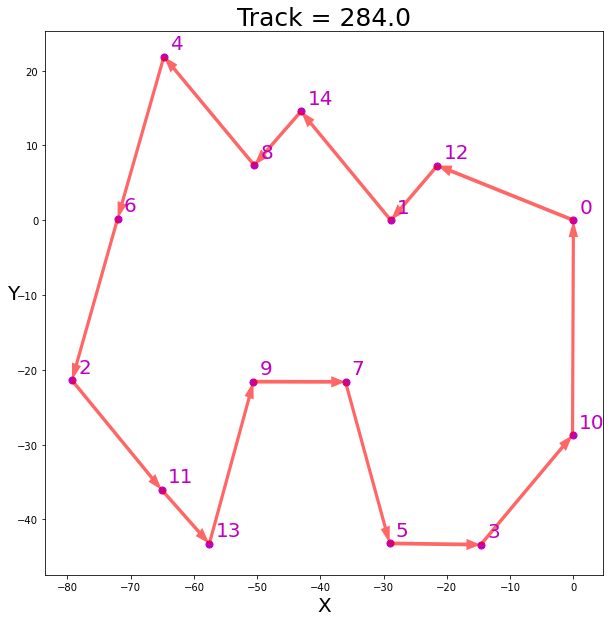

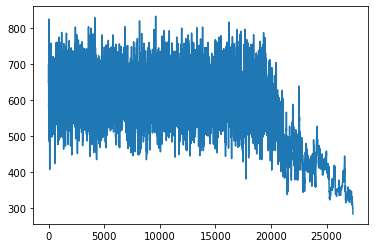

In [313]:
get_track(X, coordinates, plot=True)
plt.plot(scores)

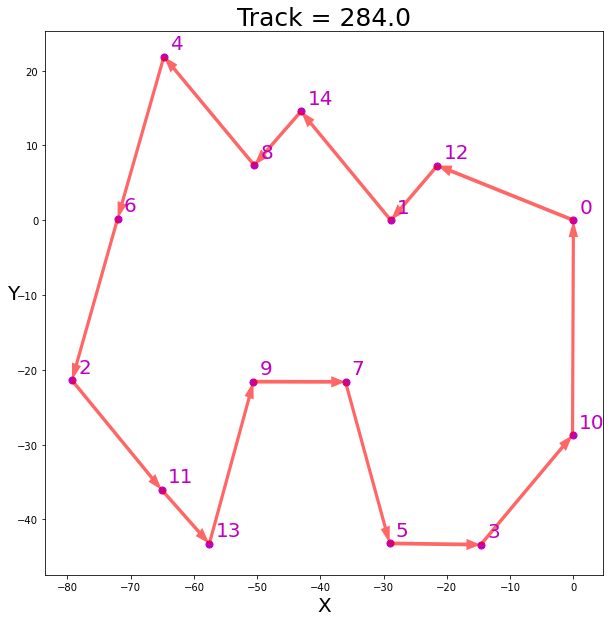

284.0

In [283]:
answer = np.asarray([13, 2,15, 9, 5, 7, 3,12,14,10, 8, 6, 4,11,]) - 1
get_track(answer, coordinates, plot=True)

In [248]:
decimal.Decimal(1).exp()

Decimal('2.718281828459045235360287471')

In [266]:
random.randint(0,1)

0